<div style="border-left: 6px solid #4A90E2; padding:20px; border-radius:10px; font-family:Arial, sans-serif; text-align:center; font-size:28px; font-weight:bold;">
  📊 Análise de Resultados
</div>


<div style="border-left: 6px solid #27ae60; margin-left:40px; padding:10px; border-radius:10px; font-family:Arial, sans-serif; font-size:24px;">
  <h2 style="margin-top: 0; font-size:24px;">📦 Import Libraries</h2>
</div>

<div style="margin-left:60px; padding:10px;"> 
  <p style="font-size:18px;">This is the initial block of the rare species image classification project.</p>

  <p>In this section, we perform the following tasks:</p>

  <ul style="line-height: 1.6;">
    <li>📁 <strong>Import libraries</strong> for data manipulation (pandas), file paths (pathlib), and image processing (PIL).</li>
    <li>🖼️ <strong>Apply visual styling</strong> using matplotlib and seaborn to ensure clean and consistent plots.</li>
    <li>📂 <strong>Define the main project directories</strong>, including image folders and the metadata CSV file.</li>
    <li>✅ <strong>Automatic path validation</strong> to ensure all required files and directories exist.</li>
  </ul>

  <p>This setup provides a reliable foundation for safely loading and exploring the dataset.</p>
</div>


In [1]:
import sys
import os
import pandas as pd
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
sys.path.append(os.path.abspath('../src'))

from main import main
from visualization_tools import GAVisualizer
from models import Player, Team, Individual
from utils import create_valid_team, create_valid_individual, generate_initial_population
from crossover import (
    team_swap_crossover,
    player_swap_crossover,
    uniform_team_crossover,
    position_based_crossover,
    gene_level_crossover
)
from mutation import (
    random_player_mutation,
    swap_players_between_teams,
    replace_team_mutation,
    expensive_player_mutation,
    cross_position_mutation,
    forward_reset_mutation,
    rotate_teams_mutation
)
from selection import (
    tournament_selection,
    roulette_wheel_selection,
    truncation_selection,
    rank_selection,
    stochastic_universal_sampling,
    elitism,
    select_parents
)


<div style="border-left: 6px solid #27ae60; margin-left:40px; padding:10px; border-radius:10px; font-family:Arial, sans-serif; font-size:24px;">
  <h2 style="margin-top: 0; font-size:24px;">⚙️ Configurações do Experimento</h2>
</div>

<div style="margin-left:60px; padding:10px;"> 
  <p style="font-size:18px;">Nesta secção definem-se as configurações essenciais para executar as experiências genéticas.</p>

  <p>Os seguintes parâmetros e operadores são inicializados:</p>

  <ul style="line-height: 1.6;">
    <li>📁 <strong>Diretórios</strong>: Criação de <code>RESULTS_DIR</code> para guardar os gráficos e logs.</li>
    <li>🔁 <strong>Taxas de Crossover</strong>: 50%, 60%, 80%, 90%.</li>
    <li>🧬 <strong>Taxas de Mutação</strong>: 40%, 60%, 80%, 100%.</li>
    <li>🔂 <strong>Operadores de Crossover</strong>: <code>team_swap</code>, <code>player_swap</code>, <code>uniform_team</code>, etc.</li>
    <li>🔧 <strong>Operadores de Mutação</strong>: 7 métodos implementados incluindo <code>random</code>, <code>rotate</code> e <code>replace</code>.</li>
    <li>🎯 <strong>Métodos de Seleção</strong>: <code>tournament</code>, <code>roulette</code>, <code>elitism</code>, entre outros.</li>
    <li>🧍‍♂️ <strong>Importação de Jogadores</strong>: Dados lidos a partir de <code>players.csv</code>.</li>
  </ul>

  <p>Estas configurações definem a base para todas as execuções dos algoritmos genéticos.</p>
</div>


In [2]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
RESULTS_DIR = os.path.join(BASE_DIR, "results", "plots")

mutation_rates = [0.4, 0.6, 0.8, 1.0]
crossover_rates = [0.5, 0.6, 0.8, 0.9]

best_overall_per_selection = []

crossover_ops = [
    team_swap_crossover,
    player_swap_crossover,
    uniform_team_crossover,
    position_based_crossover,
    gene_level_crossover
]

mutation_ops = [
    random_player_mutation,
    replace_team_mutation,
    expensive_player_mutation,
    swap_players_between_teams,
    cross_position_mutation,
    forward_reset_mutation,
    rotate_teams_mutation
]

selection_methods = [
    "tournament",
    "roulette",
    "truncation",
    "rank",
    "sus",
    "elitism"
]

In [3]:
viz = GAVisualizer(save_dir=RESULTS_DIR)
players_csv = pd.read_csv('../data/players.csv')

In [4]:
players = []
for idx, row in players_csv.iterrows():
    p = Player(
        player_id=idx + 1,
        name=row['Name'],
        position=row['Position'],
        skill=row['Skill'],
        cost=row['Salary (€M)']
    )

    players.append(p)

print(f"Número de jogadores carregados: {len(players)}")

Número de jogadores carregados: 35


<div style="border-left: 6px solid #27ae60; margin-left:40px; padding:10px; border-radius:10px; font-family:Arial, sans-serif; font-size:24px;">
  <h2 style="margin-top: 0; font-size:24px;">🧠 Execução Geral das Combinações</h2>
</div>

<div style="margin-left:60px; padding:10px;"> 
  <p style="font-size:18px;">Este bloco percorre todas as combinações possíveis de seleção, crossover e mutação, realizando 4 execuções por combinação com diferentes taxas.</p>

  <p>Para cada combinação, são gerados:</p>

  <ul style="line-height: 1.6;">
    <li>📈 <strong>Gráficos individuais</strong> da evolução do fitness por execução.</li>
    <li>📂 <strong>Ficheiros de histórico</strong> e logs do melhor indivíduo.</li>
    <li>📊 <strong>Gráficos comparativos</strong> entre as 4 taxas de mutação/crossover por combinação.</li>
    <li>🏆 <strong>Resumo dos melhores resultados</strong> por combinação e por método de seleção.</li>
  </ul>

  <p>O último gráfico gerado compara a <strong>melhor execução de cada método de seleção</strong>, permitindo identificar qual abordagem teve o melhor desempenho geral.</p>
</div>


In [5]:
for selection_method in selection_methods:
    results_summary = []
    selection_dir = os.path.join(RESULTS_DIR, selection_method)
    os.makedirs(selection_dir, exist_ok=True)

    for crossover_op in crossover_ops:
        for mutation_op in mutation_ops:
            for i in range(4):
                print(f"▶️ Execução - Sel: {selection_method} | Cross: {crossover_op.__name__}, Mut: {mutation_op.__name__}, Run {i+1}")
                best_ind, history = main(players, 
                                         pop_size=20, 
                                         generations=30, 
                                         elite_count=2,
                                         selection_method=selection_method,
                                         crossover_op=crossover_op,
                                         mutation_op=mutation_op,
                                         crossover_rate=crossover_rates[i],
                                         mutation_rate=mutation_rates[i],
                                         verbose=False)

                label = f"{crossover_op.__name__}/{mutation_op.__name__} [Mut {int(mutation_rates[i]*100)}% / Cross {int(crossover_rates[i]*100)}%]"
                sub_dir = os.path.join(selection_method, crossover_op.__name__, mutation_op.__name__)
                save_name = f"{label.replace(' ', '_')}"

                viz.plot_fitness_curve(history, label=label, save_as=os.path.join(sub_dir, save_name + ".png"))

                log_path = os.path.join(RESULTS_DIR, sub_dir, save_name + "_melhor_individuo.txt")
                os.makedirs(os.path.dirname(log_path), exist_ok=True)
                with open(log_path, "w", encoding="utf-8") as f:
                    f.write("Melhor indivíduo final\n")
                    f.write(f"Fitness: {best_ind.fitness():.2f}\n")
                    f.write(f"Selection: {selection_method}, Crossover: {crossover_op.__name__}, Mutation: {mutation_op.__name__}\n")
                    f.write(f"Crossover rate: {crossover_rates[i]*100:.0f}%, Mutation rate: {mutation_rates[i]*100:.0f}%\n\n")
                    for j, team in enumerate(best_ind.teams):
                        f.write(f"Equipa {j+1} - Média: {team.average_skill():.2f} | Custo total: €{team.total_cost():.2f}\n")
                        for p in team.players:
                            f.write(f"{p.name} ({p.position}) - Skill: {p.skill}, Custo: {p.cost}\n")
                        f.write("\n")

                history_path = os.path.join(RESULTS_DIR, sub_dir, save_name + "_history.txt")
                with open(history_path, "w", encoding="utf-8") as hf:
                    hf.write(",".join(f"{v:.2f}" for v in history))

                results_summary.append((label, history, best_ind))

            if i == 3:
                rate_labels = [
                    f"Mut {int(mutation_rates[j]*100)}% / Cross {int(crossover_rates[j]*100)}%"
                    for j in range(4)
                ]
                rate_histories = [
                    h for (l, h, _) in results_summary
                    if l.startswith(f"{crossover_op.__name__}/{mutation_op.__name__}")
                ]
                rate_plot_title = f"{selection_method.upper()} - {crossover_op.__name__} + {mutation_op.__name__}"
                rate_plot_name = os.path.join(selection_method, crossover_op.__name__, mutation_op.__name__, "comparacao_taxas.png")
                viz.compare_fitness_curves(rate_histories, rate_labels, title=rate_plot_title, save_as=rate_plot_name)

    combo_groups = defaultdict(list)
    for label, history, best_ind in results_summary:
        combo_key = label.split("[")[0].strip()
        combo_groups[combo_key].append((label, history, best_ind))

    best_histories = []
    best_labels = []
    best_fitness = -float("inf")
    best_history_overall = None

    for combo_key, runs in combo_groups.items():
        best_label, best_history, best_ind = max(runs, key=lambda x: max(x[1]))
        best_histories.append(best_history)
        best_labels.append(combo_key)

        if max(best_history) > best_fitness:
            best_fitness = max(best_history)
            best_history_overall = best_history

    viz.compare_fitness_curves(
        best_histories,
        best_labels,
        title=f"Comparação - Método de Seleção: {selection_method} (Melhores por combinação)",
        save_as=os.path.join(selection_method, f"comparacao_{selection_method}_melhores.png")
    )

    best_overall_per_selection.append((selection_method, best_history_overall))

viz.compare_fitness_curves(
    [h for (_, h) in best_overall_per_selection],
    [s for (s, _) in best_overall_per_selection],
    title="Melhor Execução por Método de Seleção",
    save_as=os.path.join(RESULTS_DIR, "comparacao_melhor_por_selecao.png")
)

▶️ Execução - Sel: tournament | Cross: team_swap_crossover, Mut: random_player_mutation, Run 1
✅ Resultado final escrito em 'results/logs/melhor_individuo.txt'
✅ Gráfico guardado em: d:\Repositories\CIFO_SLO\results\plots\tournament\team_swap_crossover\random_player_mutation\team_swap_crossover/random_player_mutation_[Mut_40%_/_Cross_50%].png
▶️ Execução - Sel: tournament | Cross: team_swap_crossover, Mut: random_player_mutation, Run 2
✅ Resultado final escrito em 'results/logs/melhor_individuo.txt'
✅ Gráfico guardado em: d:\Repositories\CIFO_SLO\results\plots\tournament\team_swap_crossover\random_player_mutation\team_swap_crossover/random_player_mutation_[Mut_60%_/_Cross_60%].png
▶️ Execução - Sel: tournament | Cross: team_swap_crossover, Mut: random_player_mutation, Run 3
✅ Resultado final escrito em 'results/logs/melhor_individuo.txt'
✅ Gráfico guardado em: d:\Repositories\CIFO_SLO\results\plots\tournament\team_swap_crossover\random_player_mutation\team_swap_crossover/random_player_

<div style="border-left: 6px solid #27ae60; margin-left:40px; padding:10px; border-radius:10px; font-family:Arial, sans-serif; font-size:24px;">
  <h2 style="margin-top: 0; font-size:24px;">🎯 Selection Method: <span style="color:#2980b9;">Tournament</span></h2>
</div>


<div style="margin-left:60px; padding:10px; font-family:Arial, sans-serif;">
  <h3 style="margin-top: 10px; font-size:20px;">🧬 Crossover: <em>Gene Level Crossover</em></h3>

  <p style="font-size:18px;">Esta figura composta mostra os gráficos de evolução do fitness gerados para cada um dos 7 operadores de mutação quando utilizados em conjunto com o crossover <strong>gene_level_crossover</strong> e o método de seleção <strong>tournament</strong>.</p>

  <p>A comparação baseia-se em 4 execuções por operador de mutação, com diferentes combinações de taxas:</p>
  <ul style="line-height: 1.6;">
    <li>🔁 <strong>Crossover Rates</strong>: 50%, 60%, 80%, 90%</li>
    <li>🧬 <strong>Mutation Rates</strong>: 40%, 60%, 80%, 100%</li>
  </ul>

  <p>Cada gráfico mostra a evolução do melhor fitness ao longo das gerações. Esta composição permite analisar quais operadores de mutação funcionam melhor com este crossover específico.</p>
</div>


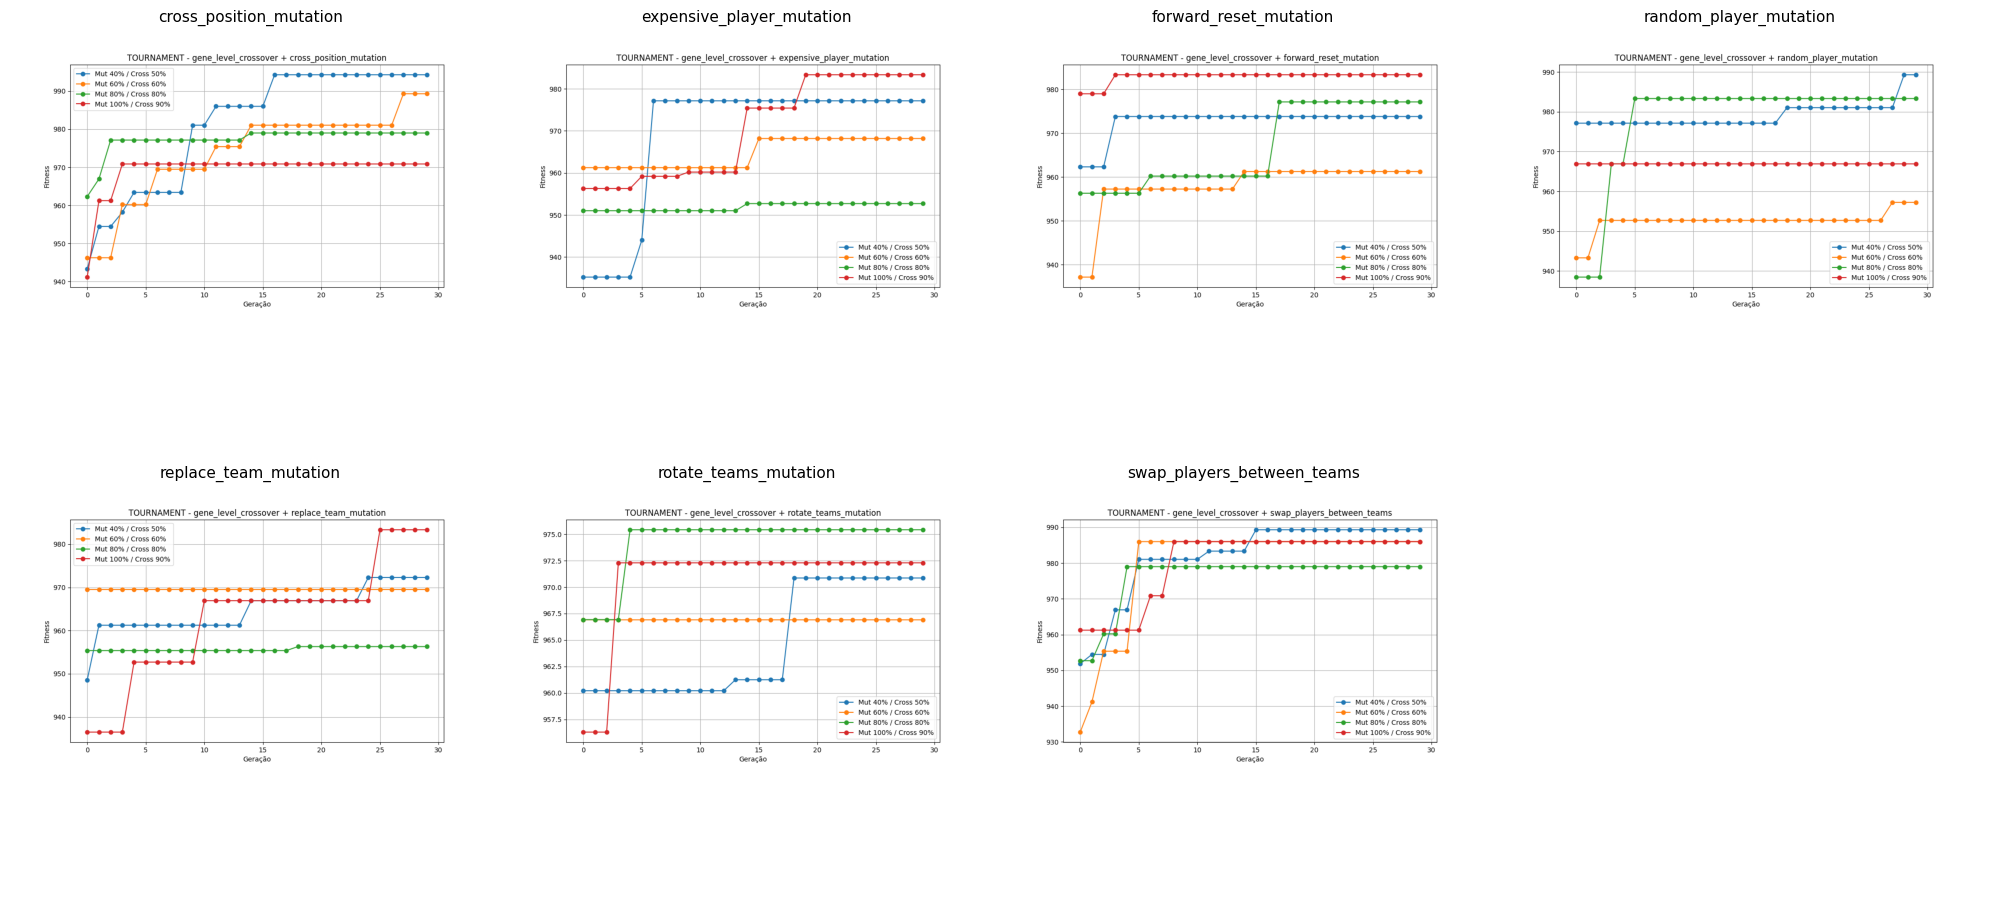

In [6]:
image_paths = [
    "../results/plots/tournament/gene_level_crossover/cross_position_mutation/comparacao_taxas.png",
    "../results/plots/tournament/gene_level_crossover/expensive_player_mutation/comparacao_taxas.png",
    "../results/plots/tournament/gene_level_crossover/forward_reset_mutation/comparacao_taxas.png",
    "../results/plots/tournament/gene_level_crossover/random_player_mutation/comparacao_taxas.png",
    "../results/plots/tournament/gene_level_crossover/replace_team_mutation/comparacao_taxas.png",
    "../results/plots/tournament/gene_level_crossover/rotate_teams_mutation/comparacao_taxas.png",
    "../results/plots/tournament/gene_level_crossover/swap_players_between_teams/comparacao_taxas.png"
]

titles = [
    "cross_position_mutation",
    "expensive_player_mutation",
    "forward_reset_mutation",
    "random_player_mutation",
    "replace_team_mutation",
    "rotate_teams_mutation",
    "swap_players_between_teams"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (path, title) in enumerate(zip(image_paths, titles)):
    if os.path.exists(path):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=11)
    else:
        axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
        axes[i].axis('off')

if len(image_paths) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("../results/plots/tournament/figura_composta_7_graficos_gene_level_crossover.png")
plt.show()

<div style="margin-left:60px; padding:10px; font-family:Arial, sans-serif;">
  <h3 style="margin-top: 10px; font-size:20px;">🔁 Crossover: <em>Player Swap Crossover</em></h3>
</div>


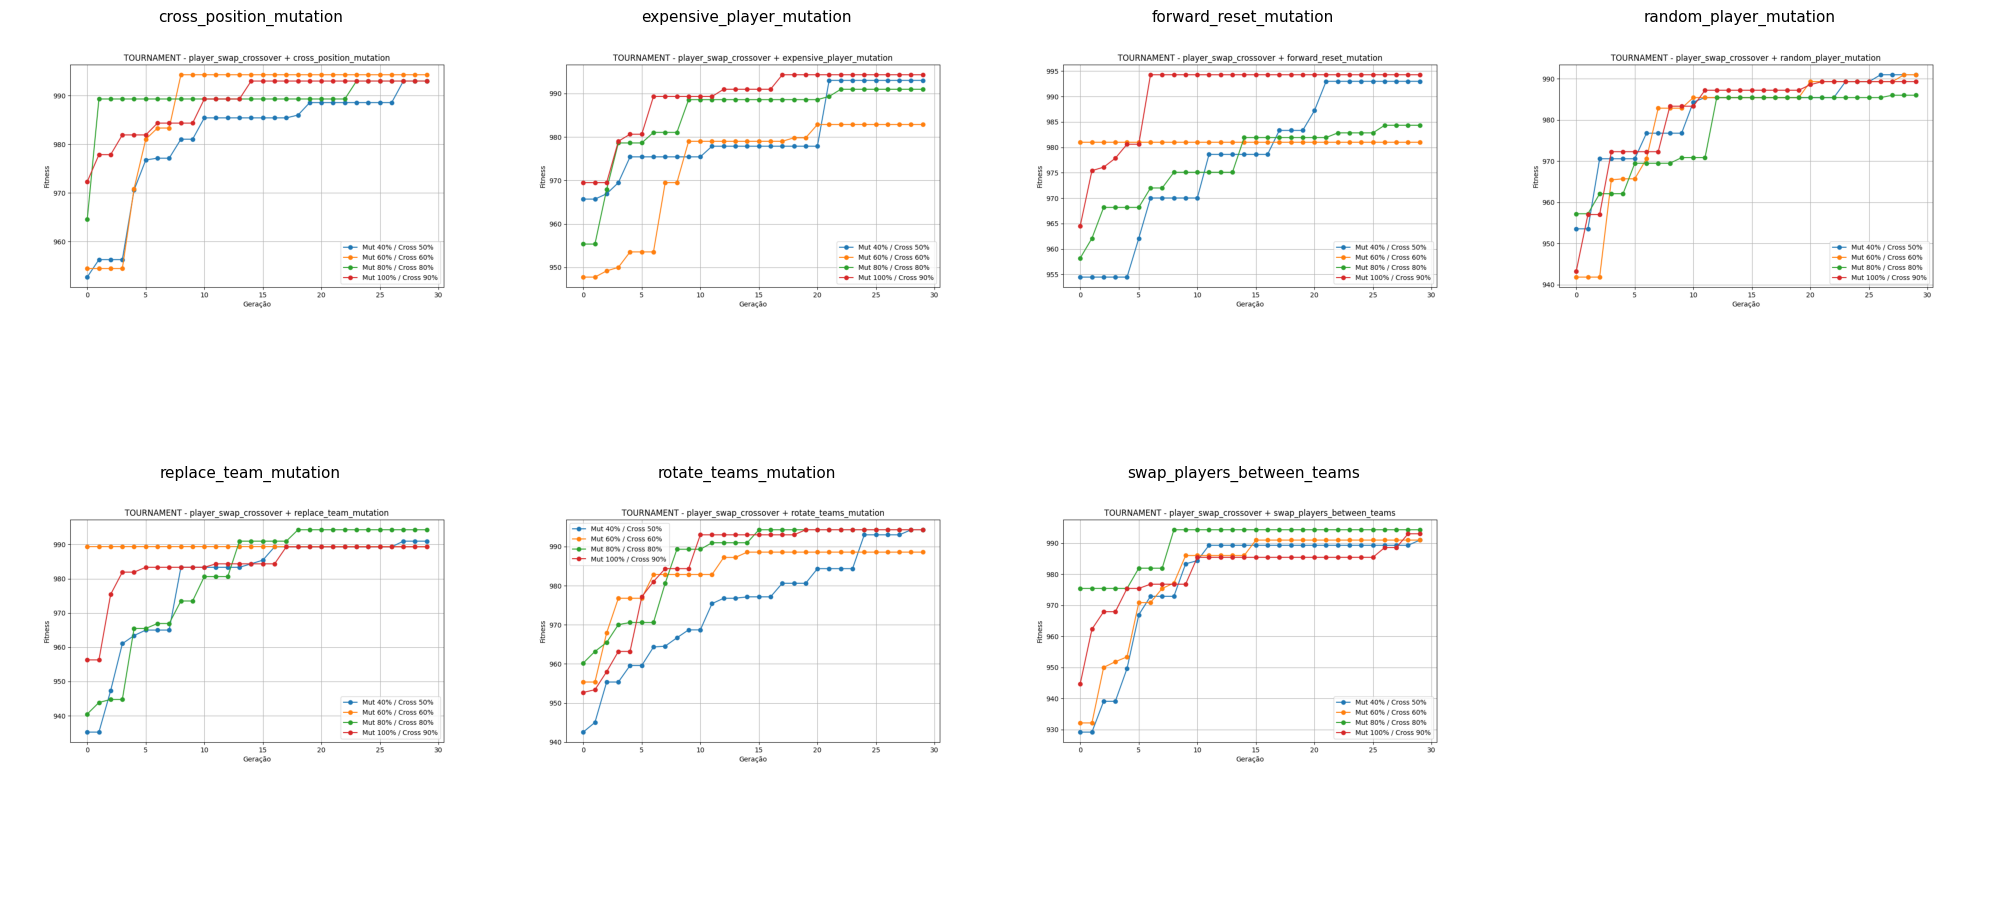

In [7]:
image_paths = [
    "../results/plots/tournament/player_swap_crossover/cross_position_mutation/comparacao_taxas.png",
    "../results/plots/tournament/player_swap_crossover/expensive_player_mutation/comparacao_taxas.png",
    "../results/plots/tournament/player_swap_crossover/forward_reset_mutation/comparacao_taxas.png",
    "../results/plots/tournament/player_swap_crossover/random_player_mutation/comparacao_taxas.png",
    "../results/plots/tournament/player_swap_crossover/replace_team_mutation/comparacao_taxas.png",
    "../results/plots/tournament/player_swap_crossover/rotate_teams_mutation/comparacao_taxas.png",
    "../results/plots/tournament/player_swap_crossover/swap_players_between_teams/comparacao_taxas.png"
]

titles = [
    "cross_position_mutation",
    "expensive_player_mutation",
    "forward_reset_mutation",
    "random_player_mutation",
    "replace_team_mutation",
    "rotate_teams_mutation",
    "swap_players_between_teams"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (path, title) in enumerate(zip(image_paths, titles)):
    if os.path.exists(path):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=11)
    else:
        axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
        axes[i].axis('off')

if len(image_paths) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("../results/plots/tournament/figura_composta_7_graficos_player_swap_crossover.png")
plt.show()

<div style="margin-left:60px; padding:10px; font-family:Arial, sans-serif;">
  <h3 style="margin-top: 10px; font-size:20px;">🧩 Crossover: <em>Position Based Crossover</em></h3>
</div>


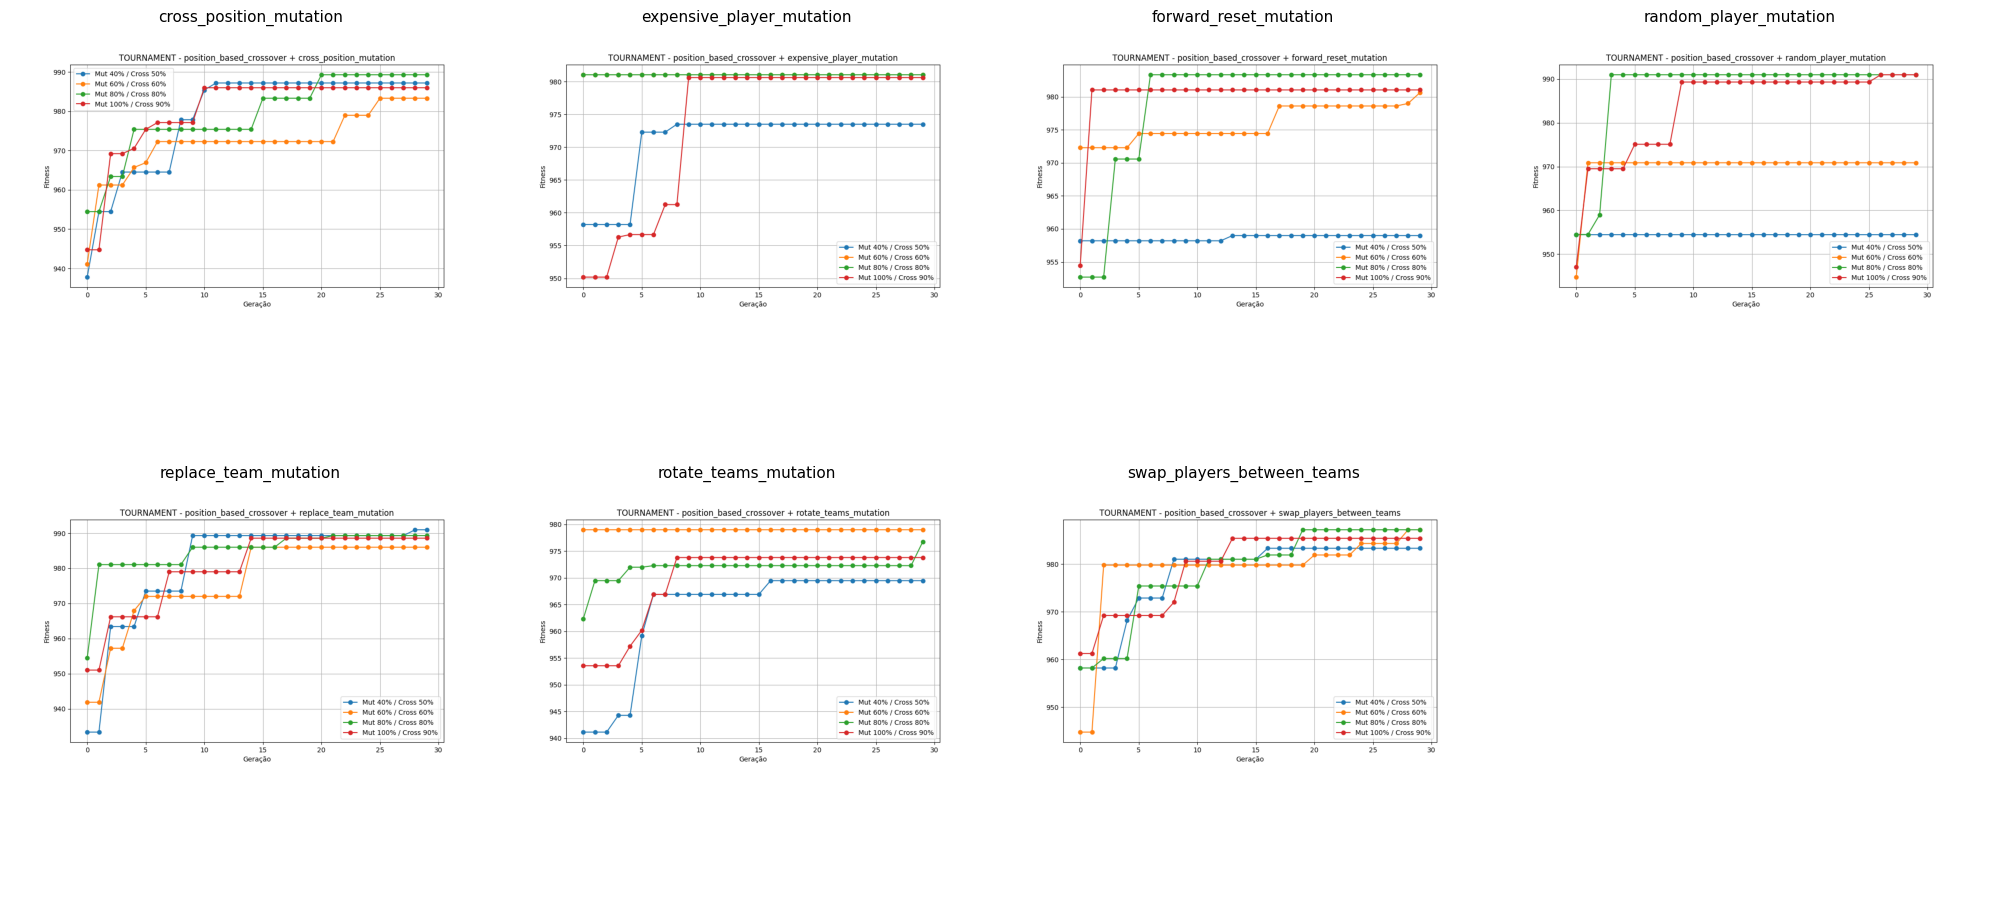

In [8]:
image_paths = [
    "../results/plots/tournament/position_based_crossover/cross_position_mutation/comparacao_taxas.png",
    "../results/plots/tournament/position_based_crossover/expensive_player_mutation/comparacao_taxas.png",
    "../results/plots/tournament/position_based_crossover/forward_reset_mutation/comparacao_taxas.png",
    "../results/plots/tournament/position_based_crossover/random_player_mutation/comparacao_taxas.png",
    "../results/plots/tournament/position_based_crossover/replace_team_mutation/comparacao_taxas.png",
    "../results/plots/tournament/position_based_crossover/rotate_teams_mutation/comparacao_taxas.png",
    "../results/plots/tournament/position_based_crossover/swap_players_between_teams/comparacao_taxas.png"
]

titles = [
    "cross_position_mutation",
    "expensive_player_mutation",
    "forward_reset_mutation",
    "random_player_mutation",
    "replace_team_mutation",
    "rotate_teams_mutation",
    "swap_players_between_teams"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (path, title) in enumerate(zip(image_paths, titles)):
    if os.path.exists(path):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=11)
    else:
        axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
        axes[i].axis('off')

if len(image_paths) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("../results/plots/tournament/figura_composta_7_graficos_position_based_crossover.png")
plt.show()

<div style="margin-left:60px; padding:10px; font-family:Arial, sans-serif;">
  <h3 style="margin-top: 10px; font-size:20px;">🔄 Crossover: <em>Team Swap Crossover</em></h3>
</div>


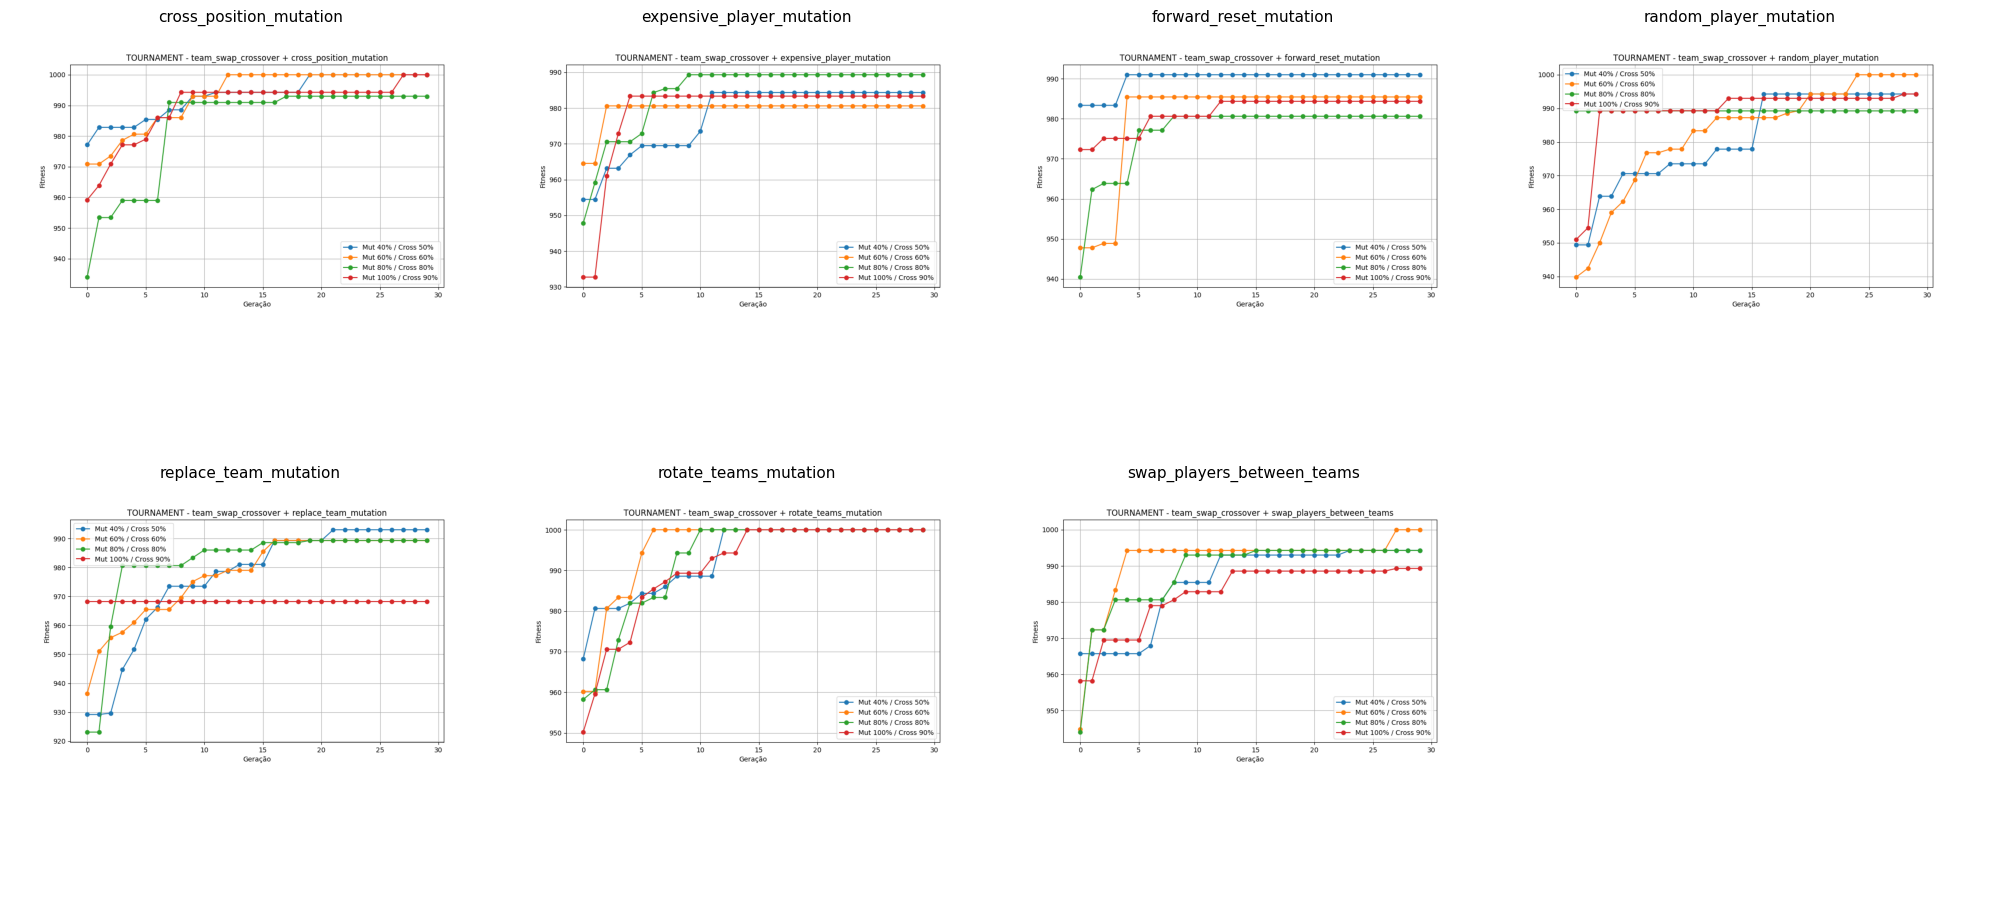

In [9]:
image_paths = [
    "../results/plots/tournament/team_swap_crossover/cross_position_mutation/comparacao_taxas.png",
    "../results/plots/tournament/team_swap_crossover/expensive_player_mutation/comparacao_taxas.png",
    "../results/plots/tournament/team_swap_crossover/forward_reset_mutation/comparacao_taxas.png",
    "../results/plots/tournament/team_swap_crossover/random_player_mutation/comparacao_taxas.png",
    "../results/plots/tournament/team_swap_crossover/replace_team_mutation/comparacao_taxas.png",
    "../results/plots/tournament/team_swap_crossover/rotate_teams_mutation/comparacao_taxas.png",
    "../results/plots/tournament/team_swap_crossover/swap_players_between_teams/comparacao_taxas.png"
]

titles = [
    "cross_position_mutation",
    "expensive_player_mutation",
    "forward_reset_mutation",
    "random_player_mutation",
    "replace_team_mutation",
    "rotate_teams_mutation",
    "swap_players_between_teams"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (path, title) in enumerate(zip(image_paths, titles)):
    if os.path.exists(path):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=11)
    else:
        axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
        axes[i].axis('off')

if len(image_paths) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("../results/plots/tournament/figura_composta_7_graficos_team_swap_crossover.png")
plt.show()

<div style="margin-left:60px; padding:10px; font-family:Arial, sans-serif;">
  <h3 style="margin-top: 10px; font-size:20px;">🧪 Crossover: <em>Uniform Team Crossover</em></h3>
</div>


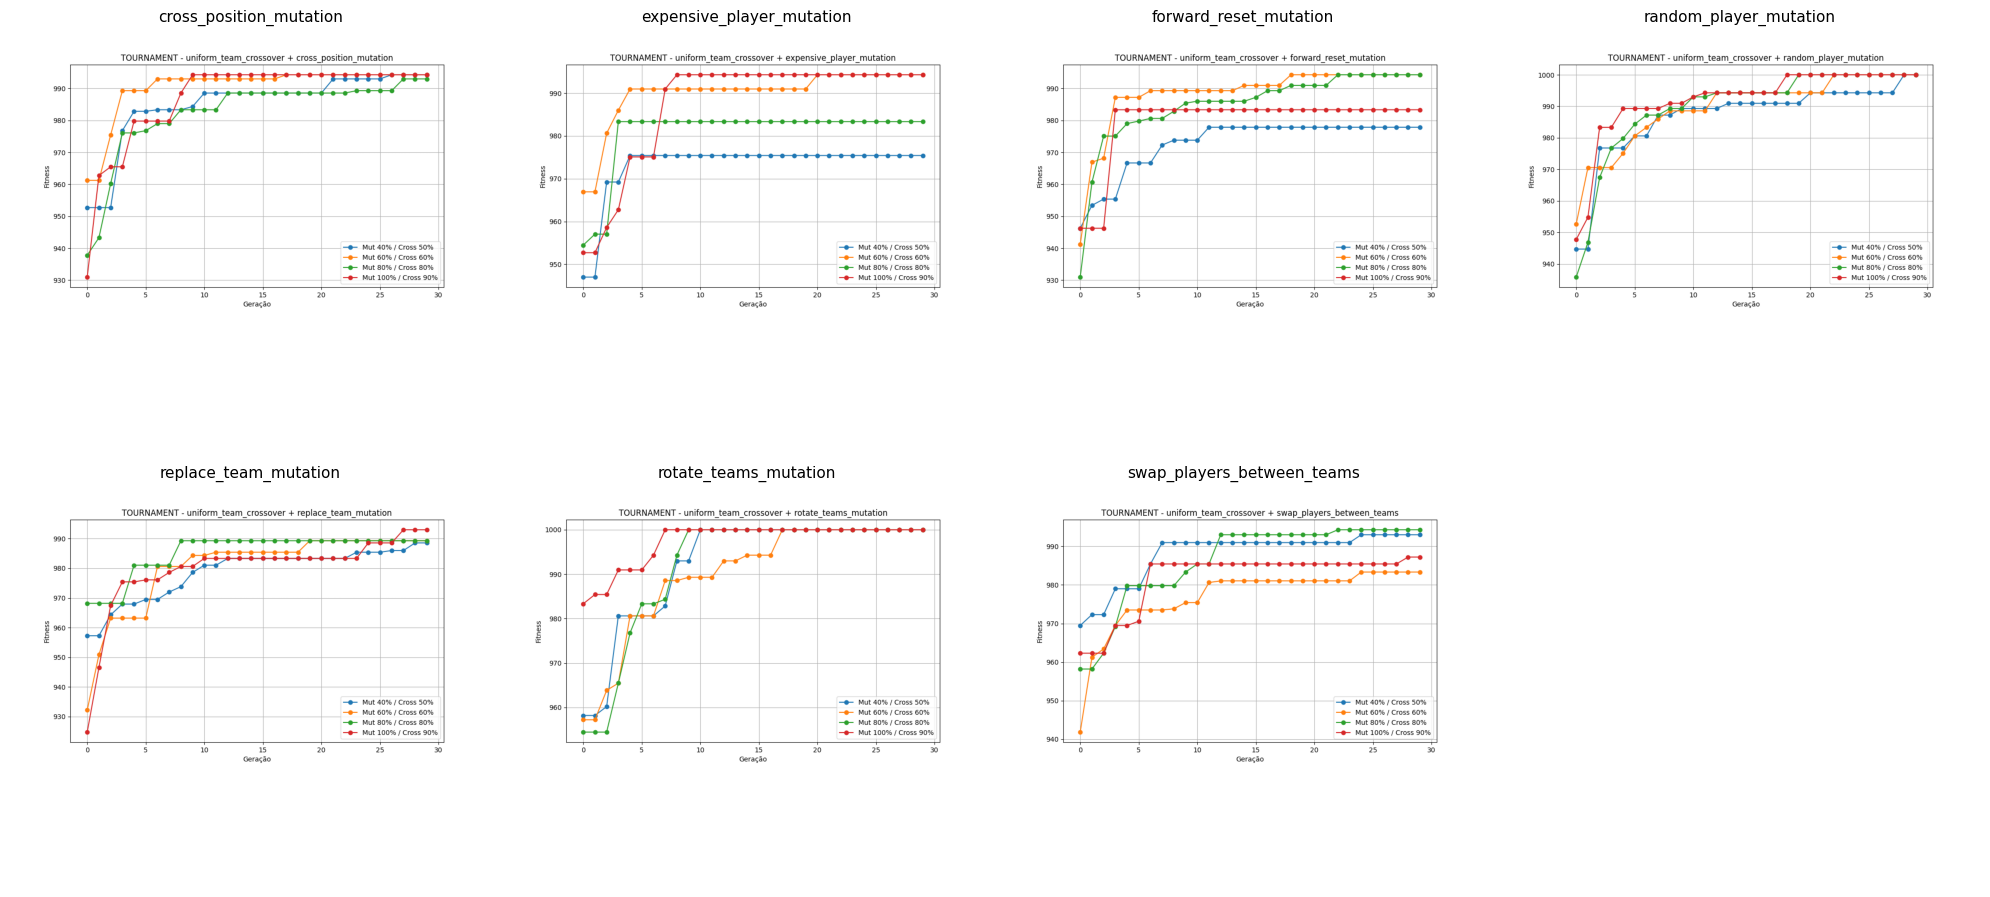

In [10]:
image_paths = [
    "../results/plots/tournament/uniform_team_crossover/cross_position_mutation/comparacao_taxas.png",
    "../results/plots/tournament/uniform_team_crossover/expensive_player_mutation/comparacao_taxas.png",
    "../results/plots/tournament/uniform_team_crossover/forward_reset_mutation/comparacao_taxas.png",
    "../results/plots/tournament/uniform_team_crossover/random_player_mutation/comparacao_taxas.png",
    "../results/plots/tournament/uniform_team_crossover/replace_team_mutation/comparacao_taxas.png",
    "../results/plots/tournament/uniform_team_crossover/rotate_teams_mutation/comparacao_taxas.png",
    "../results/plots/tournament/uniform_team_crossover/swap_players_between_teams/comparacao_taxas.png"
]

titles = [
    "cross_position_mutation",
    "expensive_player_mutation",
    "forward_reset_mutation",
    "random_player_mutation",
    "replace_team_mutation",
    "rotate_teams_mutation",
    "swap_players_between_teams"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (path, title) in enumerate(zip(image_paths, titles)):
    if os.path.exists(path):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=11)
    else:
        axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
        axes[i].axis('off')

if len(image_paths) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("../results/plots/tournament/figura_composta_7_graficos_uniform_team_crossover.png")
plt.show()

<div style="border-left: 6px solid #27ae60; margin-left:40px; padding:10px; border-radius:10px; font-family:Arial, sans-serif; font-size:24px;">
  <h2 style="margin-top: 0; font-size:24px;">🎯 Selection Method: <span style="color:#2980b9;">Roulette Wheel</span></h2>
</div>


<div style="margin-left:60px; padding:10px; font-family:Arial, sans-serif;">
  <h3 style="margin-top: 10px; font-size:20px;">🧬 Crossover: <em>Gene Level Crossover</em></h3>

  <p style="font-size:18px;">Esta figura composta mostra os gráficos de evolução do fitness gerados para cada um dos 7 operadores de mutação quando utilizados em conjunto com o crossover <strong>gene_level_crossover</strong> e o método de seleção <strong>roulette wheel</strong>.</p>

  <p>A comparação baseia-se em 4 execuções por operador de mutação, com diferentes combinações de taxas:</p>
  <ul style="line-height: 1.6;">
    <li>🔁 <strong>Crossover Rates</strong>: 50%, 60%, 80%, 90%</li>
    <li>🧬 <strong>Mutation Rates</strong>: 40%, 60%, 80%, 100%</li>
  </ul>

  <p>Cada gráfico mostra a evolução do melhor fitness ao longo das gerações. Esta composição permite analisar quais operadores de mutação funcionam melhor com este crossover específico.</p>
</div>


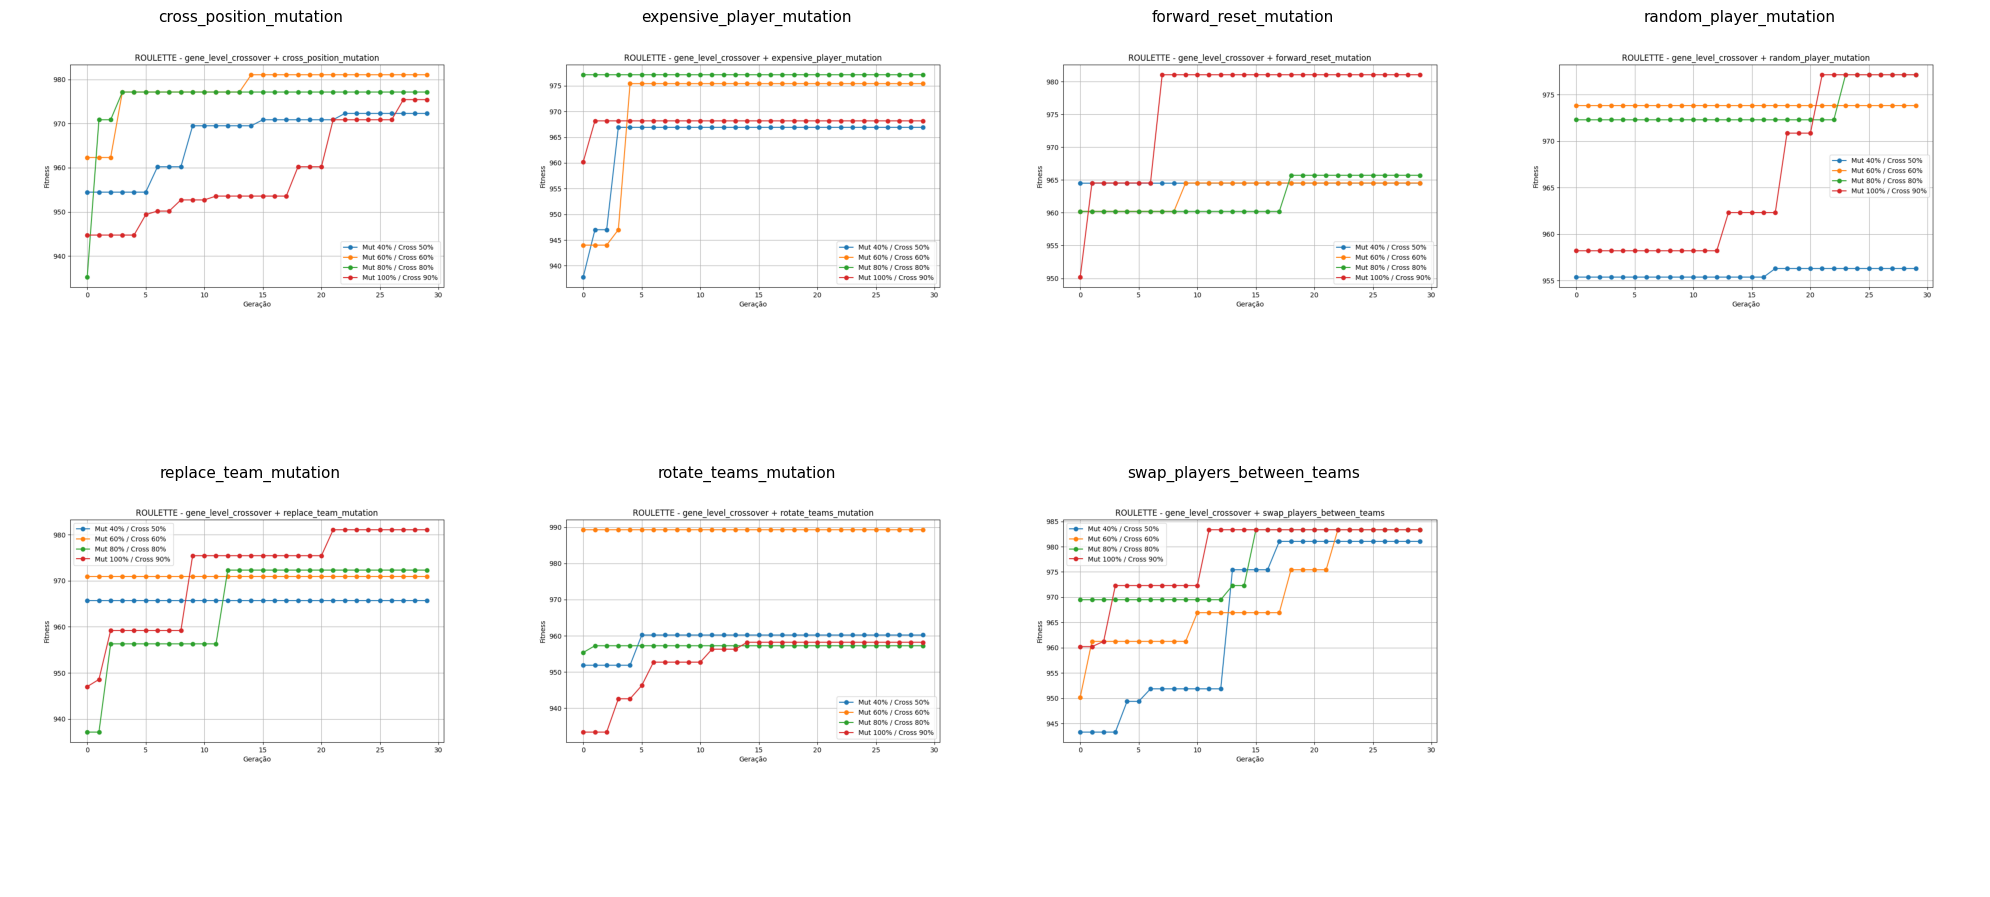

In [11]:
image_paths = [
    "../results/plots/roulette/gene_level_crossover/cross_position_mutation/comparacao_taxas.png",
    "../results/plots/roulette/gene_level_crossover/expensive_player_mutation/comparacao_taxas.png",
    "../results/plots/roulette/gene_level_crossover/forward_reset_mutation/comparacao_taxas.png",
    "../results/plots/roulette/gene_level_crossover/random_player_mutation/comparacao_taxas.png",
    "../results/plots/roulette/gene_level_crossover/replace_team_mutation/comparacao_taxas.png",
    "../results/plots/roulette/gene_level_crossover/rotate_teams_mutation/comparacao_taxas.png",
    "../results/plots/roulette/gene_level_crossover/swap_players_between_teams/comparacao_taxas.png"
]

titles = [
    "cross_position_mutation",
    "expensive_player_mutation",
    "forward_reset_mutation",
    "random_player_mutation",
    "replace_team_mutation",
    "rotate_teams_mutation",
    "swap_players_between_teams"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (path, title) in enumerate(zip(image_paths, titles)):
    if os.path.exists(path):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=11)
    else:
        axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
        axes[i].axis('off')

if len(image_paths) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("../results/plots/roulette/figura_composta_7_graficos_gene_level_crossover.png")
plt.show()

<div style="margin-left:60px; padding:10px; font-family:Arial, sans-serif;">
  <h3 style="margin-top: 10px; font-size:20px;">🔁 Crossover: <em>Player Swap Crossover</em></h3>
</div>


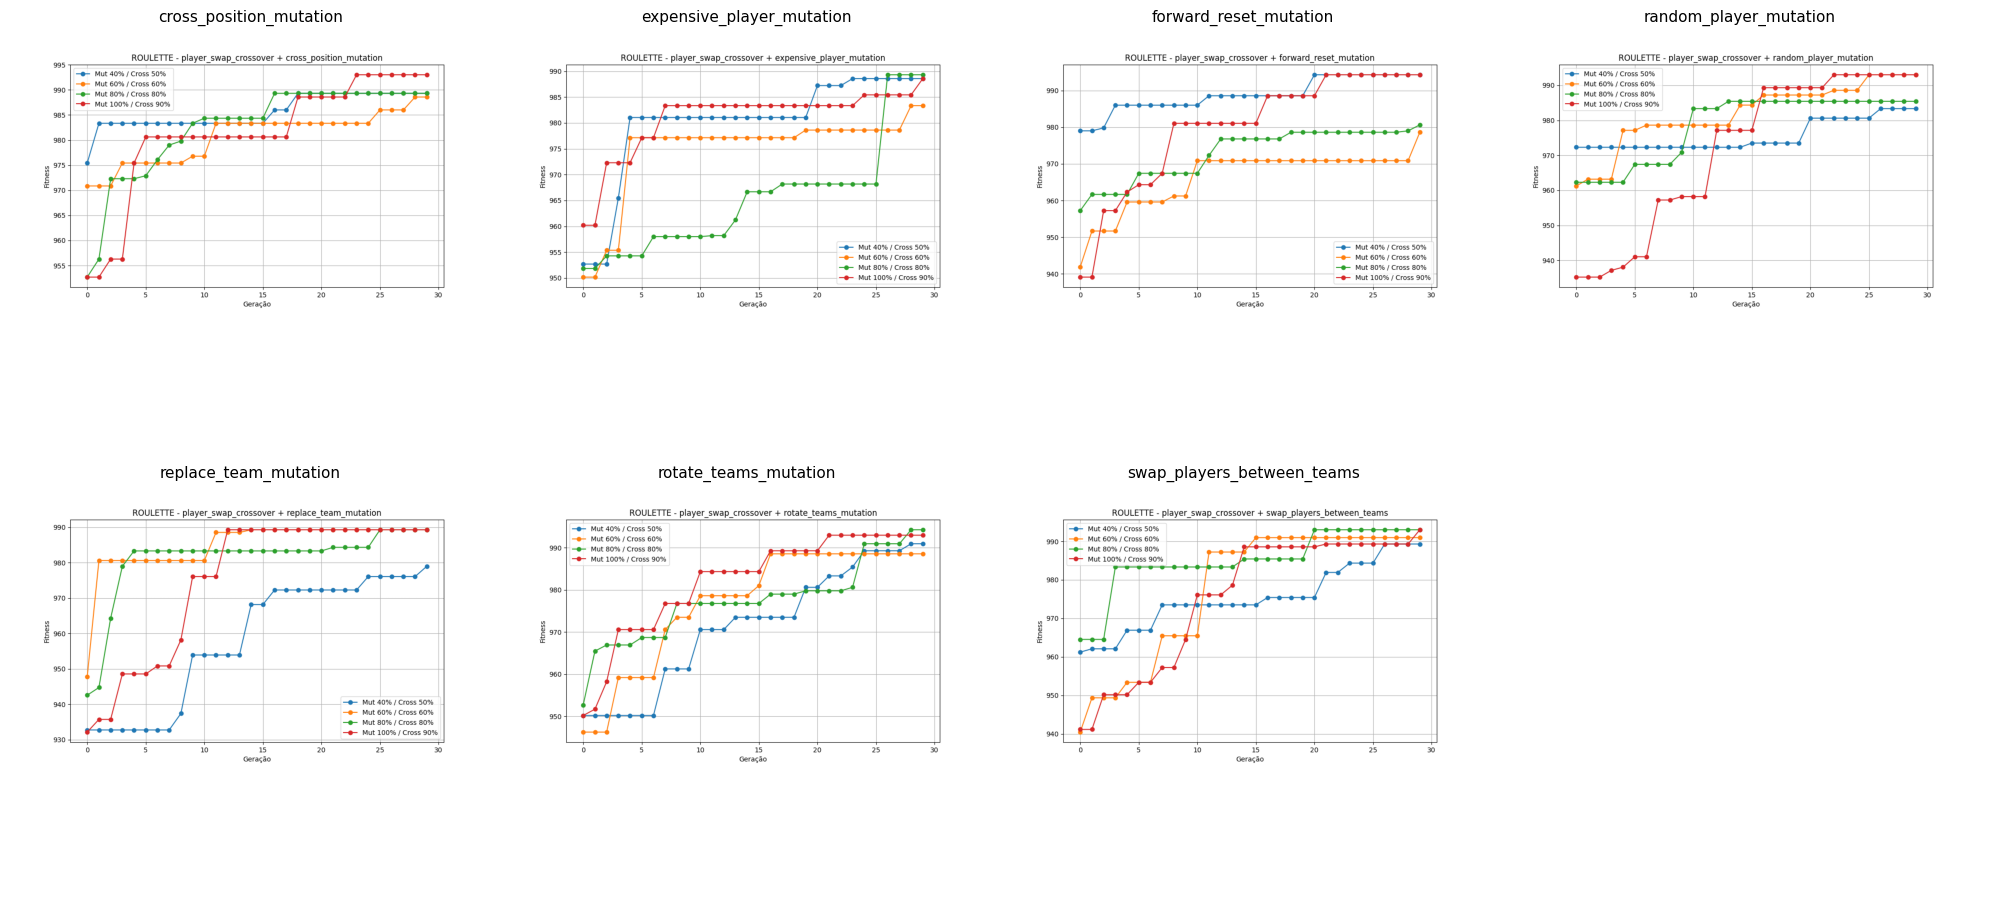

In [12]:
image_paths = [
    "../results/plots/roulette/player_swap_crossover/cross_position_mutation/comparacao_taxas.png",
    "../results/plots/roulette/player_swap_crossover/expensive_player_mutation/comparacao_taxas.png",
    "../results/plots/roulette/player_swap_crossover/forward_reset_mutation/comparacao_taxas.png",
    "../results/plots/roulette/player_swap_crossover/random_player_mutation/comparacao_taxas.png",
    "../results/plots/roulette/player_swap_crossover/replace_team_mutation/comparacao_taxas.png",
    "../results/plots/roulette/player_swap_crossover/rotate_teams_mutation/comparacao_taxas.png",
    "../results/plots/roulette/player_swap_crossover/swap_players_between_teams/comparacao_taxas.png"
]

titles = [
    "cross_position_mutation",
    "expensive_player_mutation",
    "forward_reset_mutation",
    "random_player_mutation",
    "replace_team_mutation",
    "rotate_teams_mutation",
    "swap_players_between_teams"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (path, title) in enumerate(zip(image_paths, titles)):
    if os.path.exists(path):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=11)
    else:
        axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
        axes[i].axis('off')

if len(image_paths) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("../results/plots/roulette/figura_composta_7_graficos_player_swap_crossover.png")
plt.show()

<div style="margin-left:60px; padding:10px; font-family:Arial, sans-serif;">
  <h3 style="margin-top: 10px; font-size:20px;">🧩 Crossover: <em>Position Based Crossover</em></h3>
</div>


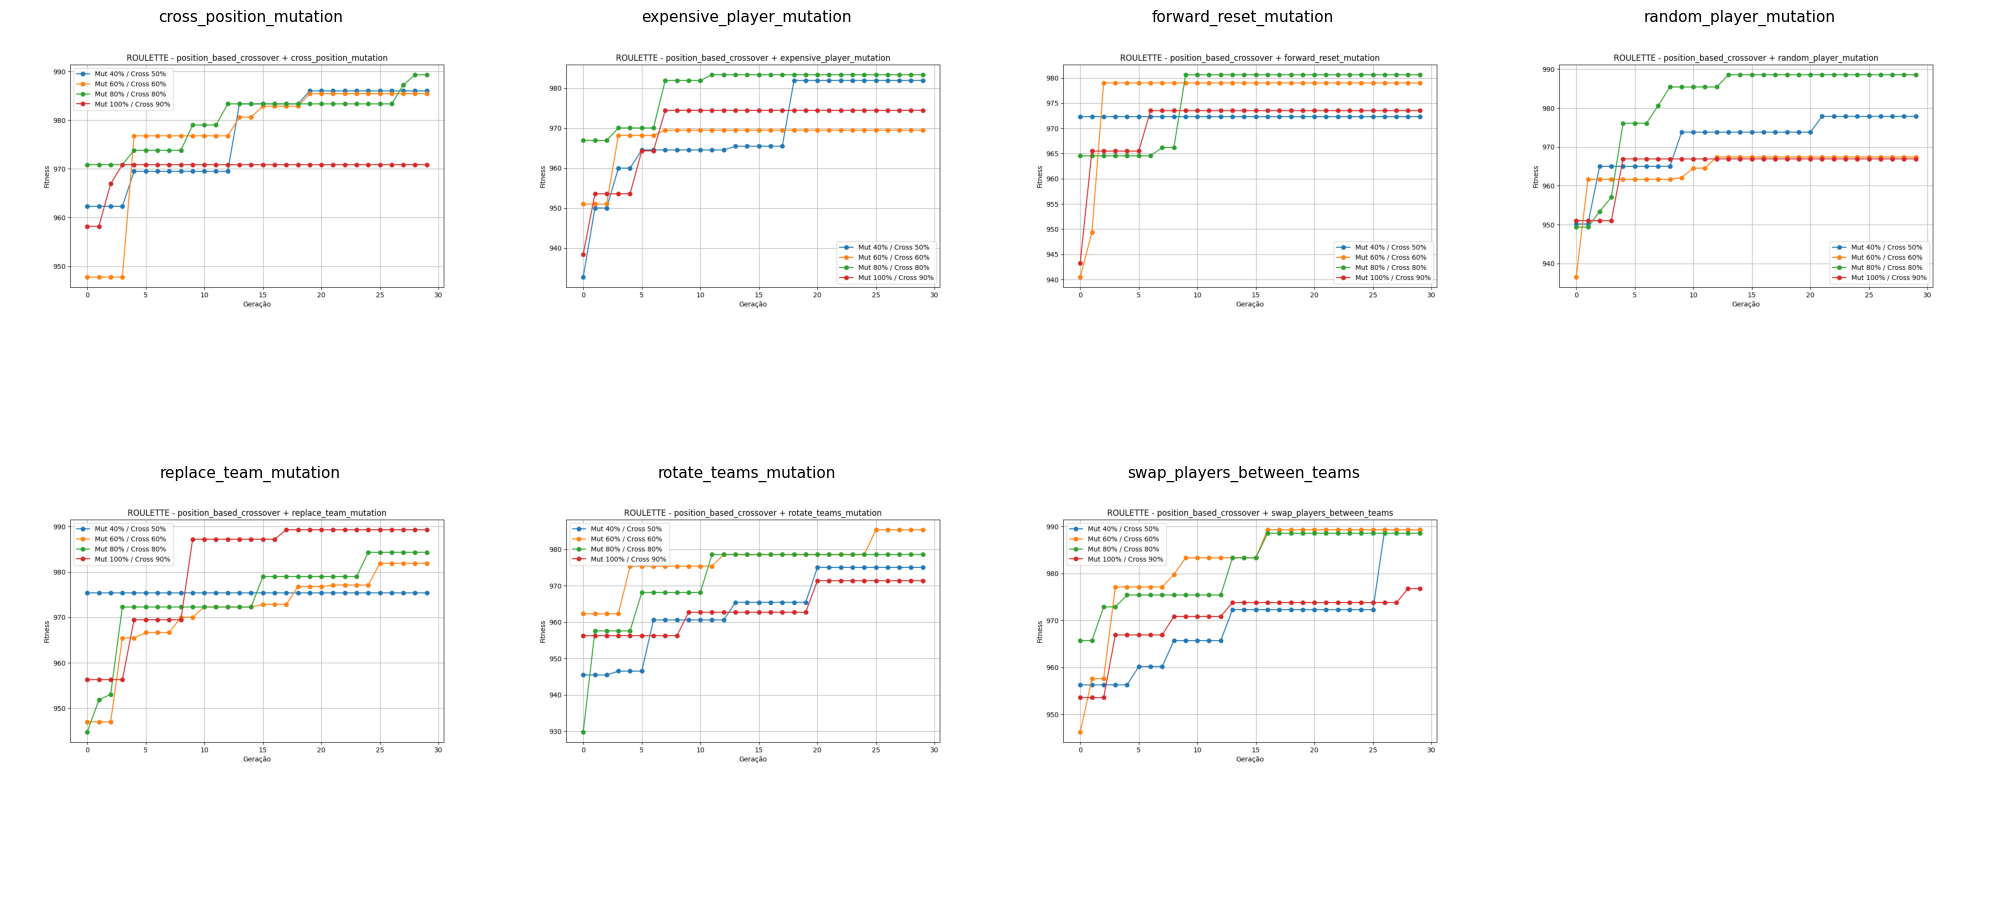

In [13]:
image_paths = [
    "../results/plots/roulette/position_based_crossover/cross_position_mutation/comparacao_taxas.png",
    "../results/plots/roulette/position_based_crossover/expensive_player_mutation/comparacao_taxas.png",
    "../results/plots/roulette/position_based_crossover/forward_reset_mutation/comparacao_taxas.png",
    "../results/plots/roulette/position_based_crossover/random_player_mutation/comparacao_taxas.png",
    "../results/plots/roulette/position_based_crossover/replace_team_mutation/comparacao_taxas.png",
    "../results/plots/roulette/position_based_crossover/rotate_teams_mutation/comparacao_taxas.png",
    "../results/plots/roulette/position_based_crossover/swap_players_between_teams/comparacao_taxas.png"
]

titles = [
    "cross_position_mutation",
    "expensive_player_mutation",
    "forward_reset_mutation",
    "random_player_mutation",
    "replace_team_mutation",
    "rotate_teams_mutation",
    "swap_players_between_teams"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (path, title) in enumerate(zip(image_paths, titles)):
    if os.path.exists(path):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=11)
    else:
        axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
        axes[i].axis('off')

if len(image_paths) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("../results/plots/roulette/figura_composta_7_graficos_position_based_crossover.png")
plt.show()

##### **Team Swap Crossover**

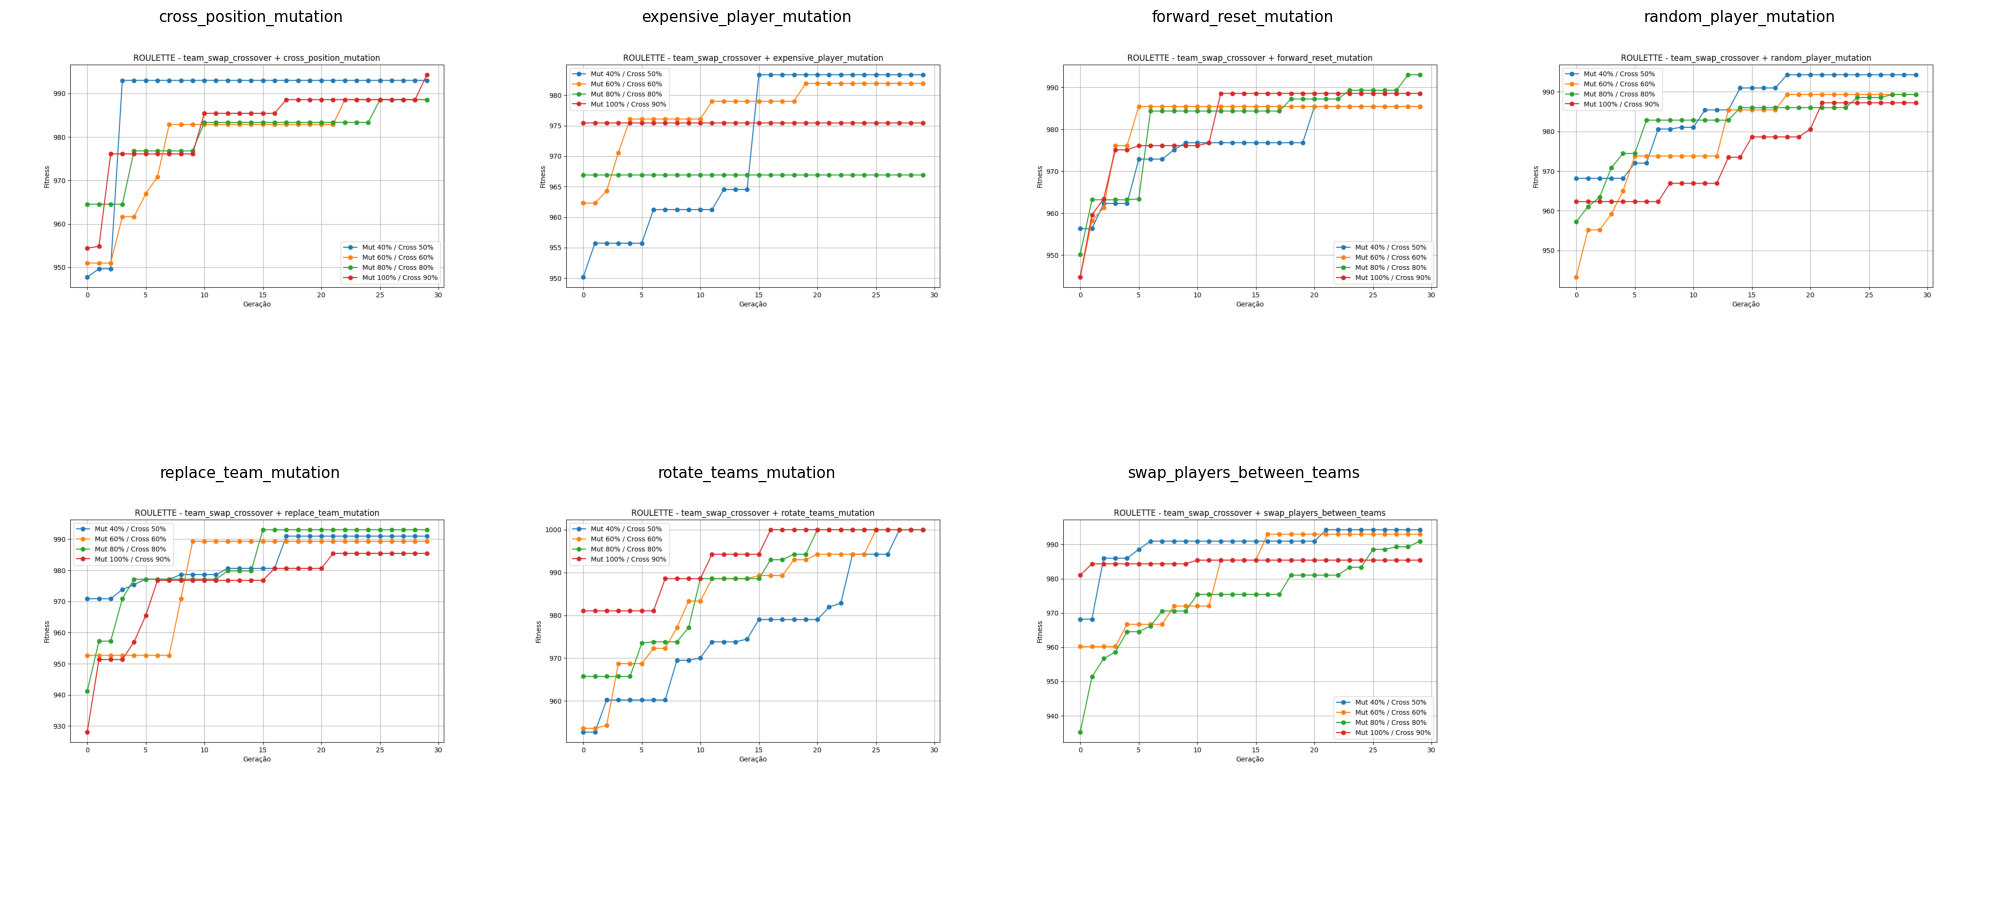

In [14]:
image_paths = [
    "../results/plots/roulette/team_swap_crossover/cross_position_mutation/comparacao_taxas.png",
    "../results/plots/roulette/team_swap_crossover/expensive_player_mutation/comparacao_taxas.png",
    "../results/plots/roulette/team_swap_crossover/forward_reset_mutation/comparacao_taxas.png",
    "../results/plots/roulette/team_swap_crossover/random_player_mutation/comparacao_taxas.png",
    "../results/plots/roulette/team_swap_crossover/replace_team_mutation/comparacao_taxas.png",
    "../results/plots/roulette/team_swap_crossover/rotate_teams_mutation/comparacao_taxas.png",
    "../results/plots/roulette/team_swap_crossover/swap_players_between_teams/comparacao_taxas.png"
]

titles = [
    "cross_position_mutation",
    "expensive_player_mutation",
    "forward_reset_mutation",
    "random_player_mutation",
    "replace_team_mutation",
    "rotate_teams_mutation",
    "swap_players_between_teams"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (path, title) in enumerate(zip(image_paths, titles)):
    if os.path.exists(path):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=11)
    else:
        axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
        axes[i].axis('off')

if len(image_paths) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("../results/plots/roulette/figura_composta_7_graficos_team_swap_crossover.png")
plt.show()

##### **Uniform Team Crossover**

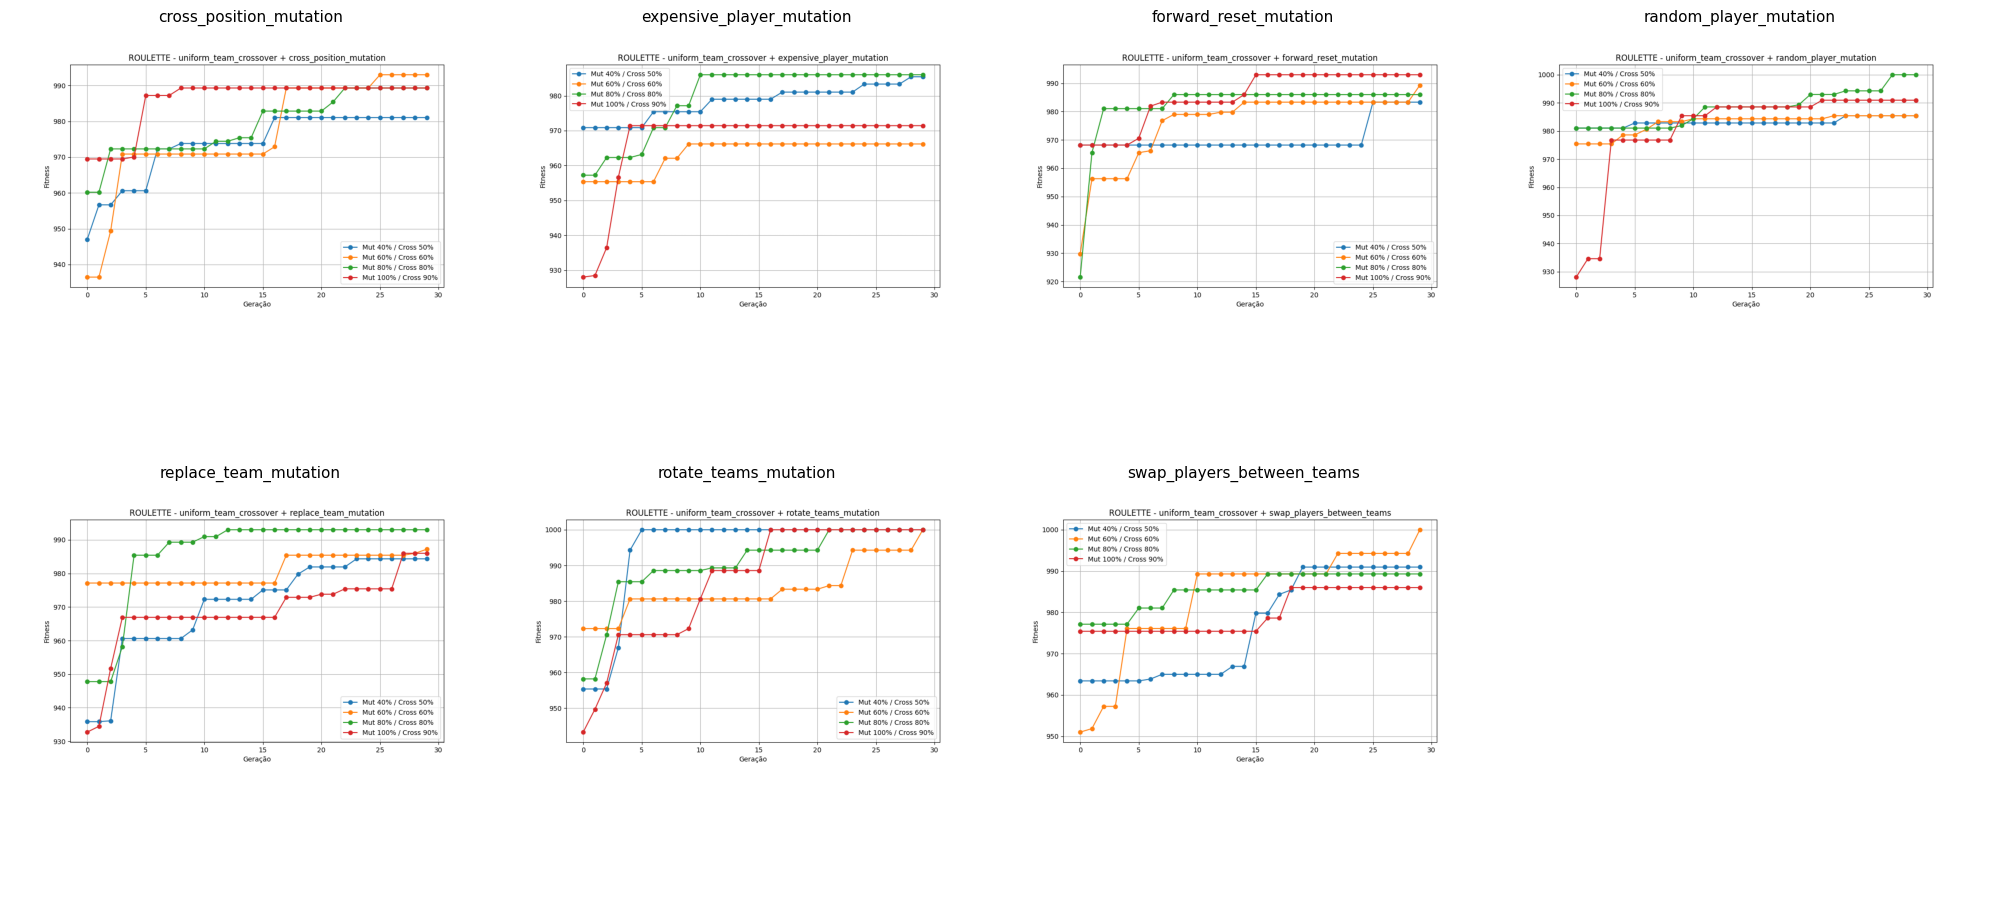

In [15]:
image_paths = [
    "../results/plots/roulette/uniform_team_crossover/cross_position_mutation/comparacao_taxas.png",
    "../results/plots/roulette/uniform_team_crossover/expensive_player_mutation/comparacao_taxas.png",
    "../results/plots/roulette/uniform_team_crossover/forward_reset_mutation/comparacao_taxas.png",
    "../results/plots/roulette/uniform_team_crossover/random_player_mutation/comparacao_taxas.png",
    "../results/plots/roulette/uniform_team_crossover/replace_team_mutation/comparacao_taxas.png",
    "../results/plots/roulette/uniform_team_crossover/rotate_teams_mutation/comparacao_taxas.png",
    "../results/plots/roulette/uniform_team_crossover/swap_players_between_teams/comparacao_taxas.png"
]

titles = [
    "cross_position_mutation",
    "expensive_player_mutation",
    "forward_reset_mutation",
    "random_player_mutation",
    "replace_team_mutation",
    "rotate_teams_mutation",
    "swap_players_between_teams"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (path, title) in enumerate(zip(image_paths, titles)):
    if os.path.exists(path):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=11)
    else:
        axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
        axes[i].axis('off')

if len(image_paths) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("../results/plots/roulette/figura_composta_7_graficos_uniform_team_crossover.png")
plt.show()

### Selection Method : **Truncation**

##### **Gene Level Crossover**

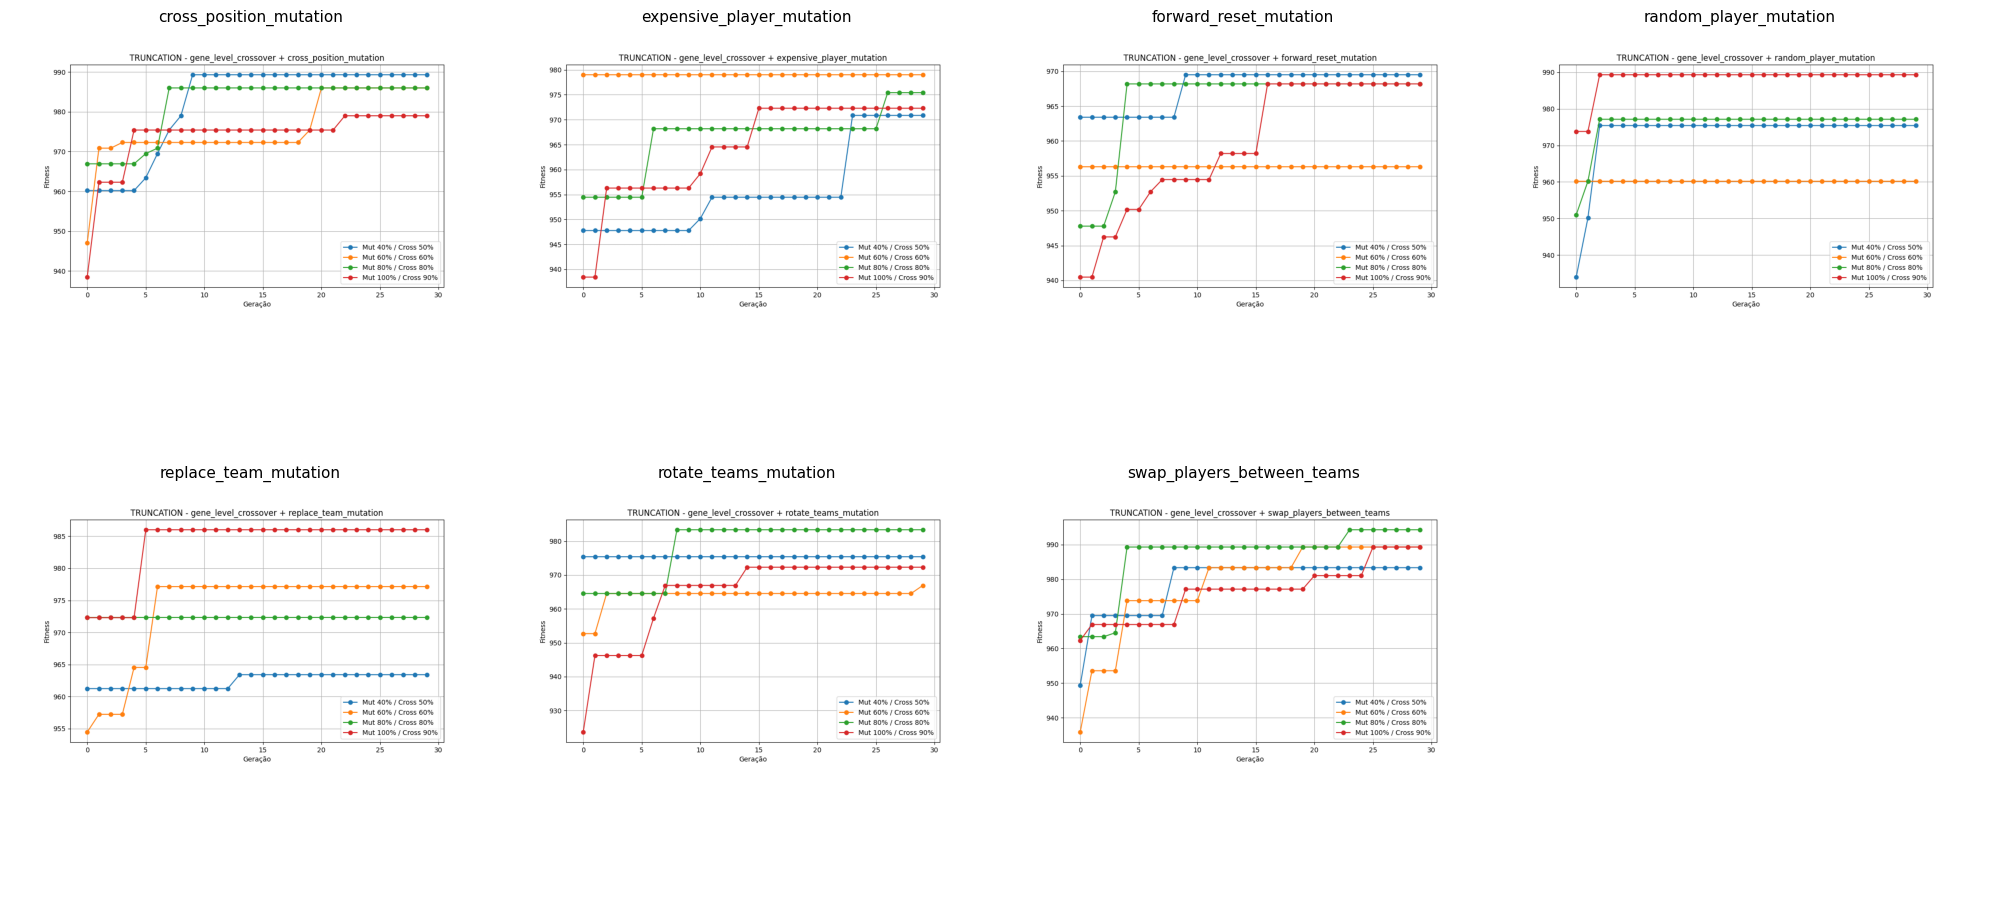

In [16]:
image_paths = [
    "../results/plots/truncation/gene_level_crossover/cross_position_mutation/comparacao_taxas.png",
    "../results/plots/truncation/gene_level_crossover/expensive_player_mutation/comparacao_taxas.png",
    "../results/plots/truncation/gene_level_crossover/forward_reset_mutation/comparacao_taxas.png",
    "../results/plots/truncation/gene_level_crossover/random_player_mutation/comparacao_taxas.png",
    "../results/plots/truncation/gene_level_crossover/replace_team_mutation/comparacao_taxas.png",
    "../results/plots/truncation/gene_level_crossover/rotate_teams_mutation/comparacao_taxas.png",
    "../results/plots/truncation/gene_level_crossover/swap_players_between_teams/comparacao_taxas.png"
]

titles = [
    "cross_position_mutation",
    "expensive_player_mutation",
    "forward_reset_mutation",
    "random_player_mutation",
    "replace_team_mutation",
    "rotate_teams_mutation",
    "swap_players_between_teams"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (path, title) in enumerate(zip(image_paths, titles)):
    if os.path.exists(path):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=11)
    else:
        axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
        axes[i].axis('off')

if len(image_paths) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("../results/plots/truncation/figura_composta_7_graficos_gene_level_crossover.png")
plt.show()

##### **Player Swap Crossover**

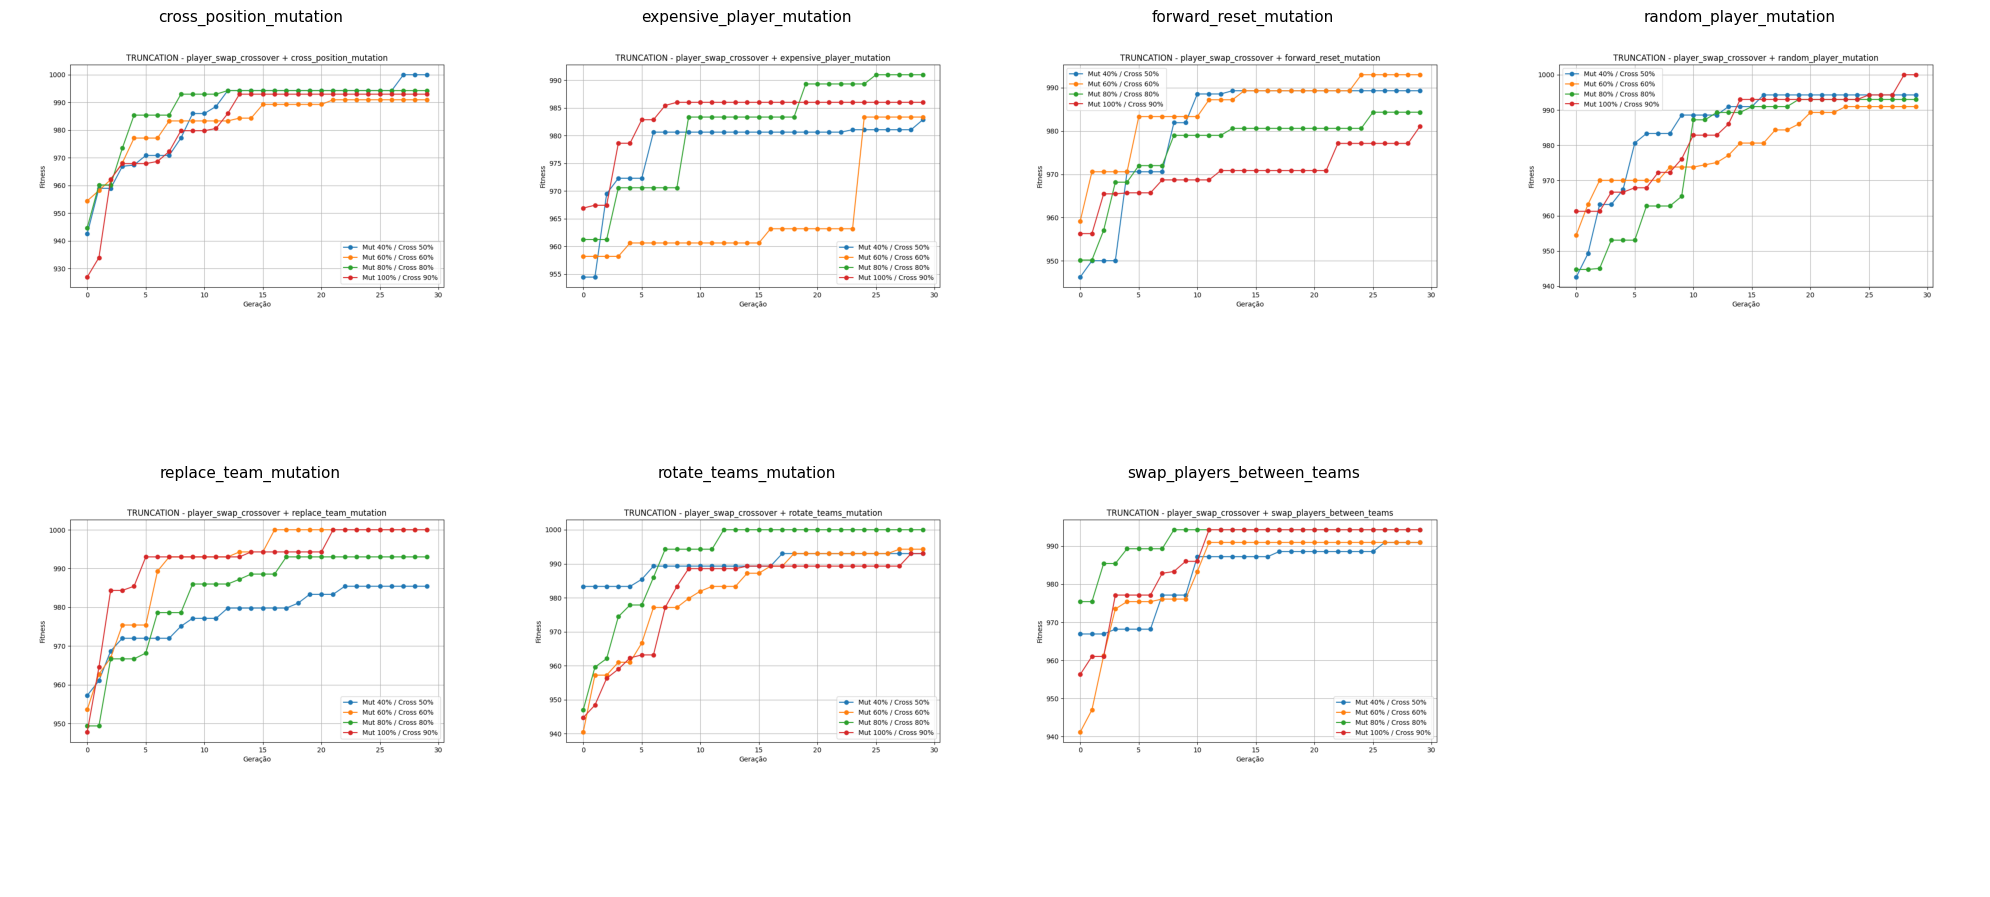

In [17]:
image_paths = [
    "../results/plots/truncation/player_swap_crossover/cross_position_mutation/comparacao_taxas.png",
    "../results/plots/truncation/player_swap_crossover/expensive_player_mutation/comparacao_taxas.png",
    "../results/plots/truncation/player_swap_crossover/forward_reset_mutation/comparacao_taxas.png",
    "../results/plots/truncation/player_swap_crossover/random_player_mutation/comparacao_taxas.png",
    "../results/plots/truncation/player_swap_crossover/replace_team_mutation/comparacao_taxas.png",
    "../results/plots/truncation/player_swap_crossover/rotate_teams_mutation/comparacao_taxas.png",
    "../results/plots/truncation/player_swap_crossover/swap_players_between_teams/comparacao_taxas.png"
]

titles = [
    "cross_position_mutation",
    "expensive_player_mutation",
    "forward_reset_mutation",
    "random_player_mutation",
    "replace_team_mutation",
    "rotate_teams_mutation",
    "swap_players_between_teams"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (path, title) in enumerate(zip(image_paths, titles)):
    if os.path.exists(path):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=11)
    else:
        axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
        axes[i].axis('off')

if len(image_paths) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("../results/plots/truncation/figura_composta_7_graficos_player_swap_crossover.png")
plt.show()

##### **Position Based Crossover**

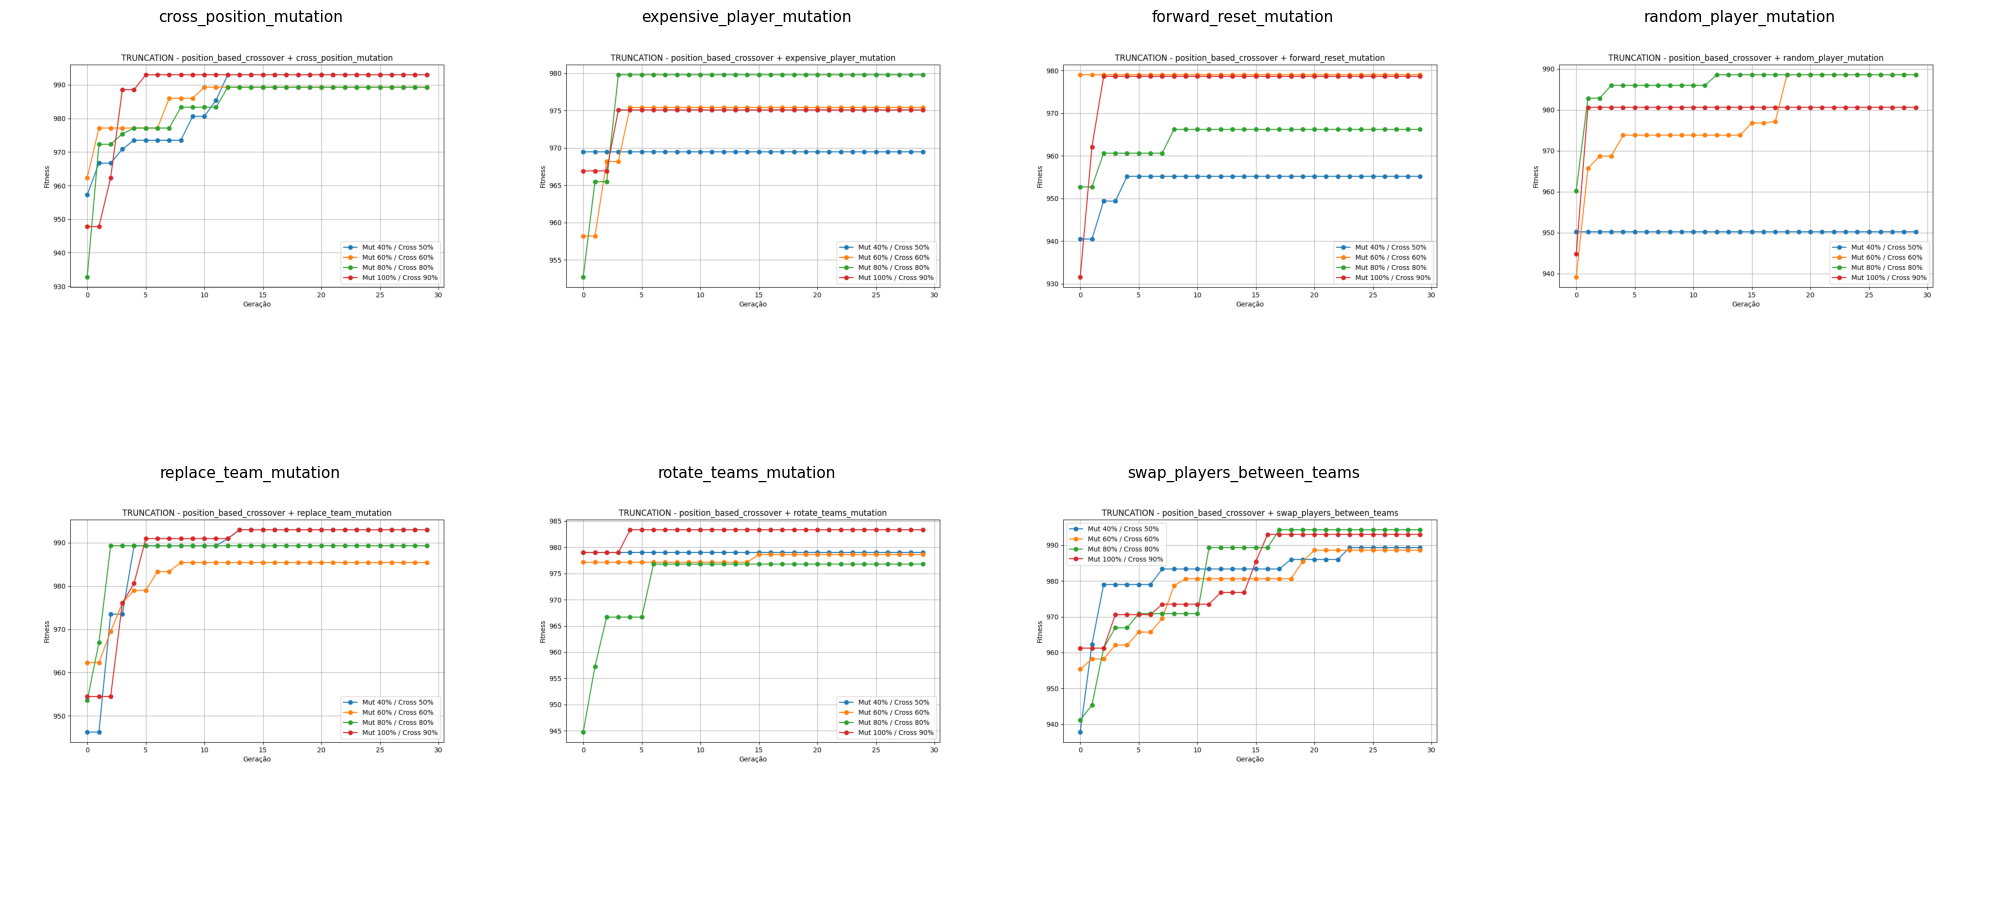

In [18]:
image_paths = [
    "../results/plots/truncation/position_based_crossover/cross_position_mutation/comparacao_taxas.png",
    "../results/plots/truncation/position_based_crossover/expensive_player_mutation/comparacao_taxas.png",
    "../results/plots/truncation/position_based_crossover/forward_reset_mutation/comparacao_taxas.png",
    "../results/plots/truncation/position_based_crossover/random_player_mutation/comparacao_taxas.png",
    "../results/plots/truncation/position_based_crossover/replace_team_mutation/comparacao_taxas.png",
    "../results/plots/truncation/position_based_crossover/rotate_teams_mutation/comparacao_taxas.png",
    "../results/plots/truncation/position_based_crossover/swap_players_between_teams/comparacao_taxas.png"
]

titles = [
    "cross_position_mutation",
    "expensive_player_mutation",
    "forward_reset_mutation",
    "random_player_mutation",
    "replace_team_mutation",
    "rotate_teams_mutation",
    "swap_players_between_teams"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (path, title) in enumerate(zip(image_paths, titles)):
    if os.path.exists(path):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=11)
    else:
        axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
        axes[i].axis('off')

if len(image_paths) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("../results/plots/truncation/figura_composta_7_graficos_position_based_crossover.png")
plt.show()

##### **Team Swap Crossover**

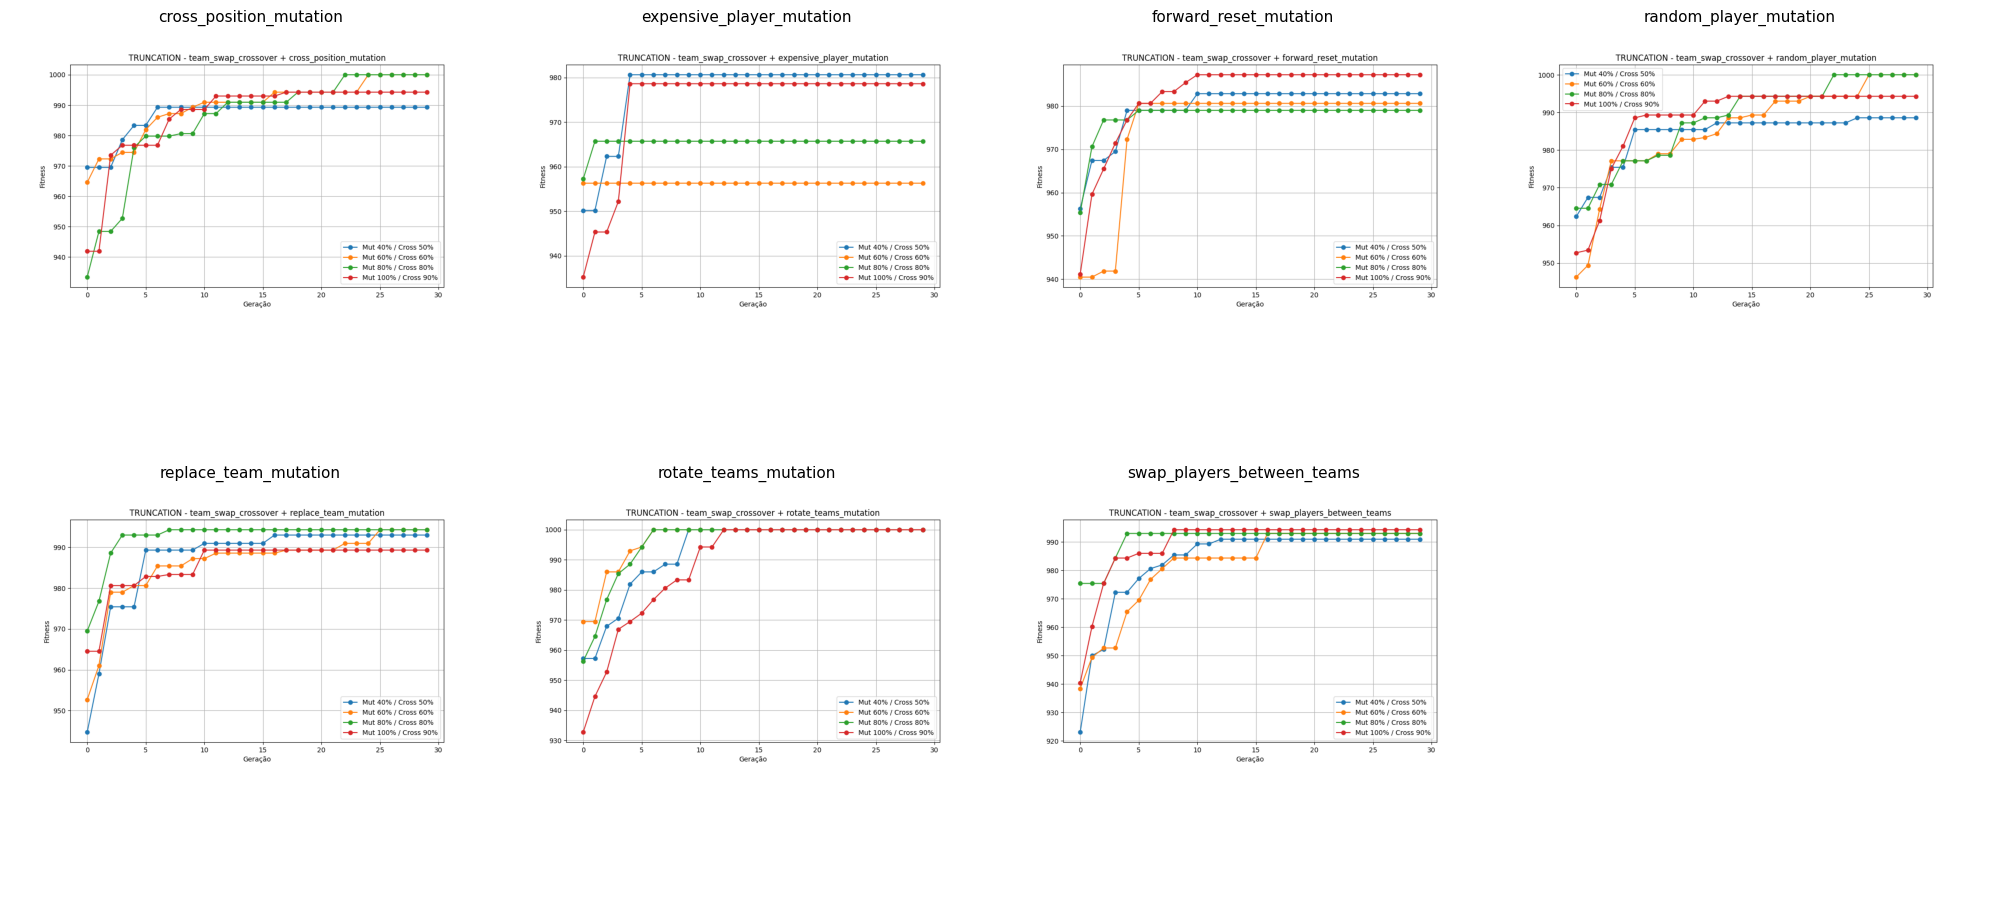

In [19]:
image_paths = [
    "../results/plots/truncation/team_swap_crossover/cross_position_mutation/comparacao_taxas.png",
    "../results/plots/truncation/team_swap_crossover/expensive_player_mutation/comparacao_taxas.png",
    "../results/plots/truncation/team_swap_crossover/forward_reset_mutation/comparacao_taxas.png",
    "../results/plots/truncation/team_swap_crossover/random_player_mutation/comparacao_taxas.png",
    "../results/plots/truncation/team_swap_crossover/replace_team_mutation/comparacao_taxas.png",
    "../results/plots/truncation/team_swap_crossover/rotate_teams_mutation/comparacao_taxas.png",
    "../results/plots/truncation/team_swap_crossover/swap_players_between_teams/comparacao_taxas.png"
]

titles = [
    "cross_position_mutation",
    "expensive_player_mutation",
    "forward_reset_mutation",
    "random_player_mutation",
    "replace_team_mutation",
    "rotate_teams_mutation",
    "swap_players_between_teams"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (path, title) in enumerate(zip(image_paths, titles)):
    if os.path.exists(path):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=11)
    else:
        axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
        axes[i].axis('off')

if len(image_paths) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("../results/plots/truncation/figura_composta_7_graficos_team_swap_crossover.png")
plt.show()

##### **Uniform Team Crossover**

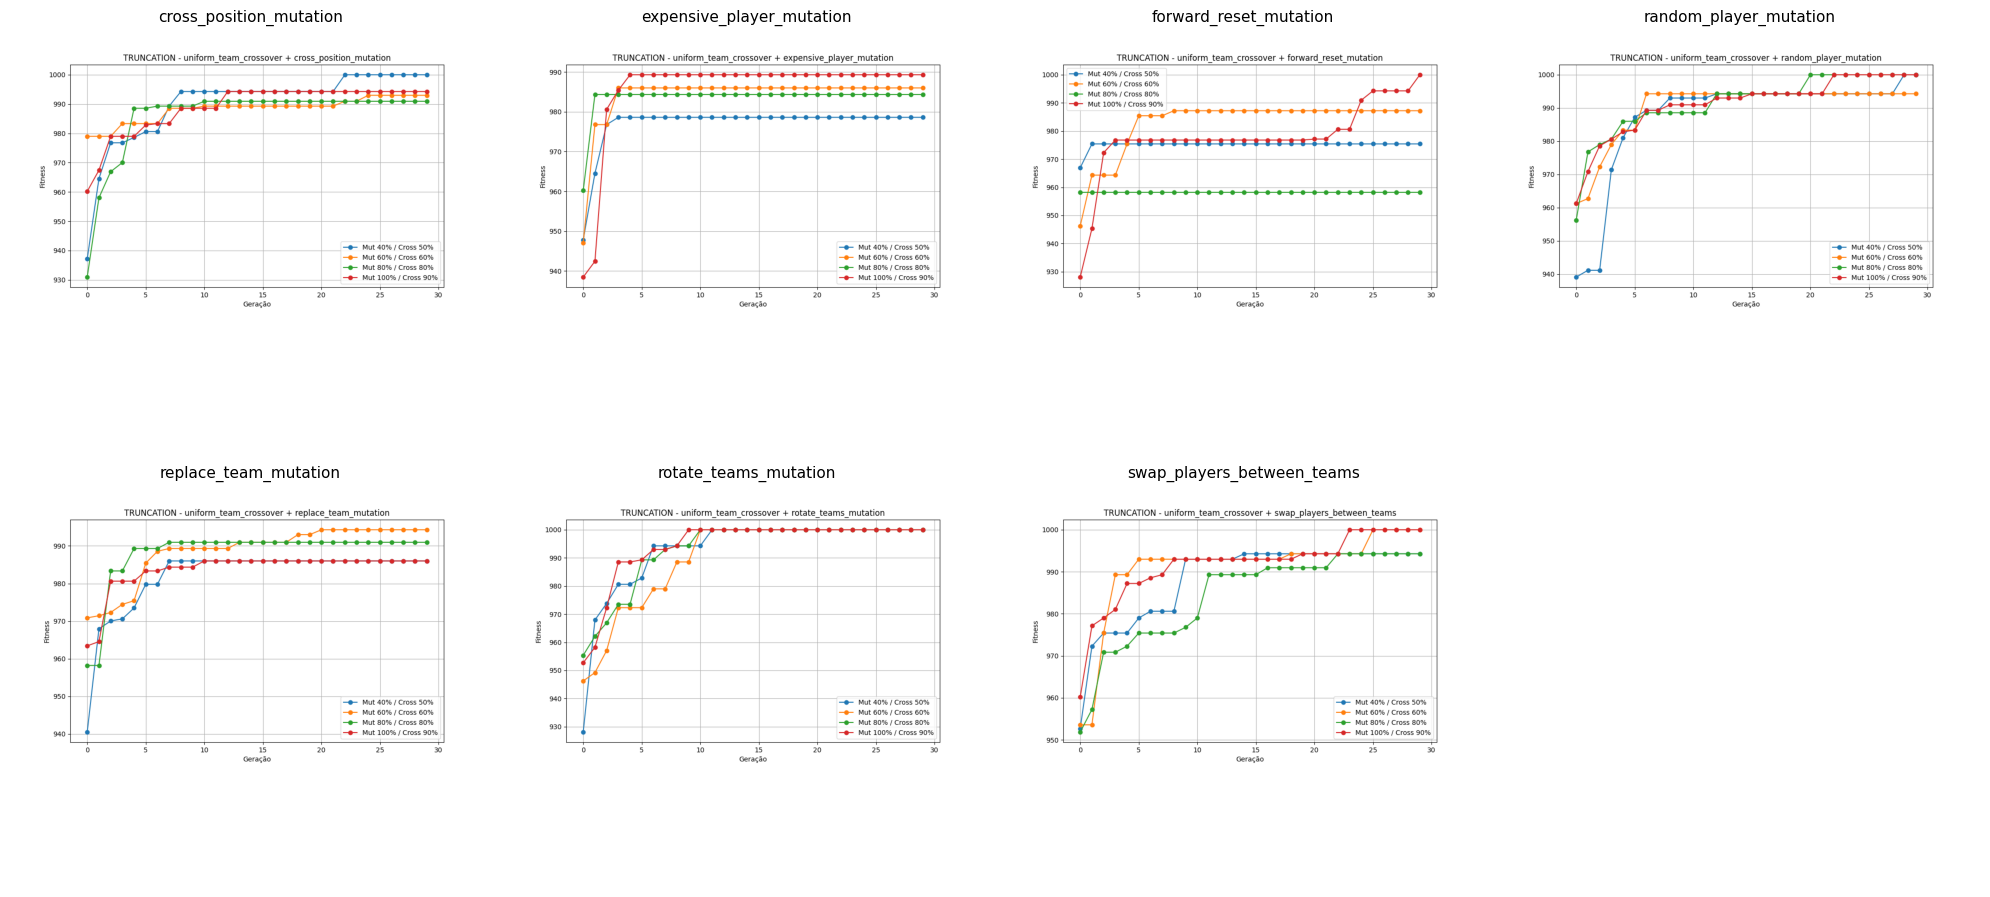

In [20]:
image_paths = [
    "../results/plots/truncation/uniform_team_crossover/cross_position_mutation/comparacao_taxas.png",
    "../results/plots/truncation/uniform_team_crossover/expensive_player_mutation/comparacao_taxas.png",
    "../results/plots/truncation/uniform_team_crossover/forward_reset_mutation/comparacao_taxas.png",
    "../results/plots/truncation/uniform_team_crossover/random_player_mutation/comparacao_taxas.png",
    "../results/plots/truncation/uniform_team_crossover/replace_team_mutation/comparacao_taxas.png",
    "../results/plots/truncation/uniform_team_crossover/rotate_teams_mutation/comparacao_taxas.png",
    "../results/plots/truncation/uniform_team_crossover/swap_players_between_teams/comparacao_taxas.png"
]

titles = [
    "cross_position_mutation",
    "expensive_player_mutation",
    "forward_reset_mutation",
    "random_player_mutation",
    "replace_team_mutation",
    "rotate_teams_mutation",
    "swap_players_between_teams"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (path, title) in enumerate(zip(image_paths, titles)):
    if os.path.exists(path):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=11)
    else:
        axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
        axes[i].axis('off')

if len(image_paths) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("../results/plots/truncation/figura_composta_7_graficos_uniform_team_crossover.png")
plt.show()

### Selection Method : **Rank**

##### **Gene Level Crossover**

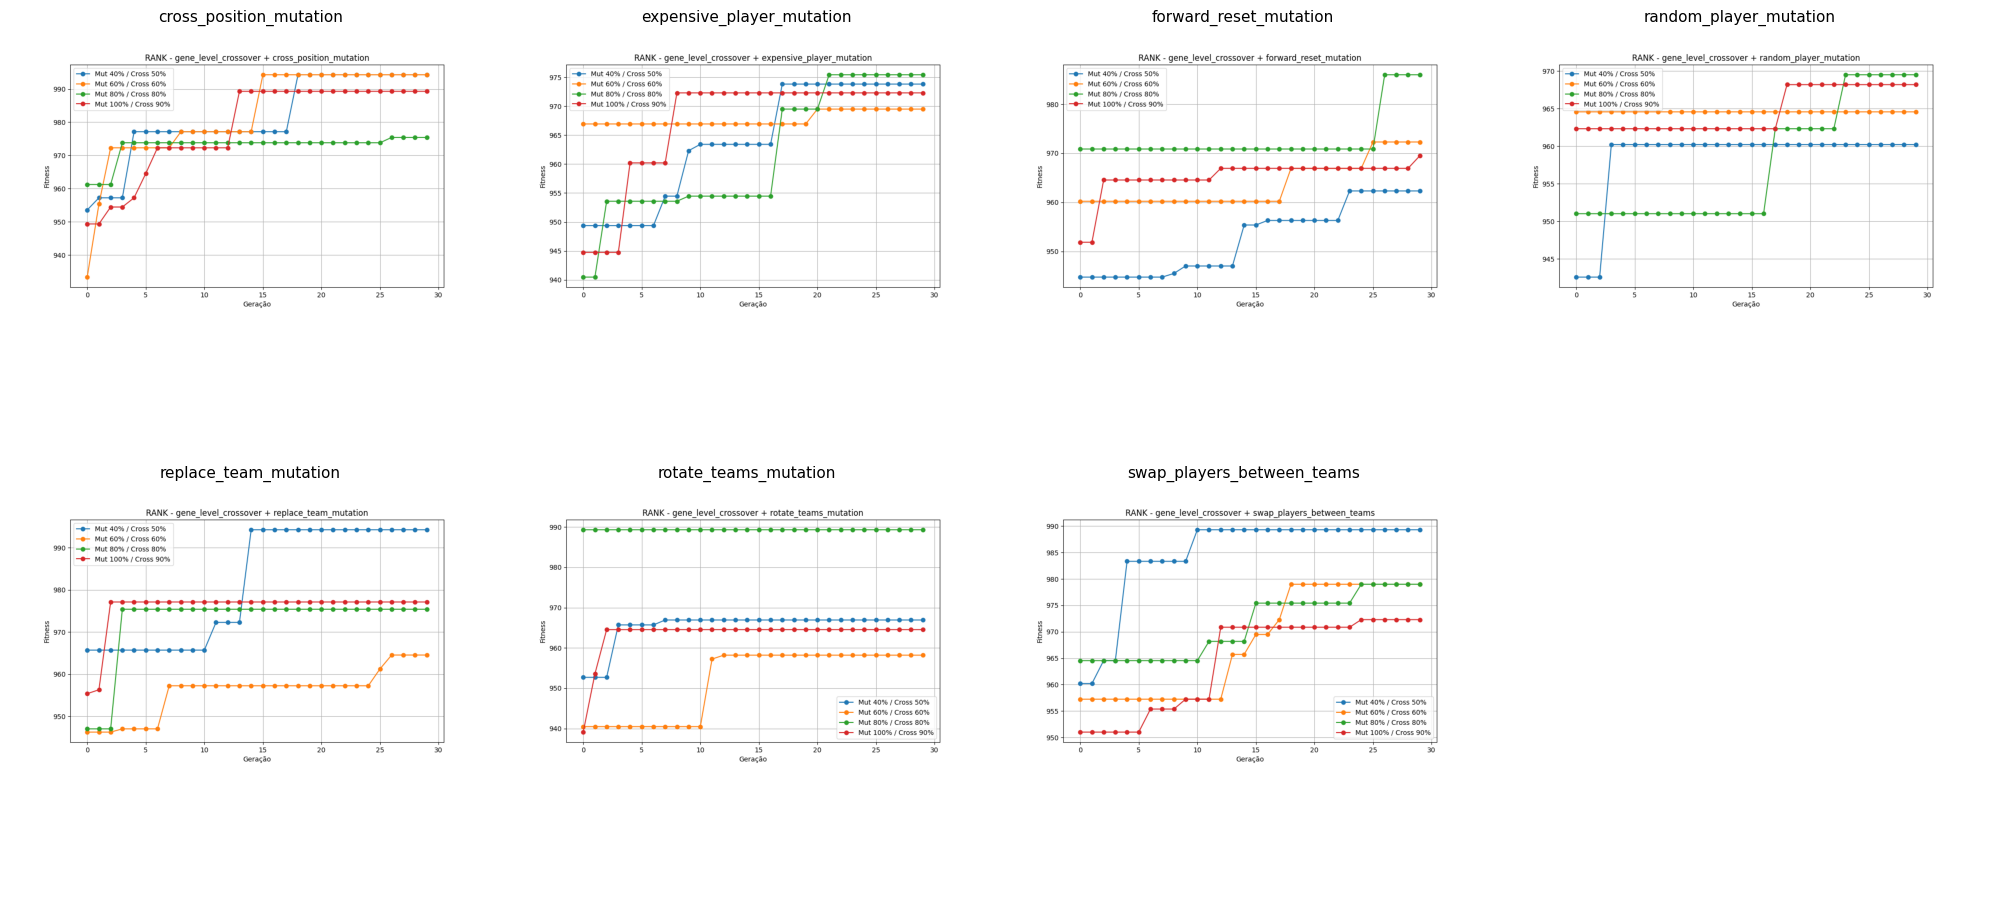

In [21]:
image_paths = [
    "../results/plots/rank/gene_level_crossover/cross_position_mutation/comparacao_taxas.png",
    "../results/plots/rank/gene_level_crossover/expensive_player_mutation/comparacao_taxas.png",
    "../results/plots/rank/gene_level_crossover/forward_reset_mutation/comparacao_taxas.png",
    "../results/plots/rank/gene_level_crossover/random_player_mutation/comparacao_taxas.png",
    "../results/plots/rank/gene_level_crossover/replace_team_mutation/comparacao_taxas.png",
    "../results/plots/rank/gene_level_crossover/rotate_teams_mutation/comparacao_taxas.png",
    "../results/plots/rank/gene_level_crossover/swap_players_between_teams/comparacao_taxas.png"
]

titles = [
    "cross_position_mutation",
    "expensive_player_mutation",
    "forward_reset_mutation",
    "random_player_mutation",
    "replace_team_mutation",
    "rotate_teams_mutation",
    "swap_players_between_teams"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (path, title) in enumerate(zip(image_paths, titles)):
    if os.path.exists(path):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=11)
    else:
        axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
        axes[i].axis('off')

if len(image_paths) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("../results/plots/rank/figura_composta_7_graficos_gene_level_crossover.png")
plt.show()

##### **Player Swap Crossover**

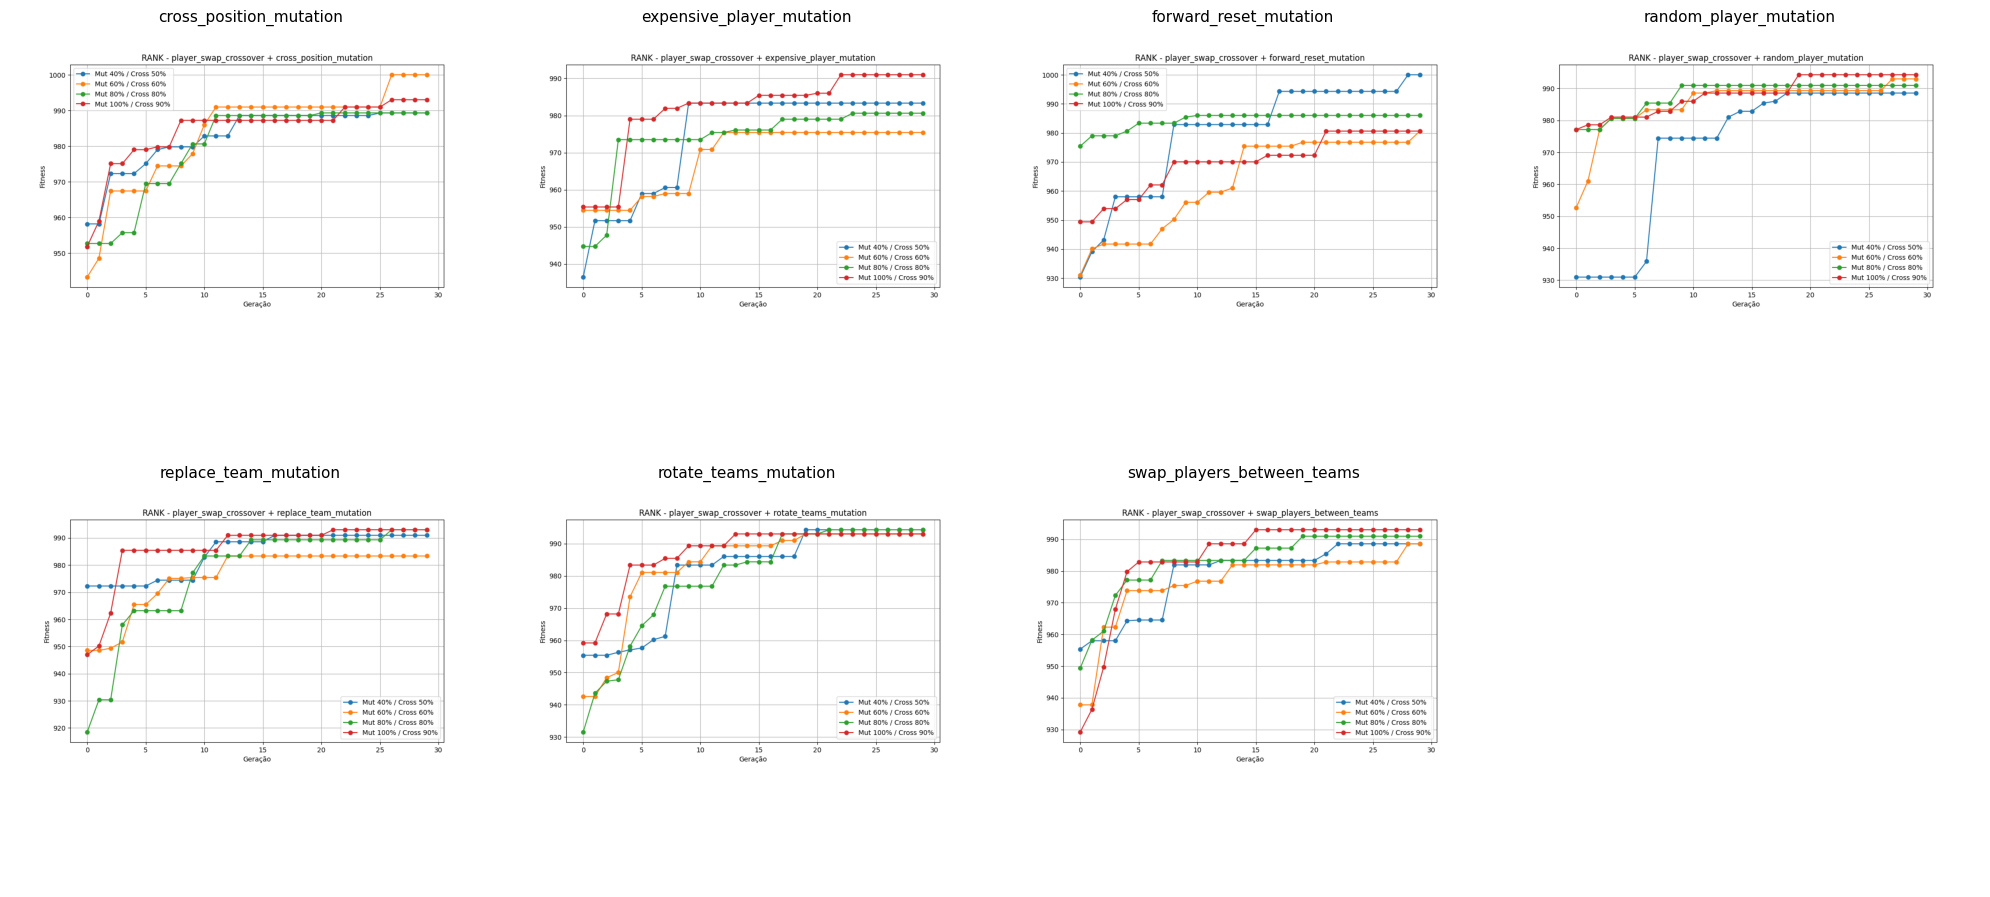

In [22]:
image_paths = [
    "../results/plots/rank/player_swap_crossover/cross_position_mutation/comparacao_taxas.png",
    "../results/plots/rank/player_swap_crossover/expensive_player_mutation/comparacao_taxas.png",
    "../results/plots/rank/player_swap_crossover/forward_reset_mutation/comparacao_taxas.png",
    "../results/plots/rank/player_swap_crossover/random_player_mutation/comparacao_taxas.png",
    "../results/plots/rank/player_swap_crossover/replace_team_mutation/comparacao_taxas.png",
    "../results/plots/rank/player_swap_crossover/rotate_teams_mutation/comparacao_taxas.png",
    "../results/plots/rank/player_swap_crossover/swap_players_between_teams/comparacao_taxas.png"
]

titles = [
    "cross_position_mutation",
    "expensive_player_mutation",
    "forward_reset_mutation",
    "random_player_mutation",
    "replace_team_mutation",
    "rotate_teams_mutation",
    "swap_players_between_teams"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (path, title) in enumerate(zip(image_paths, titles)):
    if os.path.exists(path):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=11)
    else:
        axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
        axes[i].axis('off')

if len(image_paths) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("../results/plots/rank/figura_composta_7_graficos_player_swap_crossover.png")
plt.show()

##### **Position Based Crossover**

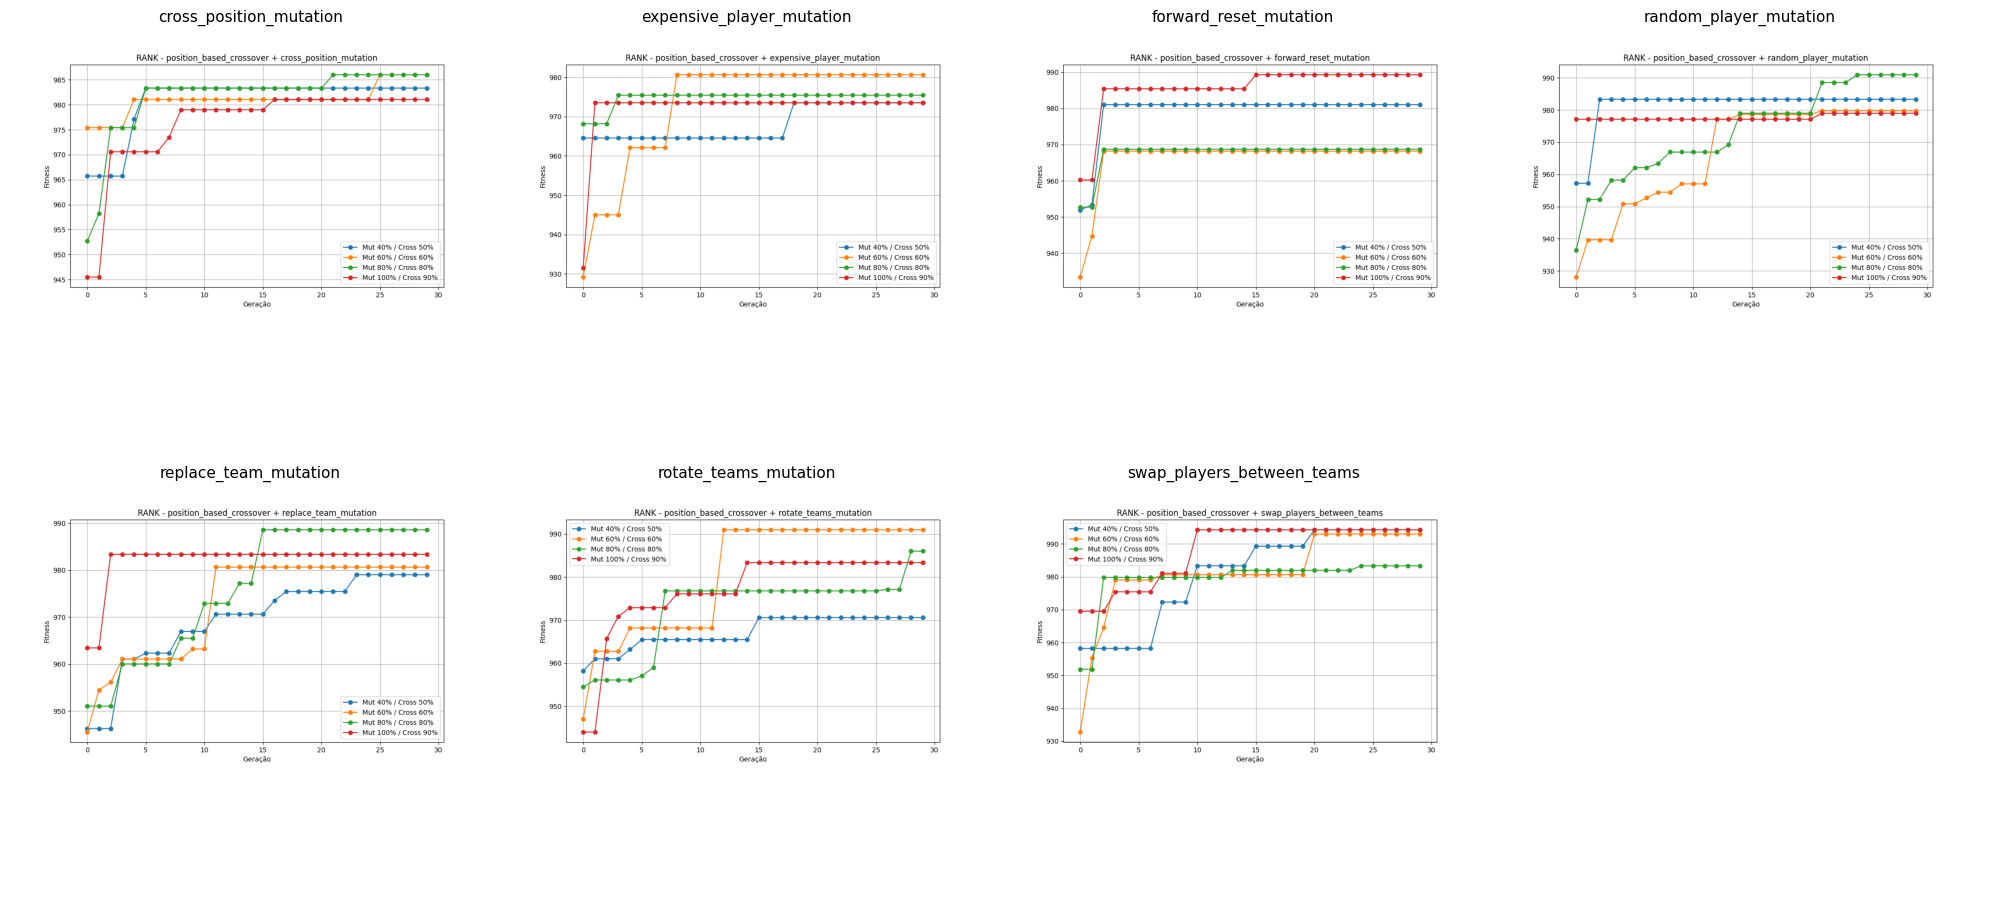

In [23]:
image_paths = [
    "../results/plots/rank/position_based_crossover/cross_position_mutation/comparacao_taxas.png",
    "../results/plots/rank/position_based_crossover/expensive_player_mutation/comparacao_taxas.png",
    "../results/plots/rank/position_based_crossover/forward_reset_mutation/comparacao_taxas.png",
    "../results/plots/rank/position_based_crossover/random_player_mutation/comparacao_taxas.png",
    "../results/plots/rank/position_based_crossover/replace_team_mutation/comparacao_taxas.png",
    "../results/plots/rank/position_based_crossover/rotate_teams_mutation/comparacao_taxas.png",
    "../results/plots/rank/position_based_crossover/swap_players_between_teams/comparacao_taxas.png"
]

titles = [
    "cross_position_mutation",
    "expensive_player_mutation",
    "forward_reset_mutation",
    "random_player_mutation",
    "replace_team_mutation",
    "rotate_teams_mutation",
    "swap_players_between_teams"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (path, title) in enumerate(zip(image_paths, titles)):
    if os.path.exists(path):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=11)
    else:
        axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
        axes[i].axis('off')

if len(image_paths) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("../results/plots/rank/figura_composta_7_graficos_position_based_crossover.png")
plt.show()

##### **Team Swap Crossover**

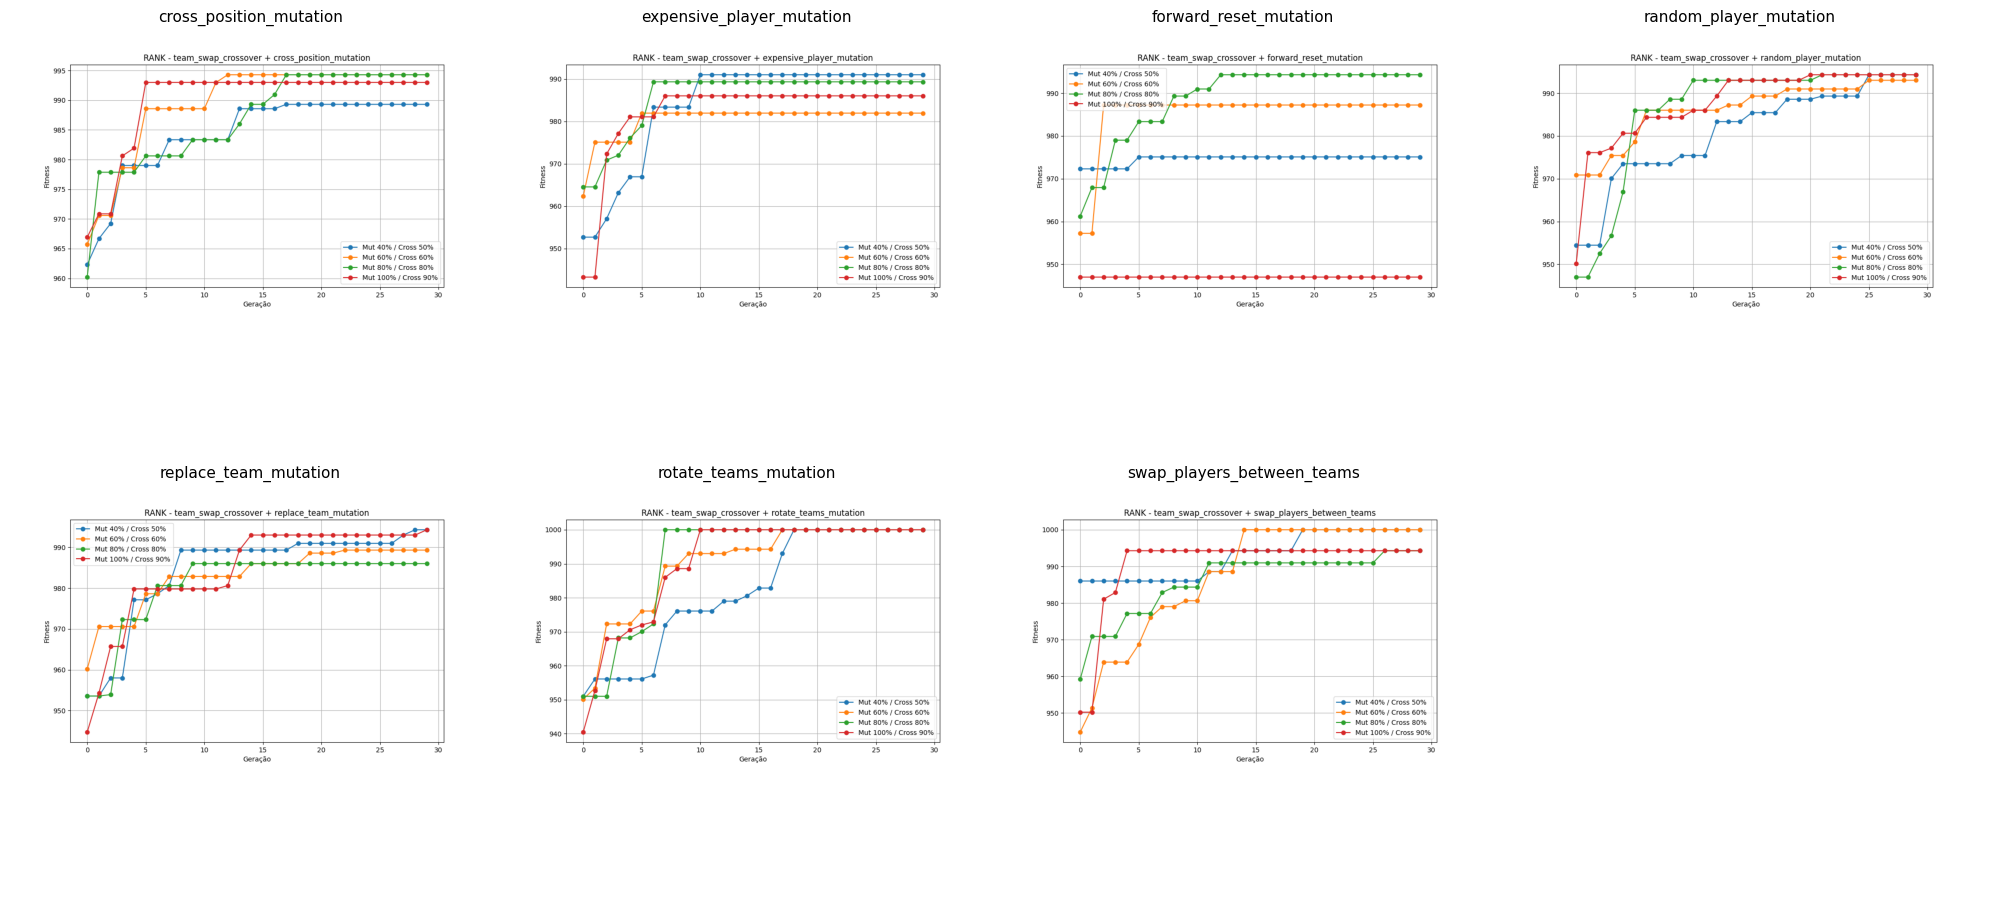

In [24]:
image_paths = [
    "../results/plots/rank/team_swap_crossover/cross_position_mutation/comparacao_taxas.png",
    "../results/plots/rank/team_swap_crossover/expensive_player_mutation/comparacao_taxas.png",
    "../results/plots/rank/team_swap_crossover/forward_reset_mutation/comparacao_taxas.png",
    "../results/plots/rank/team_swap_crossover/random_player_mutation/comparacao_taxas.png",
    "../results/plots/rank/team_swap_crossover/replace_team_mutation/comparacao_taxas.png",
    "../results/plots/rank/team_swap_crossover/rotate_teams_mutation/comparacao_taxas.png",
    "../results/plots/rank/team_swap_crossover/swap_players_between_teams/comparacao_taxas.png"
]

titles = [
    "cross_position_mutation",
    "expensive_player_mutation",
    "forward_reset_mutation",
    "random_player_mutation",
    "replace_team_mutation",
    "rotate_teams_mutation",
    "swap_players_between_teams"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (path, title) in enumerate(zip(image_paths, titles)):
    if os.path.exists(path):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=11)
    else:
        axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
        axes[i].axis('off')

if len(image_paths) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("../results/plots/rank/figura_composta_7_graficos_team_swap_crossover.png")
plt.show()

##### **Uniform Team Crossover**

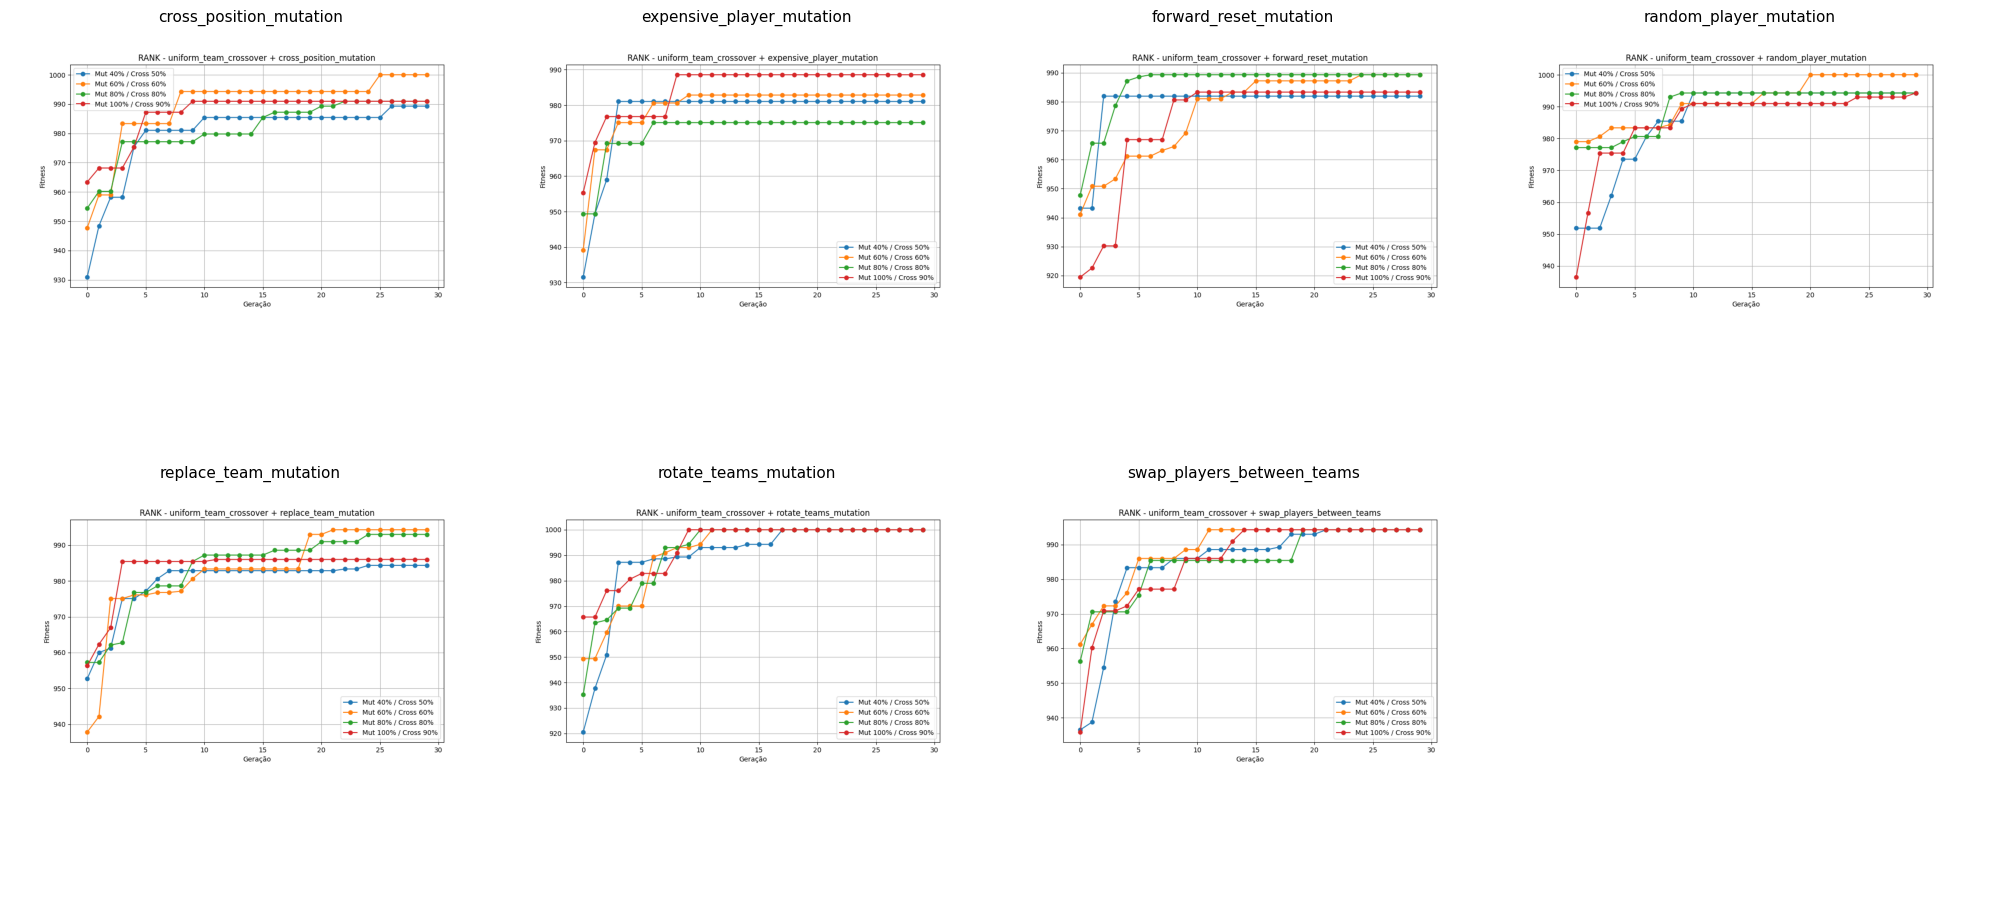

In [25]:
image_paths = [
    "../results/plots/rank/uniform_team_crossover/cross_position_mutation/comparacao_taxas.png",
    "../results/plots/rank/uniform_team_crossover/expensive_player_mutation/comparacao_taxas.png",
    "../results/plots/rank/uniform_team_crossover/forward_reset_mutation/comparacao_taxas.png",
    "../results/plots/rank/uniform_team_crossover/random_player_mutation/comparacao_taxas.png",
    "../results/plots/rank/uniform_team_crossover/replace_team_mutation/comparacao_taxas.png",
    "../results/plots/rank/uniform_team_crossover/rotate_teams_mutation/comparacao_taxas.png",
    "../results/plots/rank/uniform_team_crossover/swap_players_between_teams/comparacao_taxas.png"
]

titles = [
    "cross_position_mutation",
    "expensive_player_mutation",
    "forward_reset_mutation",
    "random_player_mutation",
    "replace_team_mutation",
    "rotate_teams_mutation",
    "swap_players_between_teams"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (path, title) in enumerate(zip(image_paths, titles)):
    if os.path.exists(path):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=11)
    else:
        axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
        axes[i].axis('off')

if len(image_paths) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("../results/plots/rank/figura_composta_7_graficos_uniform_team_crossover.png")
plt.show()

### Selection Method : **Stohastic Universal Sampling**

##### **Gene Level Crossover**

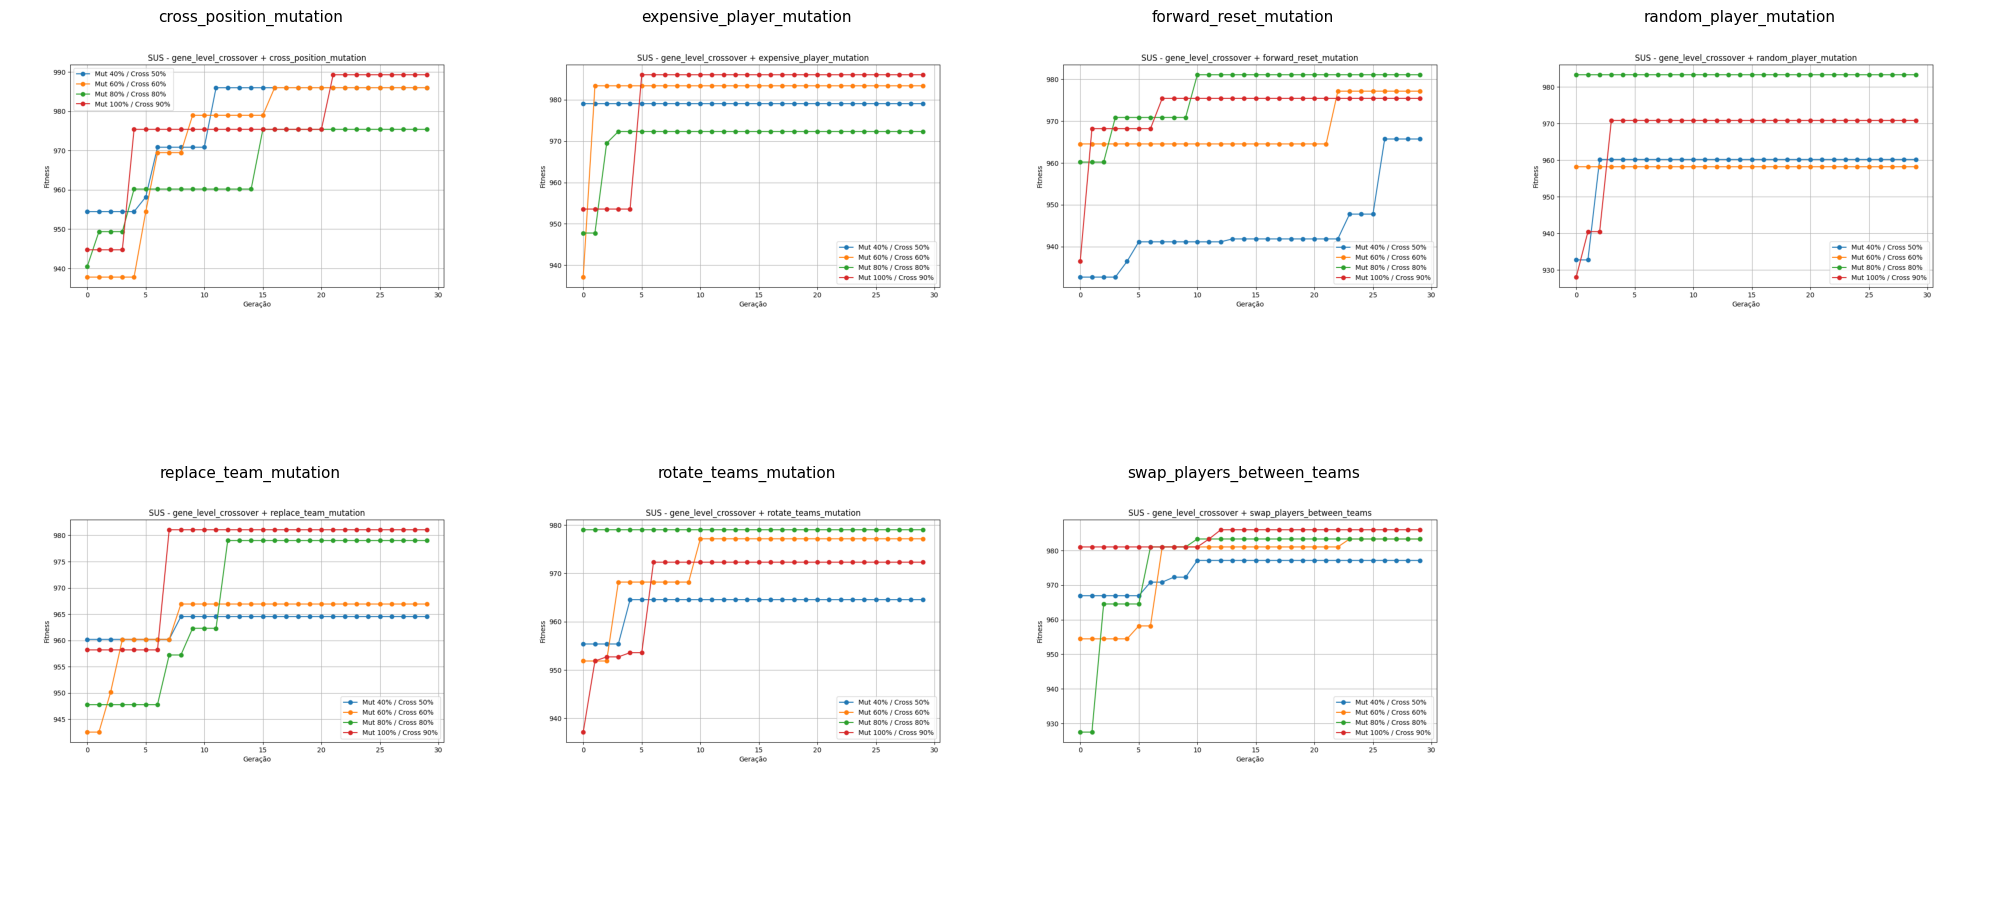

In [26]:
image_paths = [
    "../results/plots/sus/gene_level_crossover/cross_position_mutation/comparacao_taxas.png",
    "../results/plots/sus/gene_level_crossover/expensive_player_mutation/comparacao_taxas.png",
    "../results/plots/sus/gene_level_crossover/forward_reset_mutation/comparacao_taxas.png",
    "../results/plots/sus/gene_level_crossover/random_player_mutation/comparacao_taxas.png",
    "../results/plots/sus/gene_level_crossover/replace_team_mutation/comparacao_taxas.png",
    "../results/plots/sus/gene_level_crossover/rotate_teams_mutation/comparacao_taxas.png",
    "../results/plots/sus/gene_level_crossover/swap_players_between_teams/comparacao_taxas.png"
]

titles = [
    "cross_position_mutation",
    "expensive_player_mutation",
    "forward_reset_mutation",
    "random_player_mutation",
    "replace_team_mutation",
    "rotate_teams_mutation",
    "swap_players_between_teams"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (path, title) in enumerate(zip(image_paths, titles)):
    if os.path.exists(path):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=11)
    else:
        axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
        axes[i].axis('off')

if len(image_paths) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("../results/plots/sus/figura_composta_7_graficos_gene_level_crossover.png")
plt.show()

##### **Player Swap Crossover**

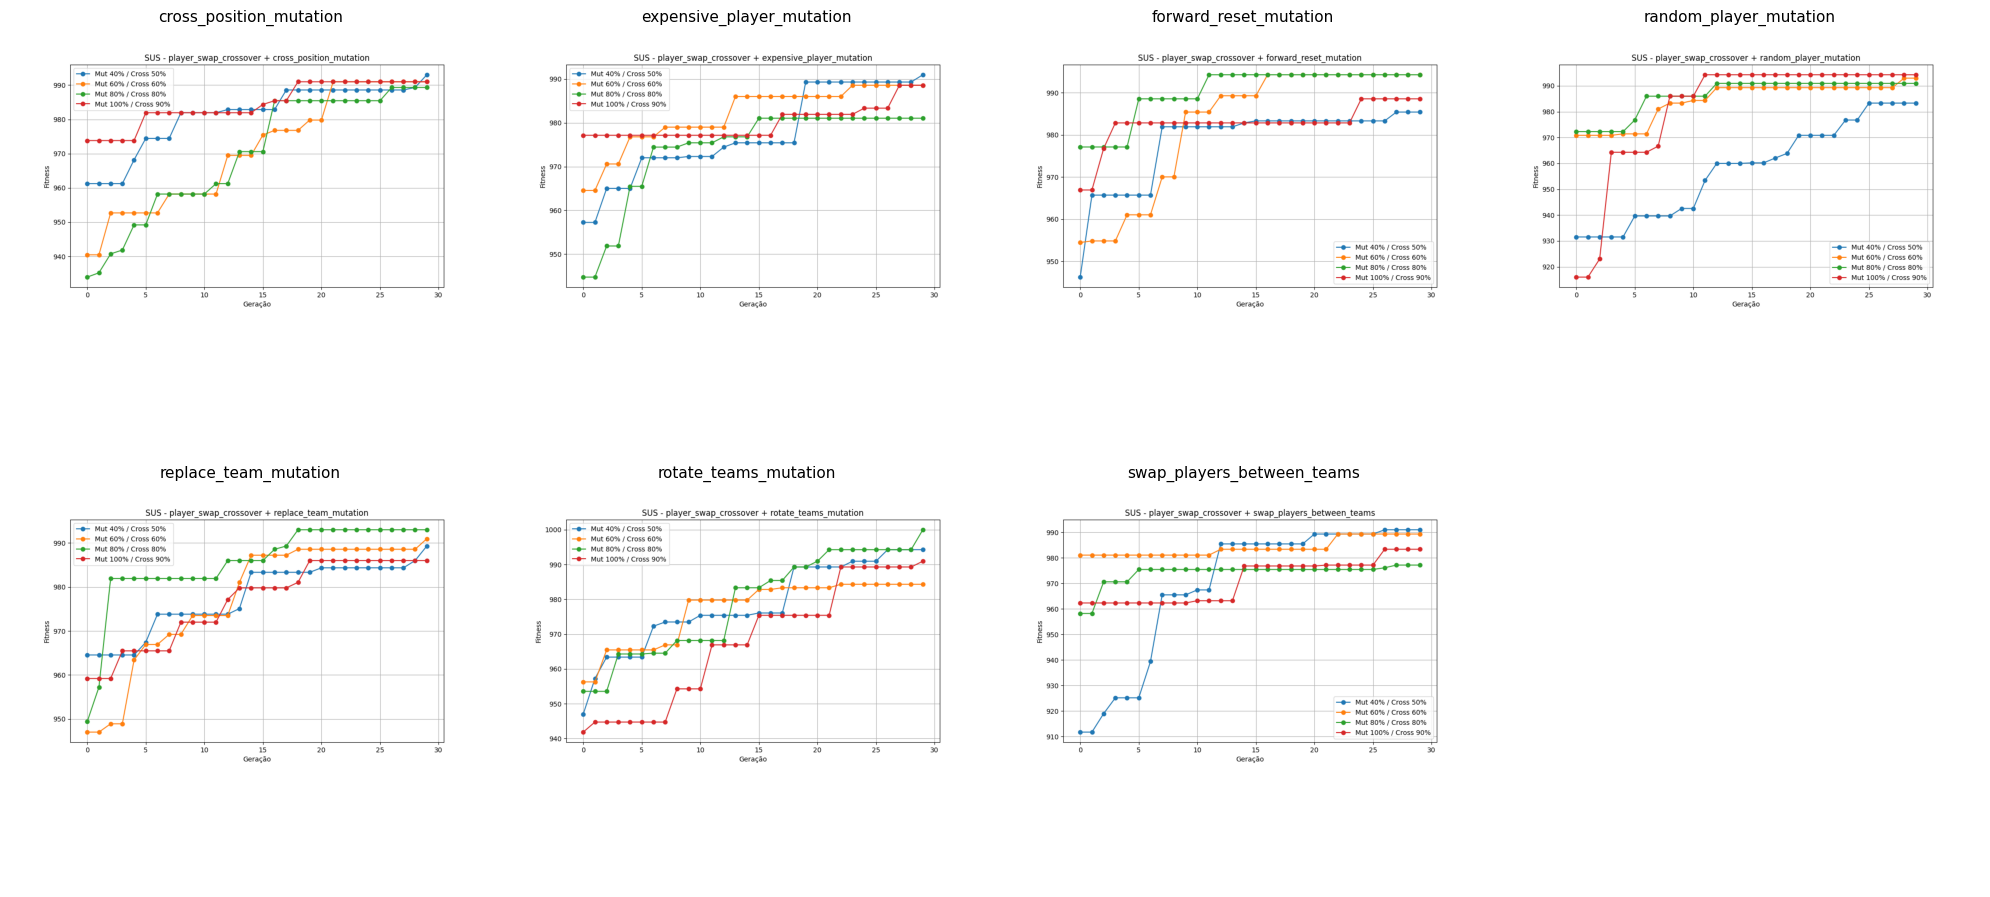

In [27]:
image_paths = [
    "../results/plots/sus/player_swap_crossover/cross_position_mutation/comparacao_taxas.png",
    "../results/plots/sus/player_swap_crossover/expensive_player_mutation/comparacao_taxas.png",
    "../results/plots/sus/player_swap_crossover/forward_reset_mutation/comparacao_taxas.png",
    "../results/plots/sus/player_swap_crossover/random_player_mutation/comparacao_taxas.png",
    "../results/plots/sus/player_swap_crossover/replace_team_mutation/comparacao_taxas.png",
    "../results/plots/sus/player_swap_crossover/rotate_teams_mutation/comparacao_taxas.png",
    "../results/plots/sus/player_swap_crossover/swap_players_between_teams/comparacao_taxas.png"
]

titles = [
    "cross_position_mutation",
    "expensive_player_mutation",
    "forward_reset_mutation",
    "random_player_mutation",
    "replace_team_mutation",
    "rotate_teams_mutation",
    "swap_players_between_teams"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (path, title) in enumerate(zip(image_paths, titles)):
    if os.path.exists(path):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=11)
    else:
        axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
        axes[i].axis('off')

if len(image_paths) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("../results/plots/sus/figura_composta_7_graficos_player_swap_crossover.png")
plt.show()

##### **Position Based Crossover**

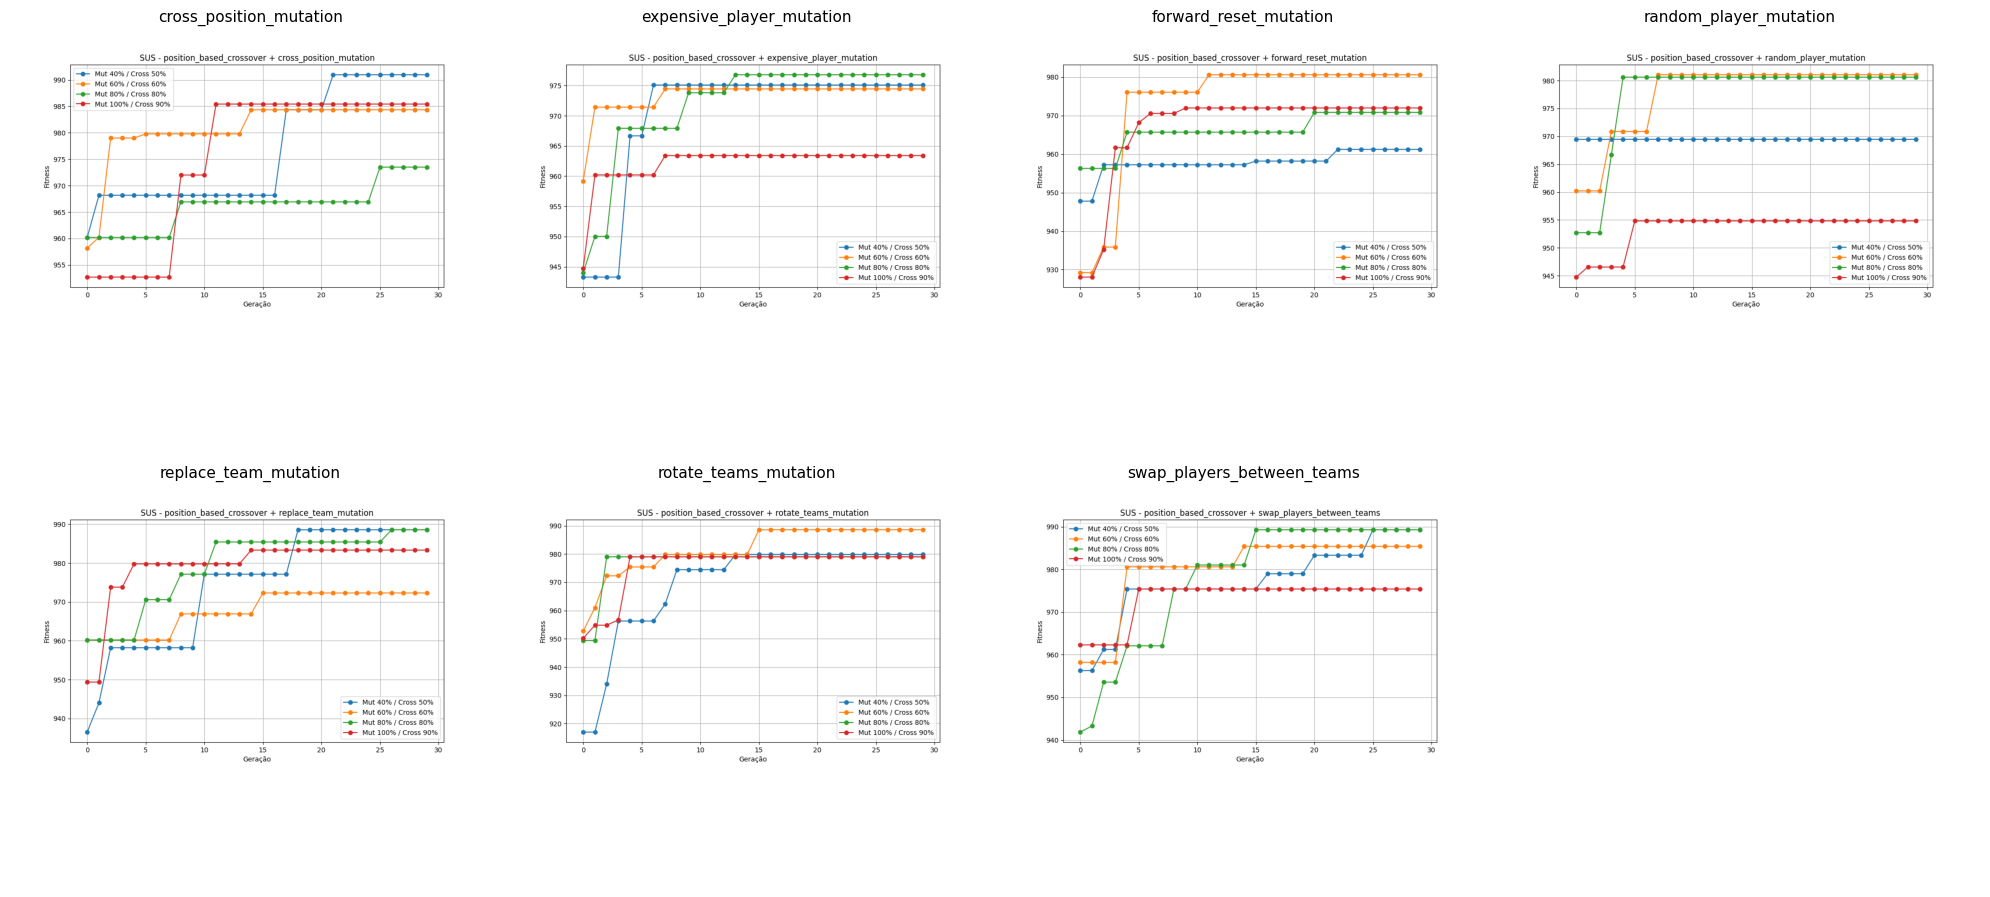

In [28]:
image_paths = [
    "../results/plots/sus/position_based_crossover/cross_position_mutation/comparacao_taxas.png",
    "../results/plots/sus/position_based_crossover/expensive_player_mutation/comparacao_taxas.png",
    "../results/plots/sus/position_based_crossover/forward_reset_mutation/comparacao_taxas.png",
    "../results/plots/sus/position_based_crossover/random_player_mutation/comparacao_taxas.png",
    "../results/plots/sus/position_based_crossover/replace_team_mutation/comparacao_taxas.png",
    "../results/plots/sus/position_based_crossover/rotate_teams_mutation/comparacao_taxas.png",
    "../results/plots/sus/position_based_crossover/swap_players_between_teams/comparacao_taxas.png"
]

titles = [
    "cross_position_mutation",
    "expensive_player_mutation",
    "forward_reset_mutation",
    "random_player_mutation",
    "replace_team_mutation",
    "rotate_teams_mutation",
    "swap_players_between_teams"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (path, title) in enumerate(zip(image_paths, titles)):
    if os.path.exists(path):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=11)
    else:
        axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
        axes[i].axis('off')

if len(image_paths) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("../results/plots/sus/figura_composta_7_graficos_position_based_crossover.png")
plt.show()

##### **Team Swap Crossover**

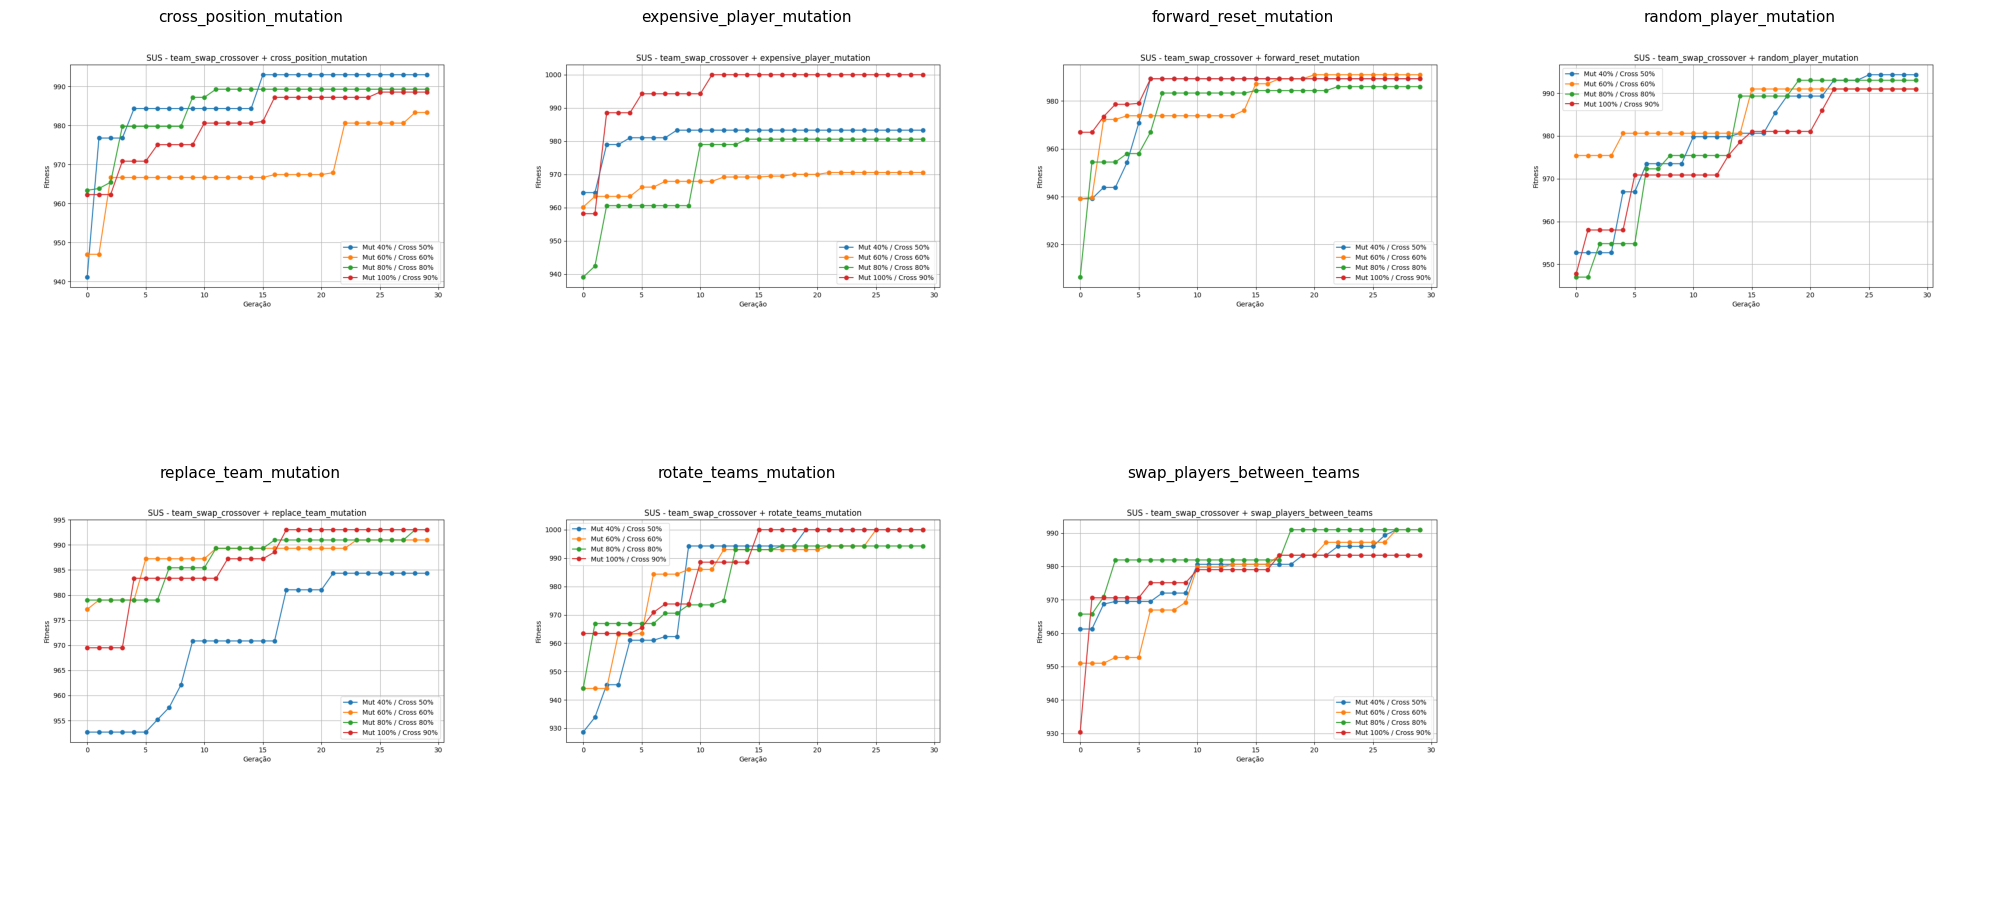

In [29]:
image_paths = [
    "../results/plots/sus/team_swap_crossover/cross_position_mutation/comparacao_taxas.png",
    "../results/plots/sus/team_swap_crossover/expensive_player_mutation/comparacao_taxas.png",
    "../results/plots/sus/team_swap_crossover/forward_reset_mutation/comparacao_taxas.png",
    "../results/plots/sus/team_swap_crossover/random_player_mutation/comparacao_taxas.png",
    "../results/plots/sus/team_swap_crossover/replace_team_mutation/comparacao_taxas.png",
    "../results/plots/sus/team_swap_crossover/rotate_teams_mutation/comparacao_taxas.png",
    "../results/plots/sus/team_swap_crossover/swap_players_between_teams/comparacao_taxas.png"
]

titles = [
    "cross_position_mutation",
    "expensive_player_mutation",
    "forward_reset_mutation",
    "random_player_mutation",
    "replace_team_mutation",
    "rotate_teams_mutation",
    "swap_players_between_teams"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (path, title) in enumerate(zip(image_paths, titles)):
    if os.path.exists(path):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=11)
    else:
        axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
        axes[i].axis('off')

if len(image_paths) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("../results/plots/sus/figura_composta_7_graficos_team_swap_crossover.png")
plt.show()

##### **Uniform Team Crossover**

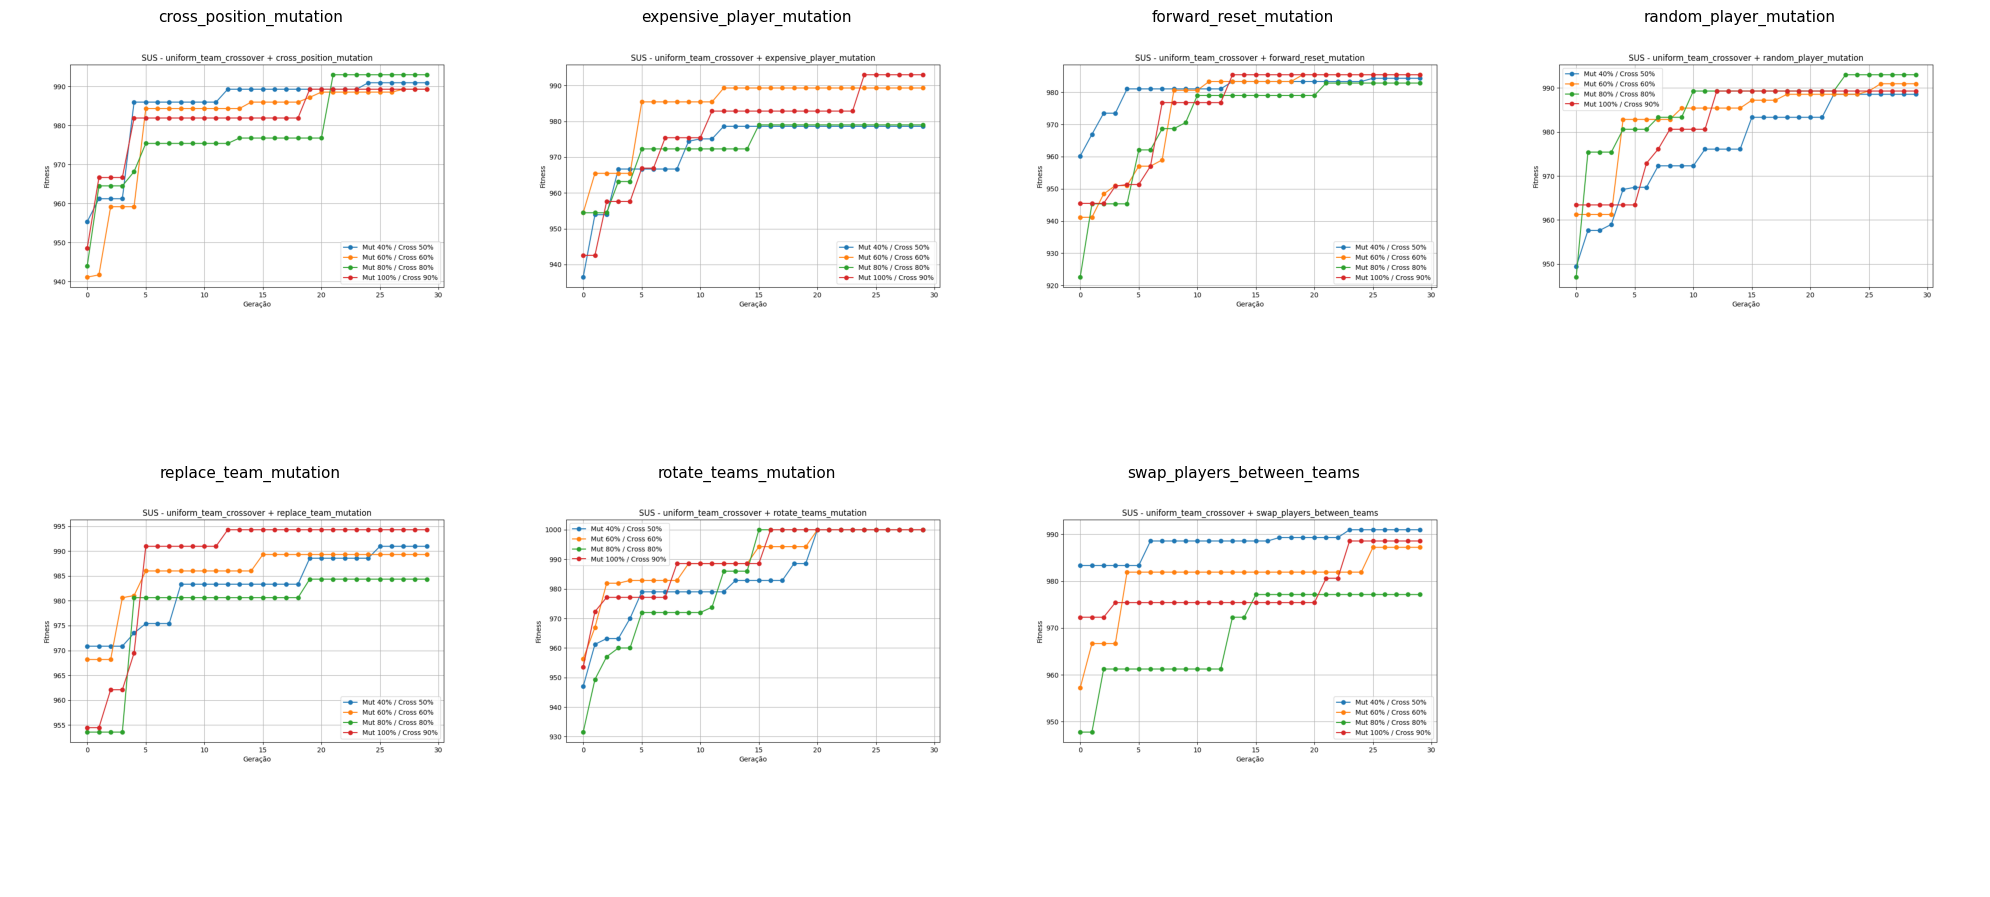

In [30]:
image_paths = [
    "../results/plots/sus/uniform_team_crossover/cross_position_mutation/comparacao_taxas.png",
    "../results/plots/sus/uniform_team_crossover/expensive_player_mutation/comparacao_taxas.png",
    "../results/plots/sus/uniform_team_crossover/forward_reset_mutation/comparacao_taxas.png",
    "../results/plots/sus/uniform_team_crossover/random_player_mutation/comparacao_taxas.png",
    "../results/plots/sus/uniform_team_crossover/replace_team_mutation/comparacao_taxas.png",
    "../results/plots/sus/uniform_team_crossover/rotate_teams_mutation/comparacao_taxas.png",
    "../results/plots/sus/uniform_team_crossover/swap_players_between_teams/comparacao_taxas.png"
]

titles = [
    "cross_position_mutation",
    "expensive_player_mutation",
    "forward_reset_mutation",
    "random_player_mutation",
    "replace_team_mutation",
    "rotate_teams_mutation",
    "swap_players_between_teams"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (path, title) in enumerate(zip(image_paths, titles)):
    if os.path.exists(path):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=11)
    else:
        axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
        axes[i].axis('off')

if len(image_paths) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("../results/plots/sus/figura_composta_7_graficos_uniform_team_crossover.png")
plt.show()

### Selection Method : **Elitism**

##### **Gene Level Crossover**

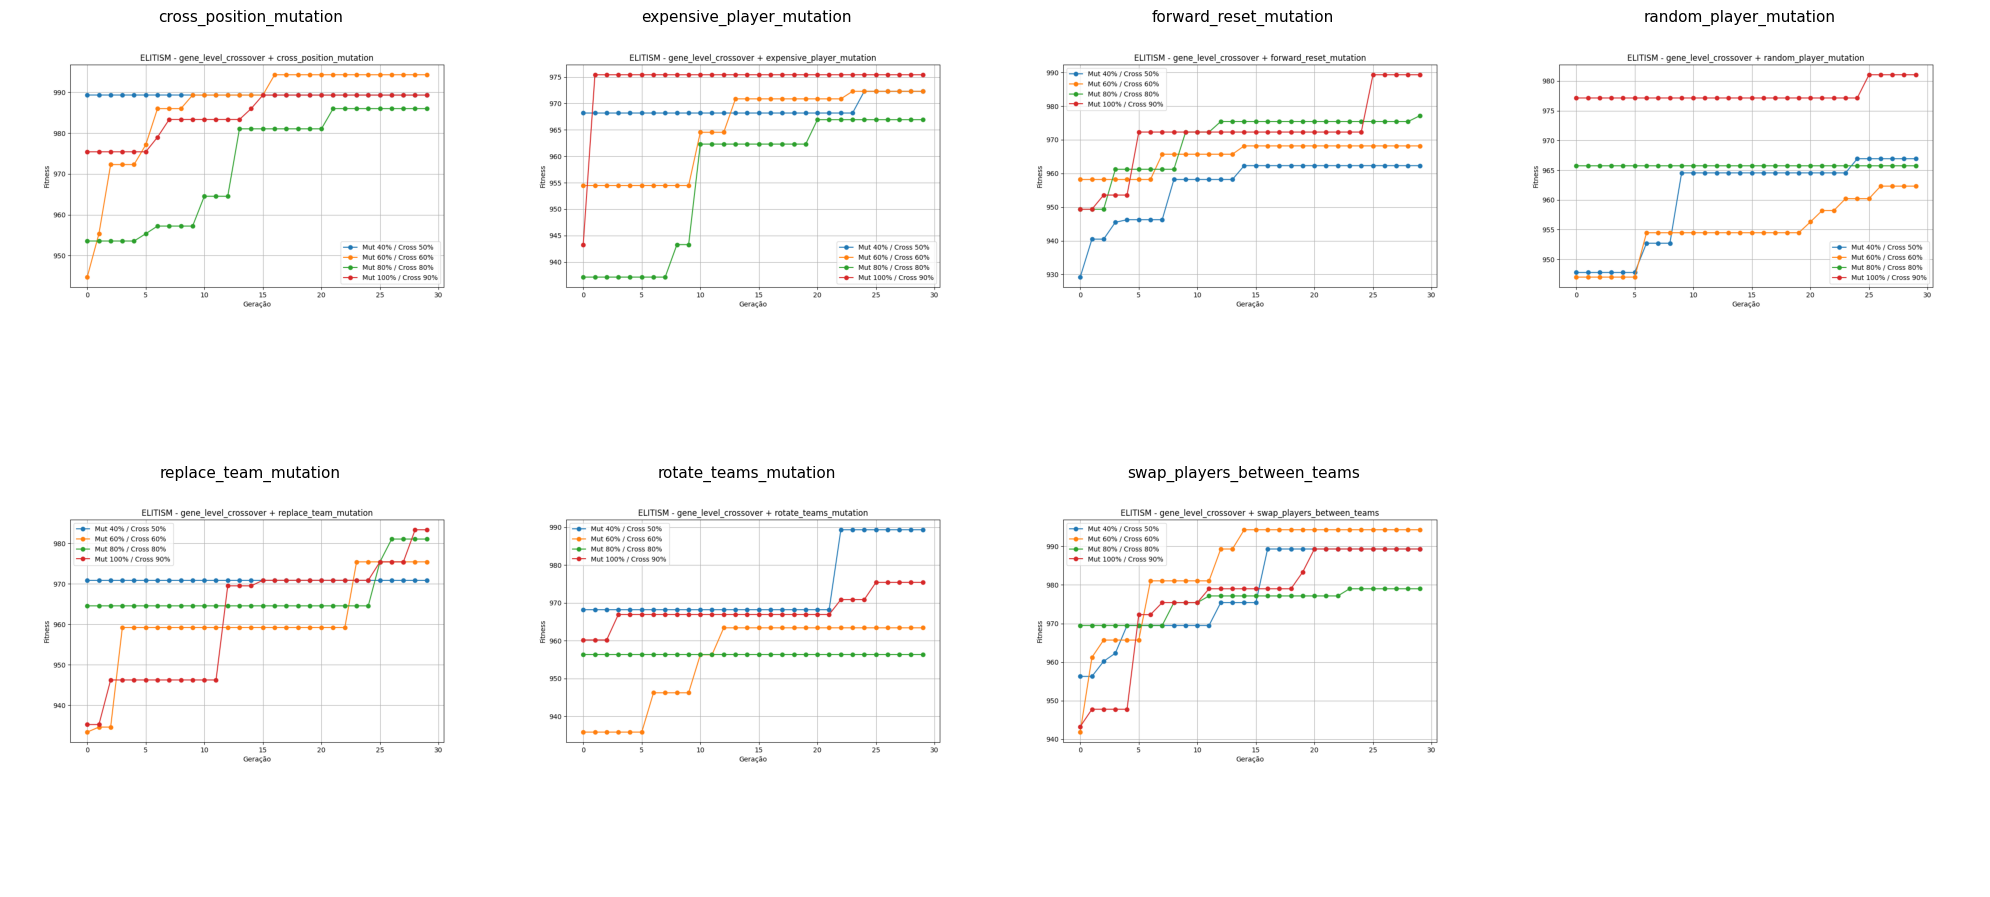

In [31]:
image_paths = [
    "../results/plots/elitism/gene_level_crossover/cross_position_mutation/comparacao_taxas.png",
    "../results/plots/elitism/gene_level_crossover/expensive_player_mutation/comparacao_taxas.png",
    "../results/plots/elitism/gene_level_crossover/forward_reset_mutation/comparacao_taxas.png",
    "../results/plots/elitism/gene_level_crossover/random_player_mutation/comparacao_taxas.png",
    "../results/plots/elitism/gene_level_crossover/replace_team_mutation/comparacao_taxas.png",
    "../results/plots/elitism/gene_level_crossover/rotate_teams_mutation/comparacao_taxas.png",
    "../results/plots/elitism/gene_level_crossover/swap_players_between_teams/comparacao_taxas.png"
]

titles = [
    "cross_position_mutation",
    "expensive_player_mutation",
    "forward_reset_mutation",
    "random_player_mutation",
    "replace_team_mutation",
    "rotate_teams_mutation",
    "swap_players_between_teams"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (path, title) in enumerate(zip(image_paths, titles)):
    if os.path.exists(path):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=11)
    else:
        axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
        axes[i].axis('off')

if len(image_paths) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("../results/plots/elitism/figura_composta_7_graficos_gene_level_crossover.png")
plt.show()

##### **Player Swap Crossover**

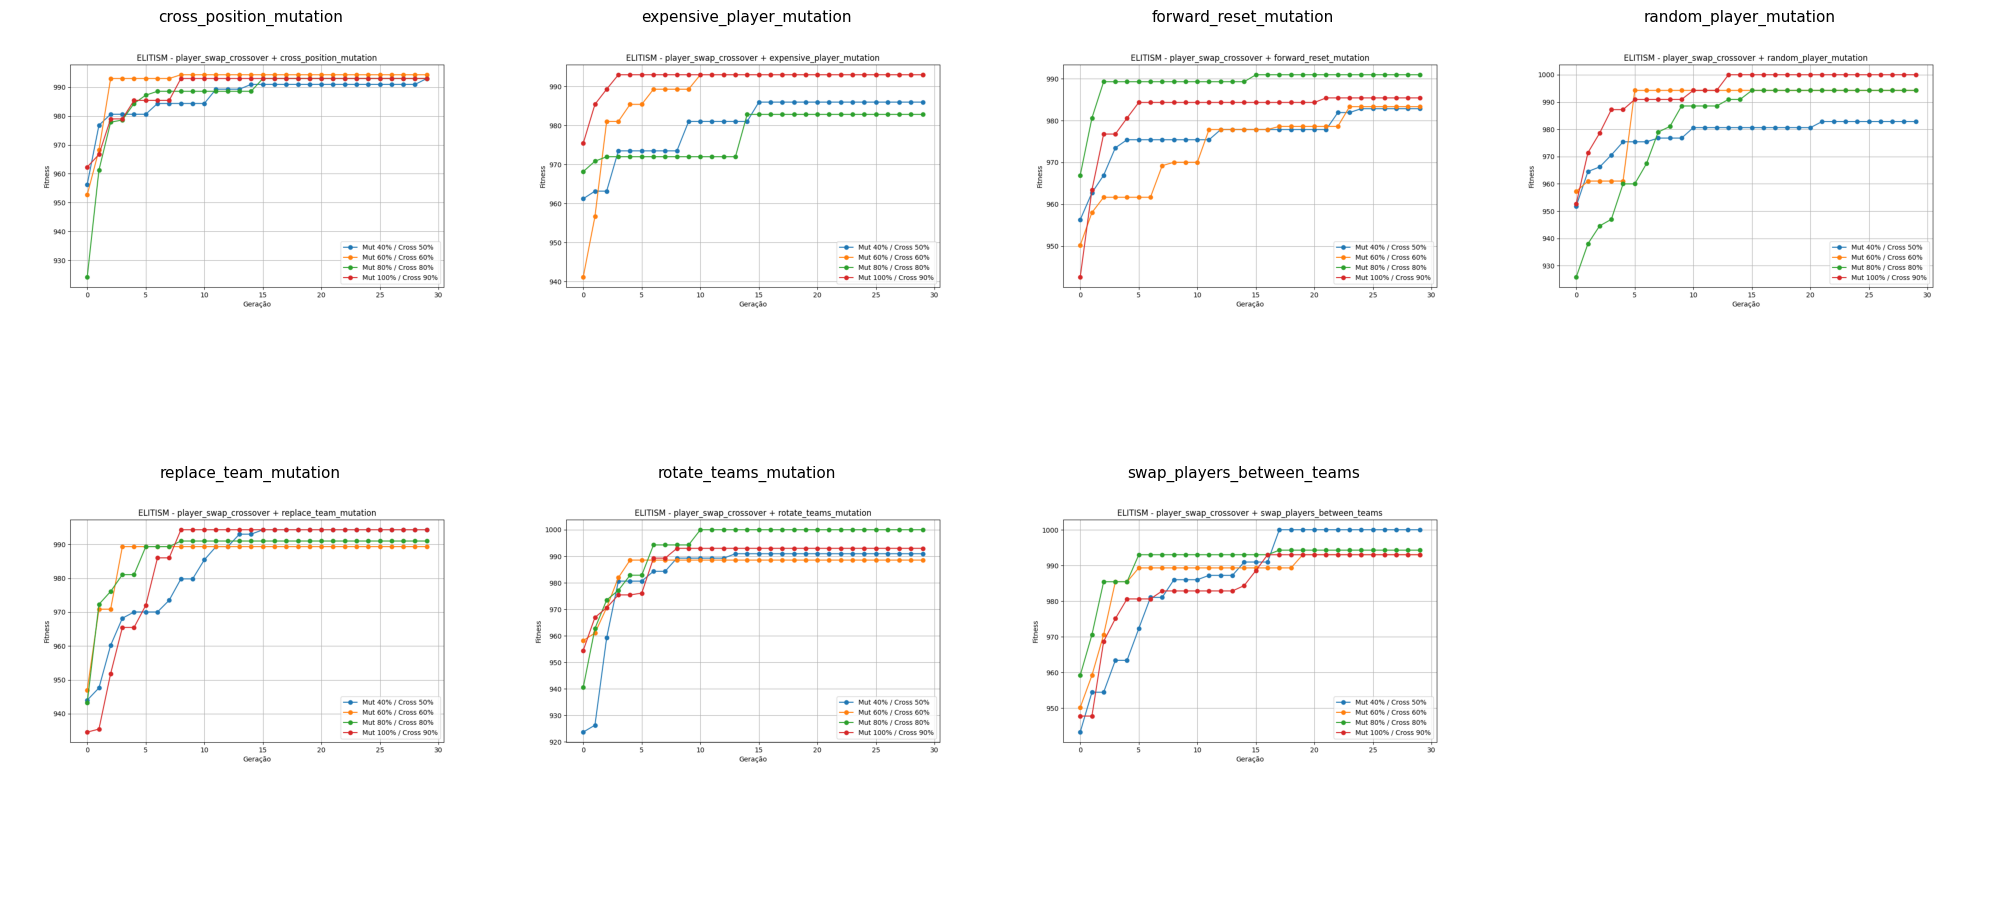

In [32]:
image_paths = [
    "../results/plots/elitism/player_swap_crossover/cross_position_mutation/comparacao_taxas.png",
    "../results/plots/elitism/player_swap_crossover/expensive_player_mutation/comparacao_taxas.png",
    "../results/plots/elitism/player_swap_crossover/forward_reset_mutation/comparacao_taxas.png",
    "../results/plots/elitism/player_swap_crossover/random_player_mutation/comparacao_taxas.png",
    "../results/plots/elitism/player_swap_crossover/replace_team_mutation/comparacao_taxas.png",
    "../results/plots/elitism/player_swap_crossover/rotate_teams_mutation/comparacao_taxas.png",
    "../results/plots/elitism/player_swap_crossover/swap_players_between_teams/comparacao_taxas.png"
]

titles = [
    "cross_position_mutation",
    "expensive_player_mutation",
    "forward_reset_mutation",
    "random_player_mutation",
    "replace_team_mutation",
    "rotate_teams_mutation",
    "swap_players_between_teams"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (path, title) in enumerate(zip(image_paths, titles)):
    if os.path.exists(path):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=11)
    else:
        axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
        axes[i].axis('off')

if len(image_paths) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("../results/plots/elitism/figura_composta_7_graficos_player_swap_crossover.png")
plt.show()

##### **Position Based Crossover**

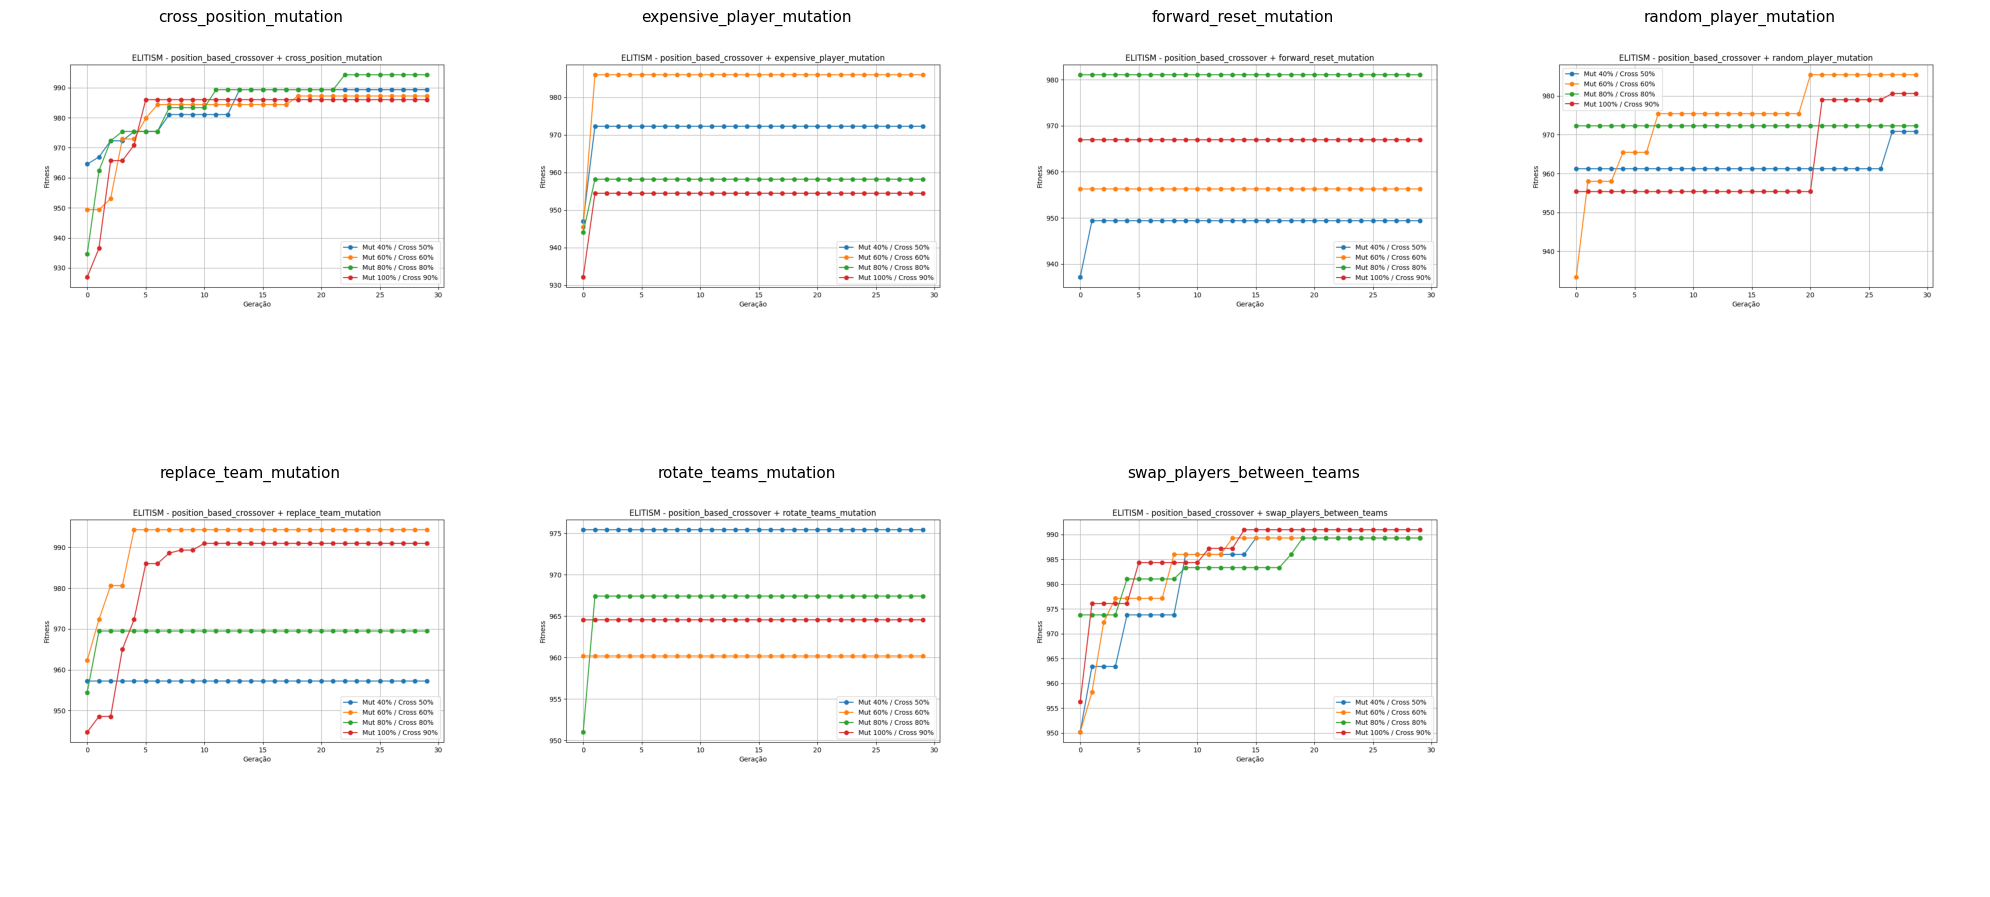

In [33]:
image_paths = [
    "../results/plots/elitism/position_based_crossover/cross_position_mutation/comparacao_taxas.png",
    "../results/plots/elitism/position_based_crossover/expensive_player_mutation/comparacao_taxas.png",
    "../results/plots/elitism/position_based_crossover/forward_reset_mutation/comparacao_taxas.png",
    "../results/plots/elitism/position_based_crossover/random_player_mutation/comparacao_taxas.png",
    "../results/plots/elitism/position_based_crossover/replace_team_mutation/comparacao_taxas.png",
    "../results/plots/elitism/position_based_crossover/rotate_teams_mutation/comparacao_taxas.png",
    "../results/plots/elitism/position_based_crossover/swap_players_between_teams/comparacao_taxas.png"
]

titles = [
    "cross_position_mutation",
    "expensive_player_mutation",
    "forward_reset_mutation",
    "random_player_mutation",
    "replace_team_mutation",
    "rotate_teams_mutation",
    "swap_players_between_teams"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (path, title) in enumerate(zip(image_paths, titles)):
    if os.path.exists(path):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=11)
    else:
        axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
        axes[i].axis('off')

if len(image_paths) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("../results/plots/elitism/figura_composta_7_graficos_position_based_crossover.png")
plt.show()

##### **Team Swap Crossover**

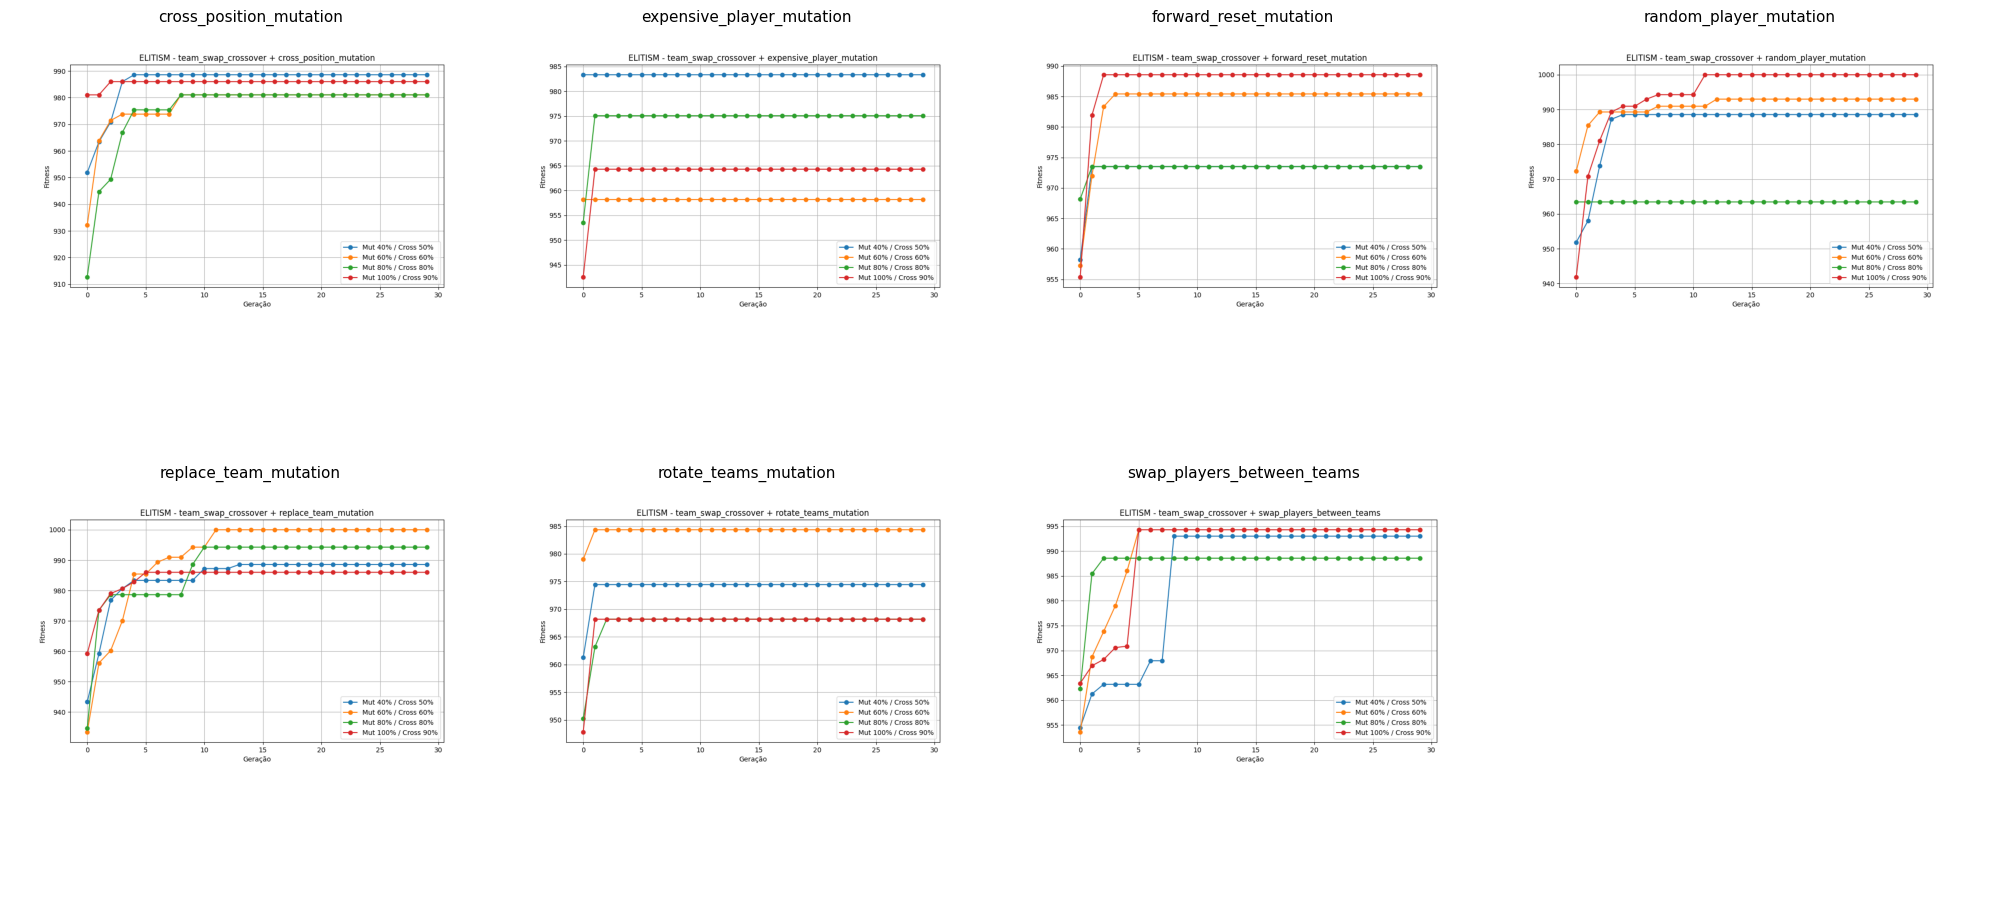

In [34]:
image_paths = [
    "../results/plots/elitism/team_swap_crossover/cross_position_mutation/comparacao_taxas.png",
    "../results/plots/elitism/team_swap_crossover/expensive_player_mutation/comparacao_taxas.png",
    "../results/plots/elitism/team_swap_crossover/forward_reset_mutation/comparacao_taxas.png",
    "../results/plots/elitism/team_swap_crossover/random_player_mutation/comparacao_taxas.png",
    "../results/plots/elitism/team_swap_crossover/replace_team_mutation/comparacao_taxas.png",
    "../results/plots/elitism/team_swap_crossover/rotate_teams_mutation/comparacao_taxas.png",
    "../results/plots/elitism/team_swap_crossover/swap_players_between_teams/comparacao_taxas.png"
]

titles = [
    "cross_position_mutation",
    "expensive_player_mutation",
    "forward_reset_mutation",
    "random_player_mutation",
    "replace_team_mutation",
    "rotate_teams_mutation",
    "swap_players_between_teams"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (path, title) in enumerate(zip(image_paths, titles)):
    if os.path.exists(path):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=11)
    else:
        axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
        axes[i].axis('off')

if len(image_paths) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("../results/plots/elitism/figura_composta_7_graficos_team_swap_crossover.png")
plt.show()

##### **Uniform Team Crossover**

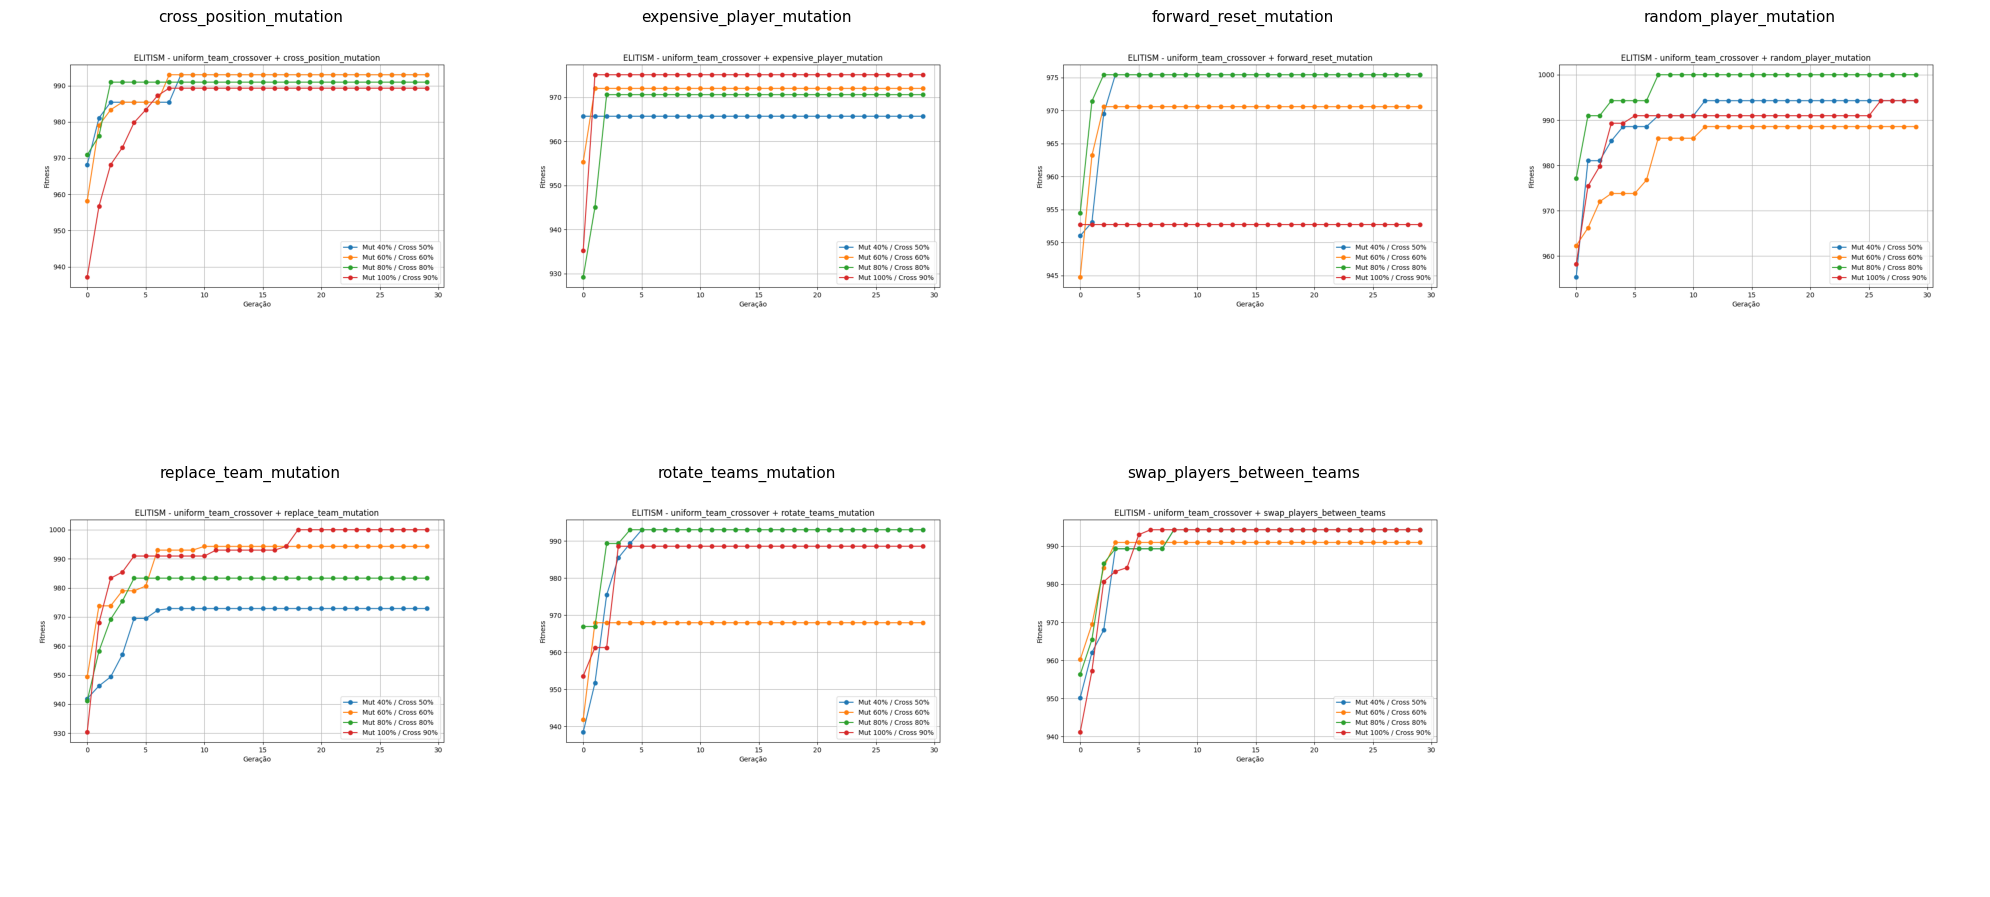

In [35]:
image_paths = [
    "../results/plots/elitism/uniform_team_crossover/cross_position_mutation/comparacao_taxas.png",
    "../results/plots/elitism/uniform_team_crossover/expensive_player_mutation/comparacao_taxas.png",
    "../results/plots/elitism/uniform_team_crossover/forward_reset_mutation/comparacao_taxas.png",
    "../results/plots/elitism/uniform_team_crossover/random_player_mutation/comparacao_taxas.png",
    "../results/plots/elitism/uniform_team_crossover/replace_team_mutation/comparacao_taxas.png",
    "../results/plots/elitism/uniform_team_crossover/rotate_teams_mutation/comparacao_taxas.png",
    "../results/plots/elitism/uniform_team_crossover/swap_players_between_teams/comparacao_taxas.png"
]

titles = [
    "cross_position_mutation",
    "expensive_player_mutation",
    "forward_reset_mutation",
    "random_player_mutation",
    "replace_team_mutation",
    "rotate_teams_mutation",
    "swap_players_between_teams"
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (path, title) in enumerate(zip(image_paths, titles)):
    if os.path.exists(path):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(title, fontsize=11)
    else:
        axes[i].text(0.5, 0.5, "Imagem não encontrada", ha='center', va='center')
        axes[i].axis('off')

if len(image_paths) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig("../results/plots/elitism/figura_composta_7_graficos_uniform_team_crossover.png")
plt.show()